In [1]:
import os
import re

import altair as alt
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pollock.utils import listfiles

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 300

###### benchmarking

In [6]:
result_dir = '/data/pollock/benchmarking/results/'
tools = ['actinn', 'mlp', 'pollock', 'scanpy', 'seurat', 'singlecellnet', 'svm_linear']

In [7]:
to_results = {}
for tool in tools:
    print(tool)
    fps = sorted(listfiles(os.path.join(result_dir, tool), regex=r'clf_report.txt$'))
    fps = [fp for fp in fps if 'interdataset_with_folds' not in fp]
    fps = [fp for fp in fps if fp.split('/')[-2]==tool]
    to_results[tool] = {}
    for fp in fps:
        root = fp.split('/')[-1].split('_clf_report')[0]
        root = root.replace('_gene_activity', '')
        dtype, disease = root.split('_')
        
        if dtype not in to_results[tool]:
            to_results[tool][dtype] = {}
            
        to_results[tool][dtype][disease] = pd.read_csv(fp, sep='\t', index_col=0)
to_results['pollock']['scRNAseq']['brca']

actinn
mlp
pollock
scanpy
seurat
singlecellnet
svm_linear


B cell  CD4 T cell  CD8 T cell   Dendritic  Endothelial  \
metric                                                                   
precision    0.982283    0.759615    0.762646    0.932143     0.915187   
recall       0.998000    0.790000    0.784000    0.959559     0.928000   
f1-score     0.990079    0.774510    0.773176    0.945652     0.921549   
support    500.000000  500.000000  500.000000  272.000000   500.000000   

           Erythrocyte  Fibroblast   Malignant        Mast    Monocyte  \
metric                                                                   
precision     0.920398    0.917148    0.882591    0.991736    0.881356   
recall        0.804348    0.952000    0.872000    0.975610    0.832000   
f1-score      0.858469    0.934249    0.877264    0.983607    0.855967   
support     230.000000  500.000000  500.000000  246.000000  500.000000   

                   NK      Plasma        Treg  accuracy    macro avg  \
metric                                                                 
precision    0.946467    0.879079    0.862823  0.886917     0.894882   
recall       0.884000    0.916000    0.868000  0.886917     0.889501   
f1-score     0.914168    0.897160    0.865404  0.886917     0.891635   
support    500.000000  500.000000  500.000000  0.886917  5748.000000   

           weighted avg  
metric                   
precision      0.887926  
recall         0.886917  
f1-score       0.886986  
support     5748.000000

f1 plot all tools

In [8]:
pred_map = {}
for dtype in to_results['pollock'].keys():
    data = []
    for tool in tools:
        d = to_results[tool][dtype]
        for disease, df in d.items():
            data.append([disease, tool, df.loc['f1-score', 'macro avg']])
    pred_map[dtype] = pd.DataFrame(data=data, columns=['disease', 'method', 'f1-score'])
pred_map['scRNAseq']

disease         method  f1-score
0       brca         actinn  0.893073
1       cesc         actinn  0.964725
2      hnscc         actinn  0.887303
3       pdac         actinn  0.857903
4       brca            mlp  0.851099
5       cesc            mlp  0.640618
6      hnscc            mlp  0.880487
7   melanoma            mlp  0.832387
8    myeloma            mlp  0.661043
9       pdac            mlp  0.708227
10      brca        pollock  0.891635
11      cesc        pollock  0.952926
12     hnscc        pollock  0.883052
13  melanoma        pollock  0.947998
14   myeloma        pollock  0.831050
15      pdac        pollock  0.852397
16      brca         scanpy  0.898316
17      cesc         scanpy  0.951287
18     hnscc         scanpy  0.891524
19  melanoma         scanpy  0.947232
20   myeloma         scanpy  0.841006
21      pdac         scanpy  0.827541
22      brca         seurat  0.899986
23      cesc         seurat  0.961425
24     hnscc         seurat  0.892503
25  melanoma         seurat  0.949852
26   myeloma         seurat  0.845333
27      pdac         seurat  0.838400
28      brca  singlecellnet  0.888500
29      cesc  singlecellnet  0.957437
30     hnscc  singlecellnet  0.875797
31  melanoma  singlecellnet  0.936326
32   myeloma  singlecellnet  0.840156
33      pdac  singlecellnet  0.855685
34      brca     svm_linear  0.824228
35      cesc     svm_linear  0.893889
36     hnscc     svm_linear  0.809901
37  melanoma     svm_linear  0.930944
38   myeloma     svm_linear  0.791720
39      pdac     svm_linear  0.737652

In [9]:
dtype_order = ['scRNAseq', 'snRNAseq', 'snATACseq']
def make_tick_chart(df, title='', show_axis=True, scale_zero=False, scale_domain=[0., 1.]):
    chart = alt.Chart(df, title=title)
    chart = chart.mark_tick(thickness=2,).encode(
        y=alt.Y(f'disease:N', axis=alt.Axis(title=None)),
        x=alt.X(f'f1-score:Q', scale=alt.Scale(zero=scale_zero, domain=scale_domain), axis=alt.Axis(grid=True, labels=show_axis,
                                                                        title='F1-score' if show_axis else None)),
        color=alt.Color('method:N', sort=['pollock'])
    )
    return chart

def make_point_chart(df, show_axis=True, scale_zero=False, scale_domain=[0., 1.]):
    chart = alt.Chart(df)
    chart = chart.mark_point().encode(
        y=alt.Y(f'disease:N', axis=alt.Axis(title=None)),
        x=alt.X(f'f1-score:Q', scale=alt.Scale(zero=scale_zero, domain=scale_domain), axis=alt.Axis(grid=True, labels=show_axis,
                                                                        title='F1-score' if show_axis else None)),
        color=alt.Color('method:N', sort=['pollock'])
    )
    return chart

def make_chart(df, title='', show_axis=True, color='red', scale_zero=False, scale_domain=[0., 1.]):
    chart = alt.Chart(df, title=title)
    chart = chart.mark_point(color=color).encode(
        y=alt.Y(f'disease:N', axis=alt.Axis(title=None)),
        x=alt.X(f'f1-score:Q', scale=alt.Scale(zero=scale_zero, domain=scale_domain), axis=alt.Axis(grid=True, labels=show_axis,
                                                                        title='F1-score' if show_axis else None)),
        shape=alt.Shape('method:N', sort=['pollock'])
#         color=alt.Color('method:N', sort=['Pollock'])
    )
    return chart

In [10]:
combined = None
for i, dtype in enumerate(dtype_order):
    df = pred_map[dtype]
    print(df.shape)
    chart = make_point_chart(df, show_axis=True if i==2 else False, scale_domain=[.6, 1.]) + make_tick_chart(df, title=dtype, show_axis=True if i==2 else False, scale_domain=[.6, 1.])
#     chart = make_chart(df, title=dtype, show_axis=True if i==2 else False, color=sns.color_palette().as_hex()[i])
    if combined is None:
        combined = chart
    else:
        combined = alt.vconcat(combined, chart)
#         combined |= chart
combined.resolve_scale(x='shared', )

(40, 3)
(21, 3)
(21, 3)


alt.VConcatChart(...)

f1 plot general

In [13]:
general_results_dir = '/data/pollock/benchmarking/results/pollock/generalized/'
fps = sorted(listfiles(general_results_dir, regex=r'clf_report.txt$'))
general_to_results = {}
for fp in fps:
    root = fp.split('/')[-1].split('_clf_report')[0]
    root = root.replace('_gene_activity', '')
    dtype, disease = root.split('_')

    if dtype not in general_to_results:
        general_to_results[dtype] = {}
    
    general_to_results[dtype][disease] = pd.read_csv(fp, sep='\t', index_col=0)
    
general_to_results['scRNAseq']['brca']

Acinar      B cell  CD4 T cell  CD8 T cell   Dendritic  \
metric                                                              
precision     0.0    0.984158    0.704918    0.658182    0.868613   
recall        0.0    0.994000    0.688000    0.724000    0.875000   
f1-score      0.0    0.989055    0.696356    0.689524    0.871795   
support       0.0  500.000000  500.000000  500.000000  272.000000   

           Endothelial  Erythrocyte  Fibroblast  Islet   Malignant  \
metric                                                               
precision     0.888446     0.858209    0.908367    0.0    0.759931   
recall        0.892000     0.500000    0.912000    0.0    0.880000   
f1-score      0.890220     0.631868    0.910180    0.0    0.815570   
support     500.000000   230.000000  500.000000    0.0  500.000000   

                 Mast    Monocyte          NK      Plasma        Treg  \
metric                                                                  
precision    0.987603    0.765568    0.873321    0.908686    0.868889   
recall       0.971545    0.836000    0.910000    0.816000    0.782000   
f1-score     0.979508    0.799235    0.891283    0.859852    0.823158   
support    246.000000  500.000000  500.000000  500.000000  500.000000   

           accuracy    macro avg  weighted avg  
metric                                          
precision  0.836639     0.735659      0.841481  
recall     0.836639     0.718703      0.836639  
f1-score   0.836639     0.723174      0.836053  
support    0.836639  5748.000000   5748.000000

In [14]:
pred_map = {}
for dtype in to_results['pollock'].keys():
    data = []
    d = to_results['pollock'][dtype]
    for disease, df in d.items():
        data.append([disease, 'pollock: disease-specific', df.loc['f1-score', 'macro avg']])
        
    d = general_to_results[dtype]
    for disease, df in d.items():
        data.append([disease, 'pollock: generalized', df.loc['f1-score', 'macro avg']])
        
    pred_map[dtype] = pd.DataFrame(data=data, columns=['disease', 'method', 'f1-score'])
pred_map['scRNAseq']

disease                     method  f1-score
0       brca  pollock: disease-specific  0.891635
1       cesc  pollock: disease-specific  0.952926
2      hnscc  pollock: disease-specific  0.883052
3   melanoma  pollock: disease-specific  0.947998
4    myeloma  pollock: disease-specific  0.831050
5       pdac  pollock: disease-specific  0.852397
6       brca       pollock: generalized  0.723174
7       cesc       pollock: generalized  0.546070
8        hca       pollock: generalized  0.110584
9      hnscc       pollock: generalized  0.674905
10  melanoma       pollock: generalized  0.651461
11   myeloma       pollock: generalized  0.515339
12      pdac       pollock: generalized  0.817434

In [15]:
combined = None
for i, dtype in enumerate(dtype_order):
    df = pred_map[dtype]
    print(df.shape)
    chart = make_point_chart(df, show_axis=True if i==2 else False, scale_domain=[.4, 1.]) + make_tick_chart(df, title=dtype, show_axis=True if i==2 else False, scale_domain=[.4, 1.])
#     chart = make_chart(df, title=dtype, show_axis=True if i==2 else False, color=sns.color_palette().as_hex()[i])
    if combined is None:
        combined = chart
    else:
        combined = alt.vconcat(combined, chart)
#         combined |= chart
combined.resolve_scale(x='shared', )

(13, 3)
(6, 3)
(6, 3)


alt.VConcatChart(...)

confusion matrices general

In [216]:
fps = sorted(listfiles('/data/pollock/benchmarking/results/pollock/generalized/', regex='.h5ad$'))

fps

['/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_brca.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_cesc.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_hca.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_hnscc.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_melanoma.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_myeloma.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/scRNAseq_pdac.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/snATACseq_brca.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/snATACseq_ccrcc.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/snATACseq_gbm.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/snRNAseq_brca.h5ad',
 '/data/pollock/benchmarking/results/pollock/generalized/snRNAseq_ccrcc.h5ad',
 '/data/pollock/benchmarking/results/pollock/generali

In [217]:
to_combined = {}
for fp in fps:
    root = fp.split('/')[-1].replace('.h5ad', '')
    dtype, disease = root.split('_')
    
    if disease == 'hca':
        dtype = 'hca'
    
    if dtype not in to_combined:
        to_combined[dtype] = None
        
    df = sc.read_h5ad(fp).obs[['cell_type', 'predicted_cell_type']]
    df['disease'] = disease
    
    if to_combined[dtype] is None:
        to_combined[dtype] = df
    else:
        to_combined[dtype] = pd.concat((to_combined[dtype], df), axis=0)
to_combined['scRNAseq']

/tmp/ipykernel_12940/2753350732.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disease'] = disease


cell_type predicted_cell_type disease
0_AACCAACTCCACTAGA-1   Endothelial         Endothelial    brca
0_AACCCAAAGACGAGCT-1            NK                  NK    brca
0_AACGTCAGTTTACACG-1   Endothelial         Endothelial    brca
0_AACTTCTGTCCAGAAG-1    CD8 T cell          CD8 T cell    brca
0_AAGCCATAGTGATTCC-1   Endothelial         Endothelial    brca
...                            ...                 ...     ...
57_TGCACGGGTCAATCTG-1  Endothelial         Endothelial    pdac
57_TGGATGTAGTCTGTAC-1   Fibroblast          Fibroblast    pdac
57_TTCGCTGGTCTTCATT-1  Endothelial         Endothelial    pdac
57_TTGCATTCATAGAGGC-1     Monocyte           Dendritic    pdac
57_TTTGATCGTGACTCTA-1  Endothelial         Endothelial    pdac

[29877 rows x 3 columns]

In [218]:
set(to_combined['scRNAseq']['cell_type'])

{'Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Epithelial',
 'Erythrocyte',
 'Fibroblast',
 'Islet',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Platlete',
 'Treg',
 'Tuft'}

In [219]:
set(to_combined['scRNAseq']['predicted_cell_type'])

{'Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Erythrocyte',
 'Fibroblast',
 'Islet',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [220]:
from sklearn.metrics import classification_report, confusion_matrix

def get_metrics(y_true_labels, y_pred_labels, overlapping_only=False):
    classes = sorted(set(y_true_labels).union(set(y_pred_labels)))
    
    if overlapping_only:
        classes = [c for c in classes if c in y_pred_labels]
        y_pred_labels, y_true_labels = zip(*[(p, t) for p, t in zip(y_pred_labels, y_true_labels)
                              if t in classes])
        classes = sorted(set(y_true_labels).union(set(y_pred_labels)))
        
    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    d = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    d = pd.DataFrame.from_dict(d)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    d.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return d, cm

In [221]:
_, cm = get_metrics(to_combined['scRNAseq']['cell_type'].to_list(),
                    to_combined['scRNAseq']['predicted_cell_type'].to_list(),
                    overlapping_only=True)
cm

Acinar  B cell  CD4 T cell  CD8 T cell  Dendritic  Endothelial  \
cell_type                                                                     
Acinar          411       3           7           8          0           21   
B cell            0    2441          12           5         14            0   
CD4 T cell        0      21        2164         432          0            1   
CD8 T cell        3      12         352        2227          1            2   
Dendritic         0       8           2           6        865            0   
Endothelial       3       1           0           0          0         1639   
Erythrocyte       3      34          48          54          4           75   
Fibroblast        0       2           6           0          1           13   
Islet             0       4           7           4          1            7   
Malignant         3       7          26           5          0           16   
Mast              0       6           5           0          5           10   
Monocyte          0      18          18           6        179            5   
NK                1      11          55         287         10            2   
Plasma            3      17          21          14          8            4   
Treg              1       3         198         103          1            0   

             Erythrocyte  Fibroblast  Islet  Malignant  Mast  Monocyte    NK  \
cell_type                                                                      
Acinar                 4           3      0         37     0         2     0   
B cell                 3           0      0          5     0         4     1   
CD4 T cell            10           5      3         20     0        14   104   
CD8 T cell             6           0      1         10     3         4   217   
Dendritic              7           1      0          5     0       331    65   
Endothelial            7          42      0         32     1         2     1   
Erythrocyte          450           5      0          6     0        59     8   
Fibroblast             2        1495     13         52     3         5     1   
Islet                  4          12    424         34     0         0     2   
Malignant             16          42      3       2744     0        23    15   
Mast                   1          24      0         10  1206         4     1   
Monocyte              24          18      0         45    13      2654     2   
NK                     4           8      0         13     4         1  2336   
Plasma                13           9      5         88     2        30     7   
Treg                   5           0      0          5     1         2    25   

             Plasma  Treg  
cell_type                  
Acinar            4     0  
B cell           13     2  
CD4 T cell        7   219  
CD8 T cell        6   156  
Dendritic         1     1  
Endothelial       3     1  
Erythrocyte       7     3  
Fibroblast        6     0  
Islet             0     1  
Malignant        99     1  
Mast              5     3  
Monocyte         15     3  
NK                1     8  
Plasma         1849     8  
Treg              5  1513

In [275]:
def plot_confusion_matrix(cm, cmap='Blues', figsize=(7, 6), scale_axis=1, scale=True):
    if scale:
        if scale_axis == 1:
            cm = pd.DataFrame(cm.values / np.expand_dims(np.sum(cm.values, axis=1), axis=-1),
                              columns=cm.columns, index=cm.index)
        else:
            cm = cm / cm.sum(axis=0)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, cmap=cmap)
    plt.tight_layout()

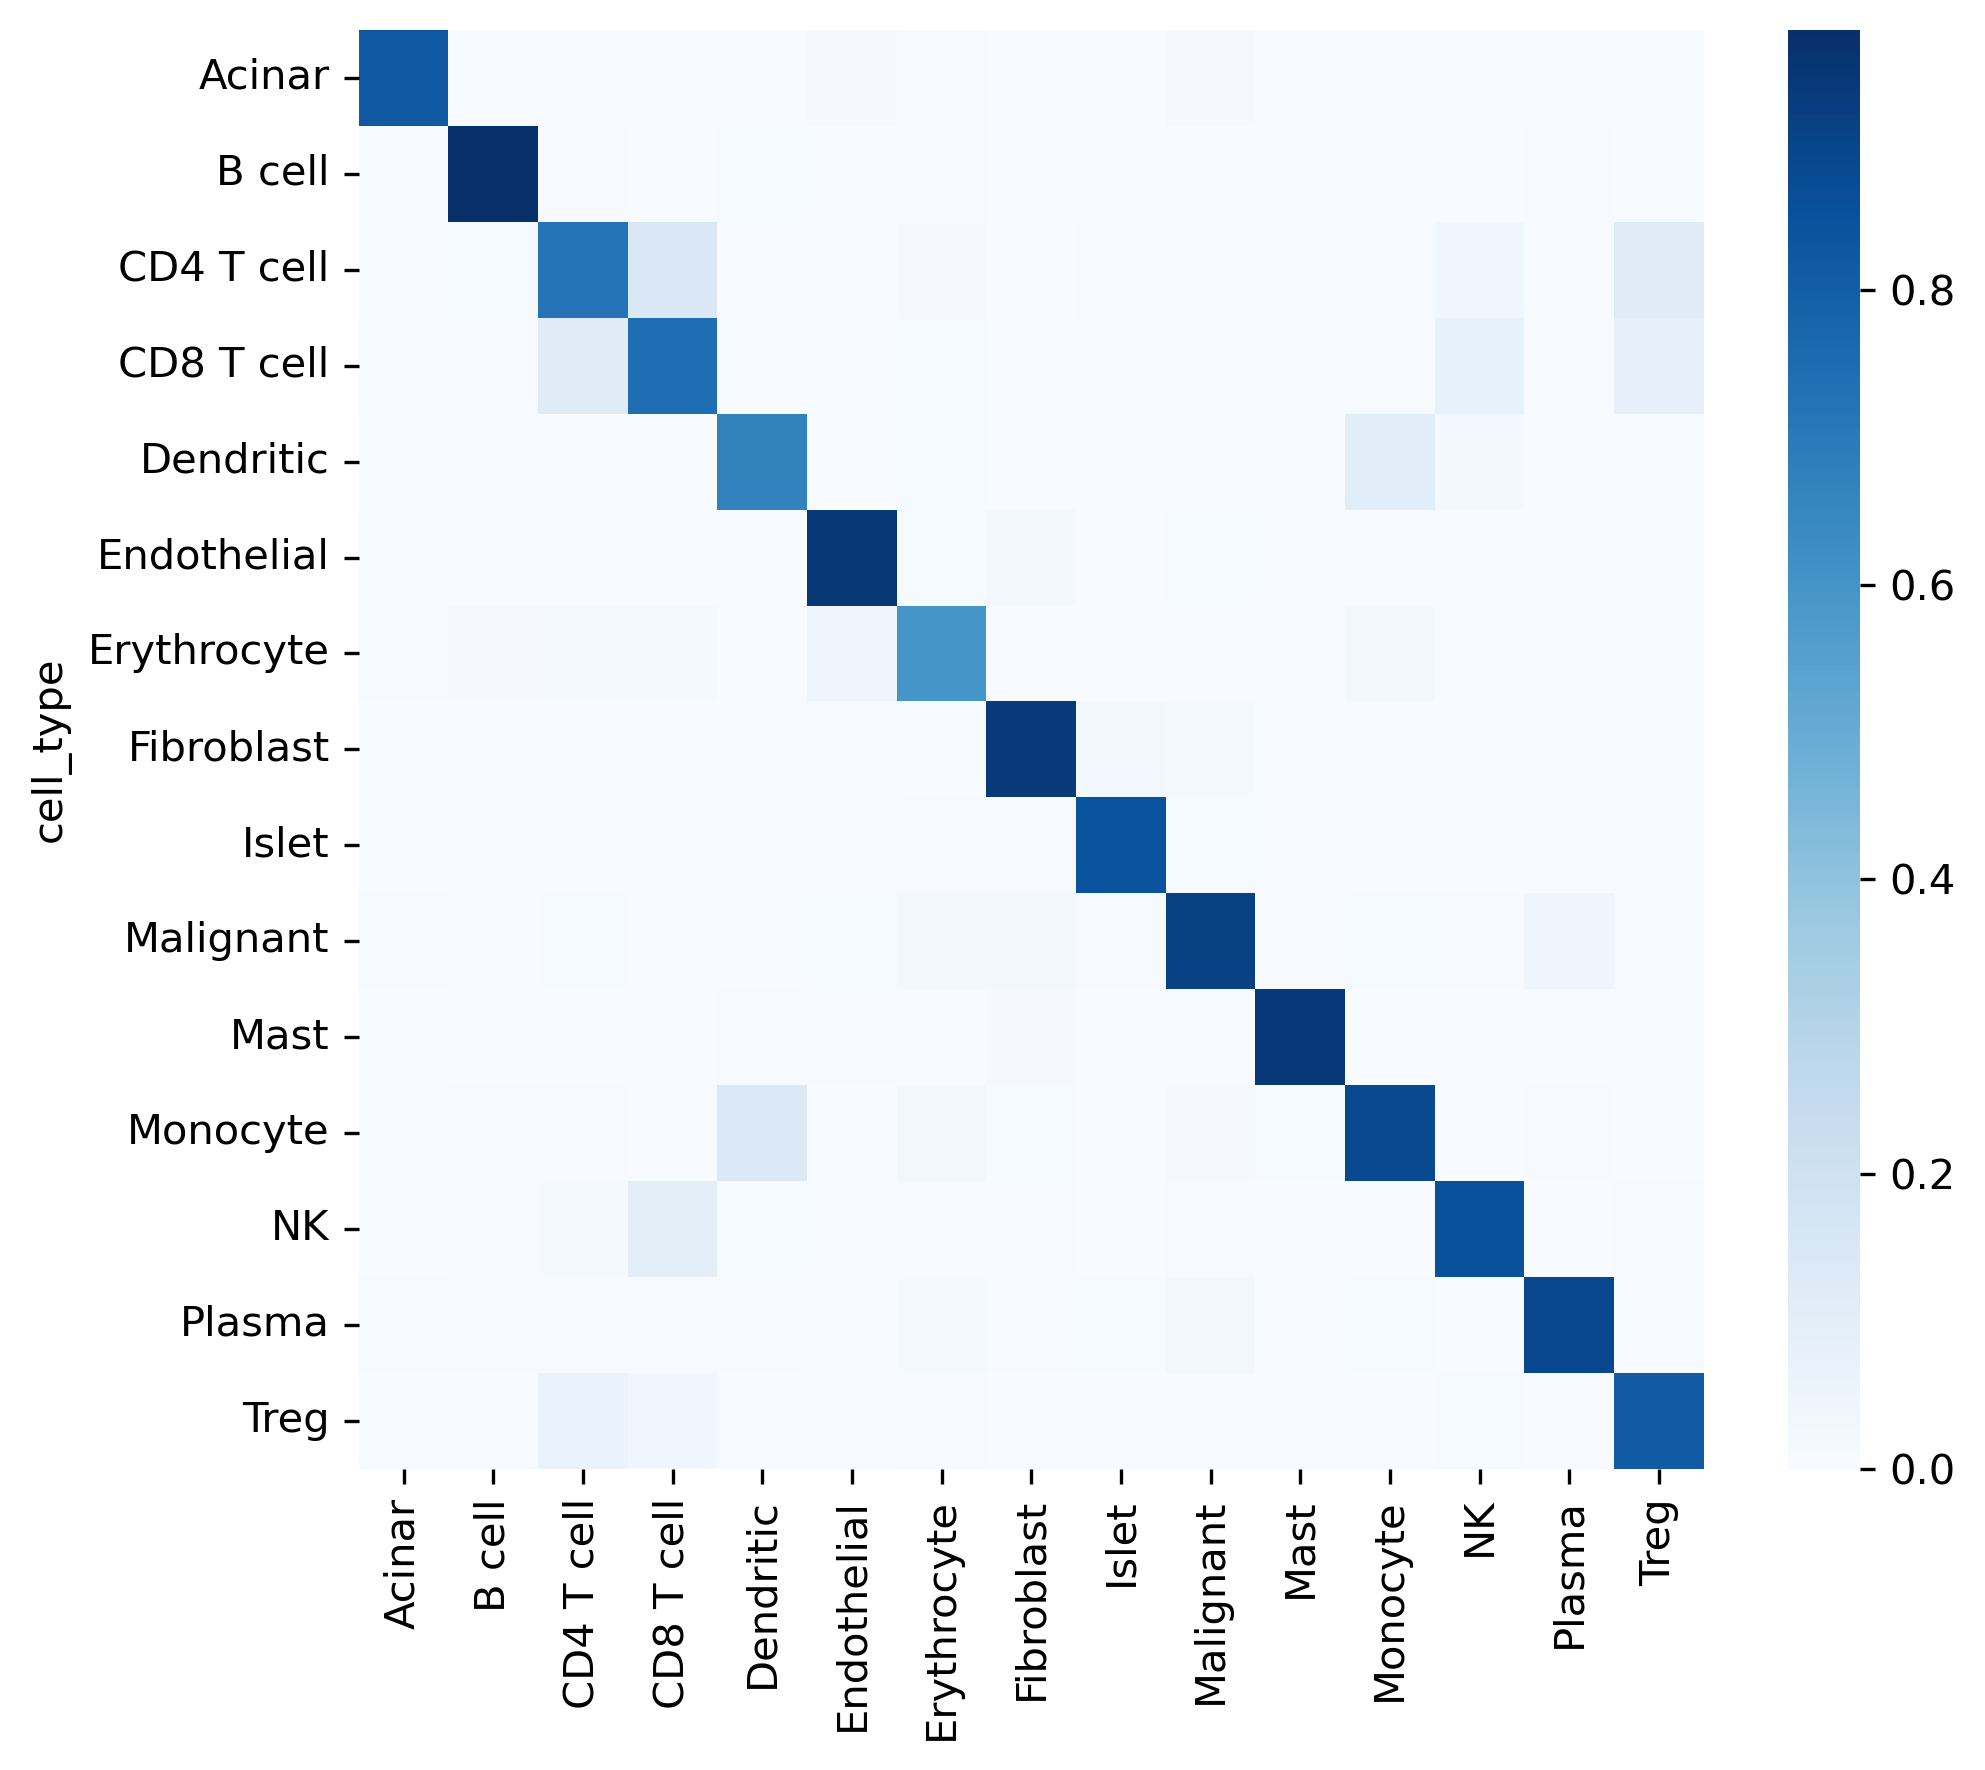

In [225]:
plot_confusion_matrix(cm)

scRNAseq


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

hca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


snATACseq


2022-01-20 11:07:15,950 maxp pruned
2022-01-20 11:07:15,960 cmap pruned
2022-01-20 11:07:15,961 kern dropped
2022-01-20 11:07:15,962 post pruned
2022-01-20 11:07:15,963 FFTM dropped
2022-01-20 11:07:15,966 GPOS pruned
2022-01-20 11:07:15,971 GSUB pruned
2022-01-20 11:07:15,973 name pruned
2022-01-20 11:07:15,984 glyf pruned
2022-01-20 11:07:15,985 Added gid0 to subset
2022-01-20 11:07:15,986 Added first four glyphs to subset
2022-01-20 11:07:15,986 Closing glyph list over 'GSUB': 36 glyphs before
2022-01-20 11:07:15,987 Glyph names: ['.notdef', '.null', 'B', 'D', 'E', 'F', 'M', 'N', 'O', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
2022-01-20 11:07:15,989 Glyph IDs:   [0, 1, 2, 3, 17, 19, 21, 23, 25, 27, 37, 39, 40, 41, 48, 49, 50, 55, 66, 68, 69, 70, 71, 72, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88, 92]
2022-01-20 11:07:15,994 Closed glyph list ove

snRNAseq


2022-01-20 11:07:16,421 maxp pruned
2022-01-20 11:07:16,434 cmap pruned
2022-01-20 11:07:16,435 kern dropped
2022-01-20 11:07:16,436 post pruned
2022-01-20 11:07:16,437 FFTM dropped
2022-01-20 11:07:16,440 GPOS pruned
2022-01-20 11:07:16,446 GSUB pruned
2022-01-20 11:07:16,448 name pruned
2022-01-20 11:07:16,457 glyf pruned
2022-01-20 11:07:16,459 Added gid0 to subset
2022-01-20 11:07:16,460 Added first four glyphs to subset
2022-01-20 11:07:16,460 Closing glyph list over 'GSUB': 41 glyphs before
2022-01-20 11:07:16,461 Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'K', 'M', 'N', 'O', 'P', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
2022-01-20 11:07:16,463 Glyph IDs:   [0, 1, 2, 3, 17, 19, 21, 23, 25, 27, 36, 37, 38, 39, 40, 41, 46, 48, 49, 50, 51, 55, 66, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]


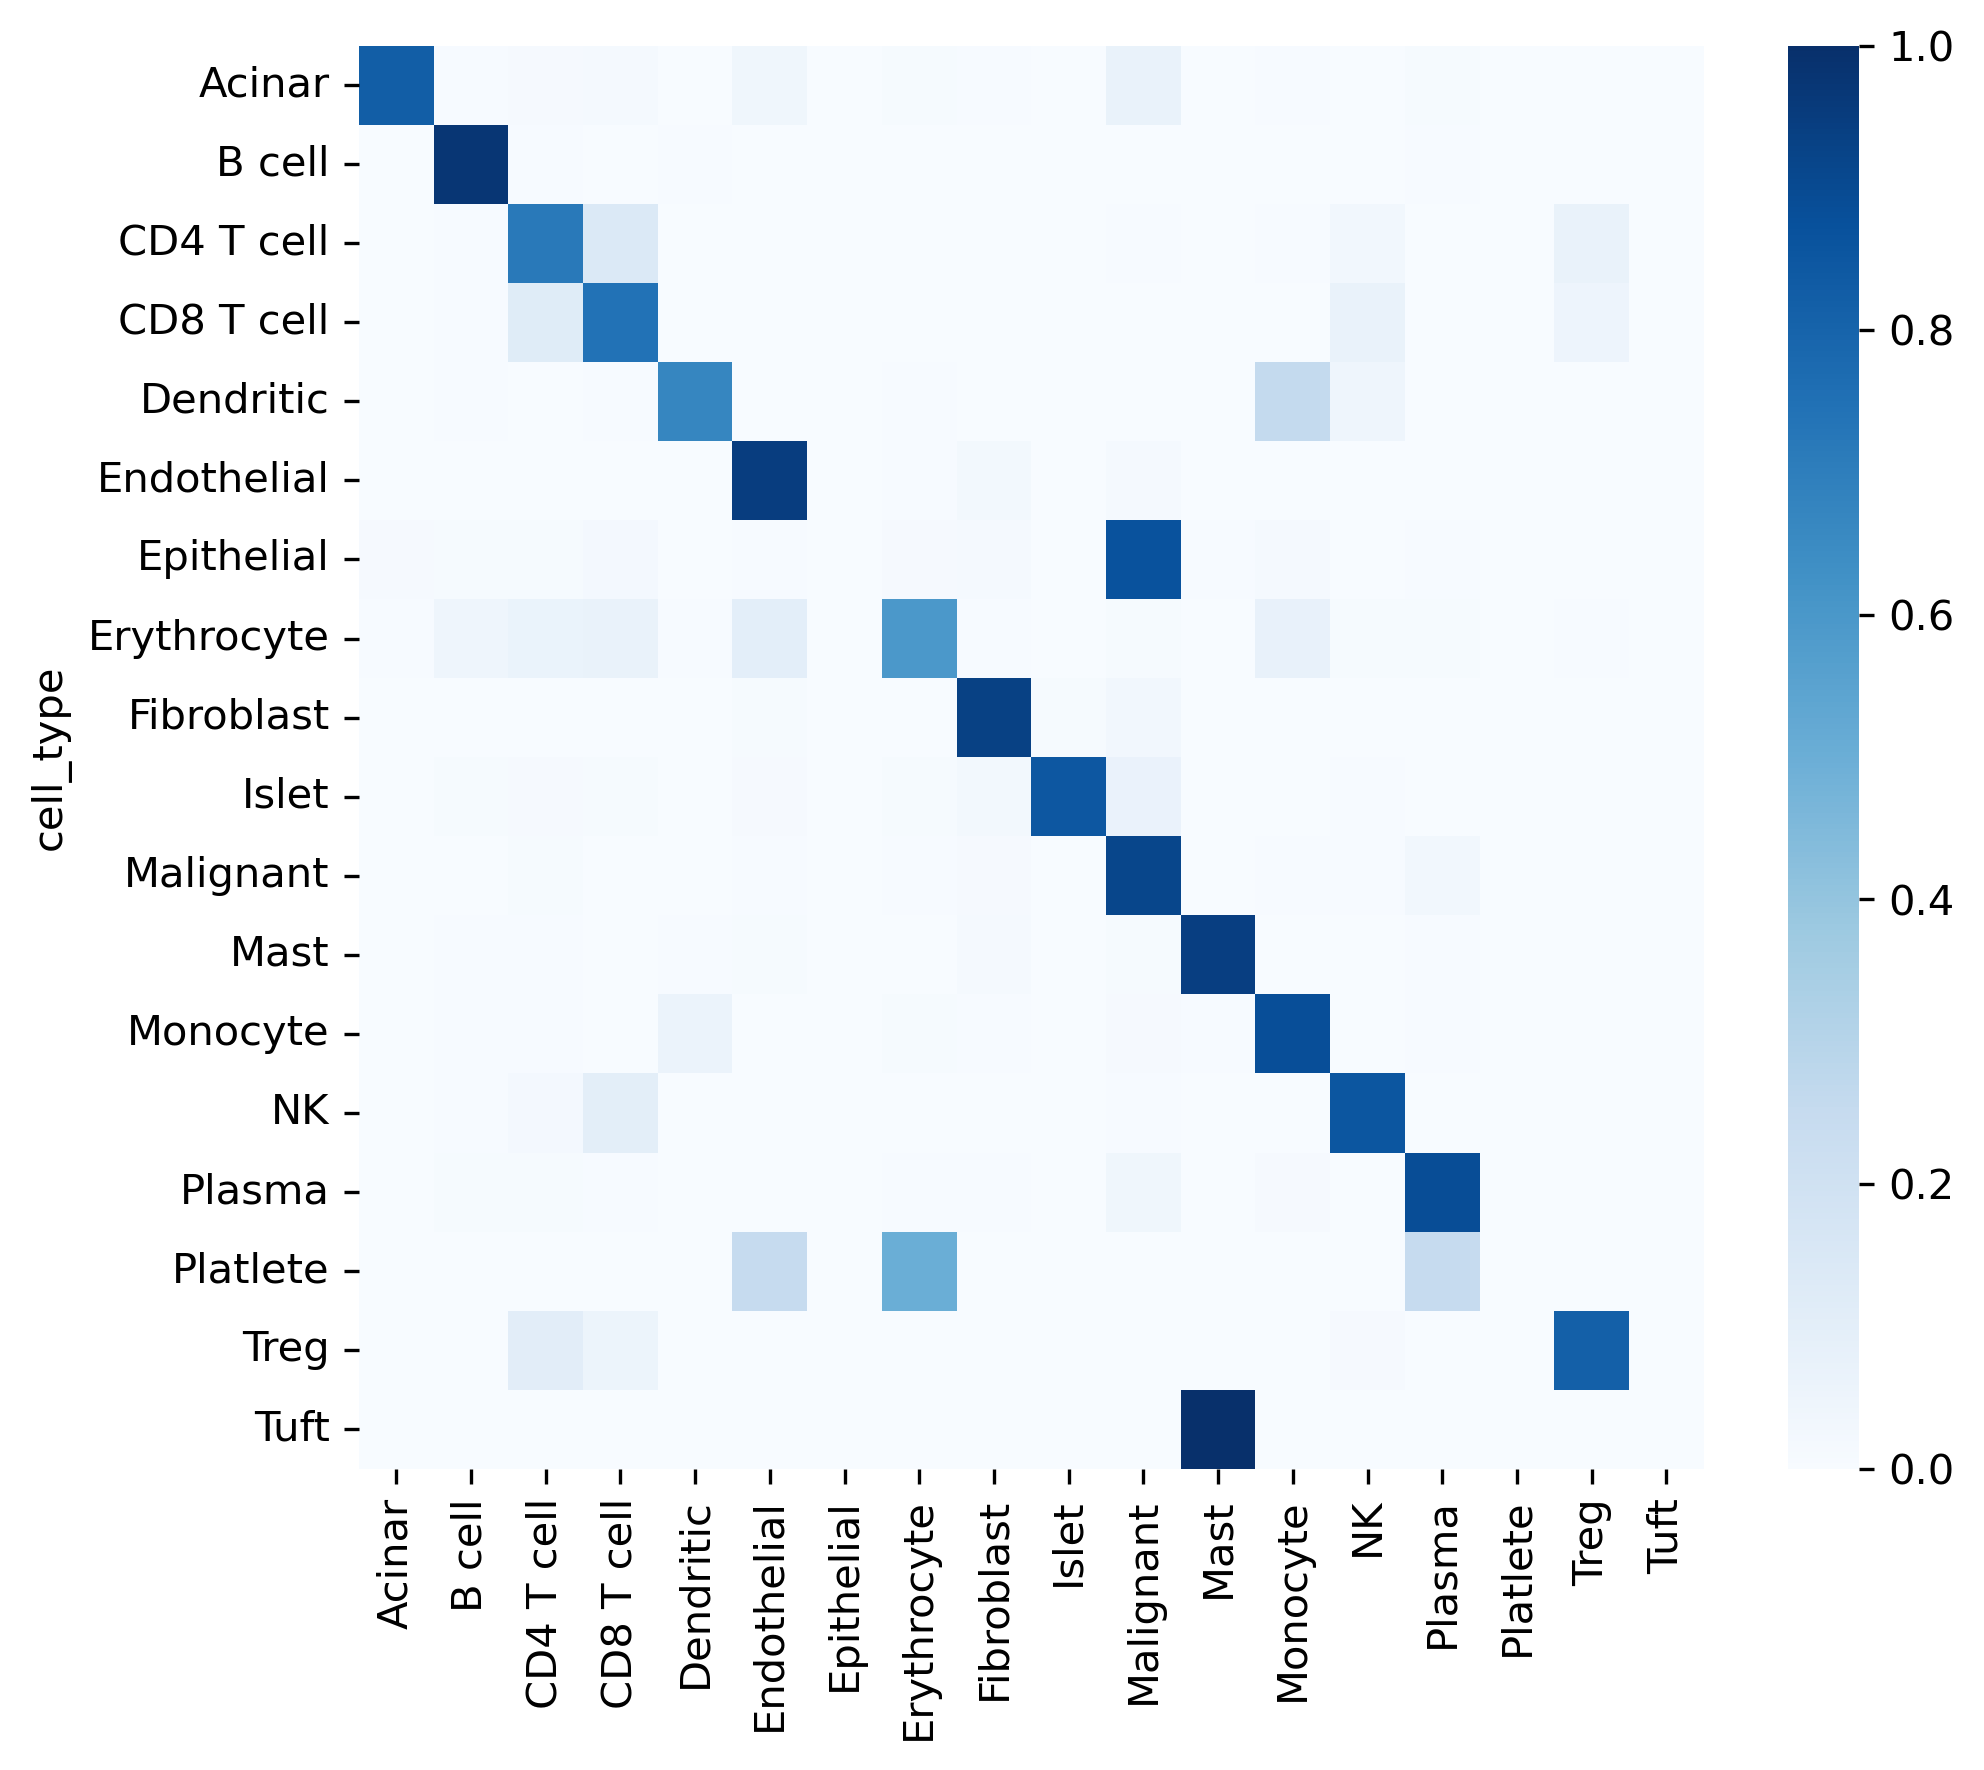

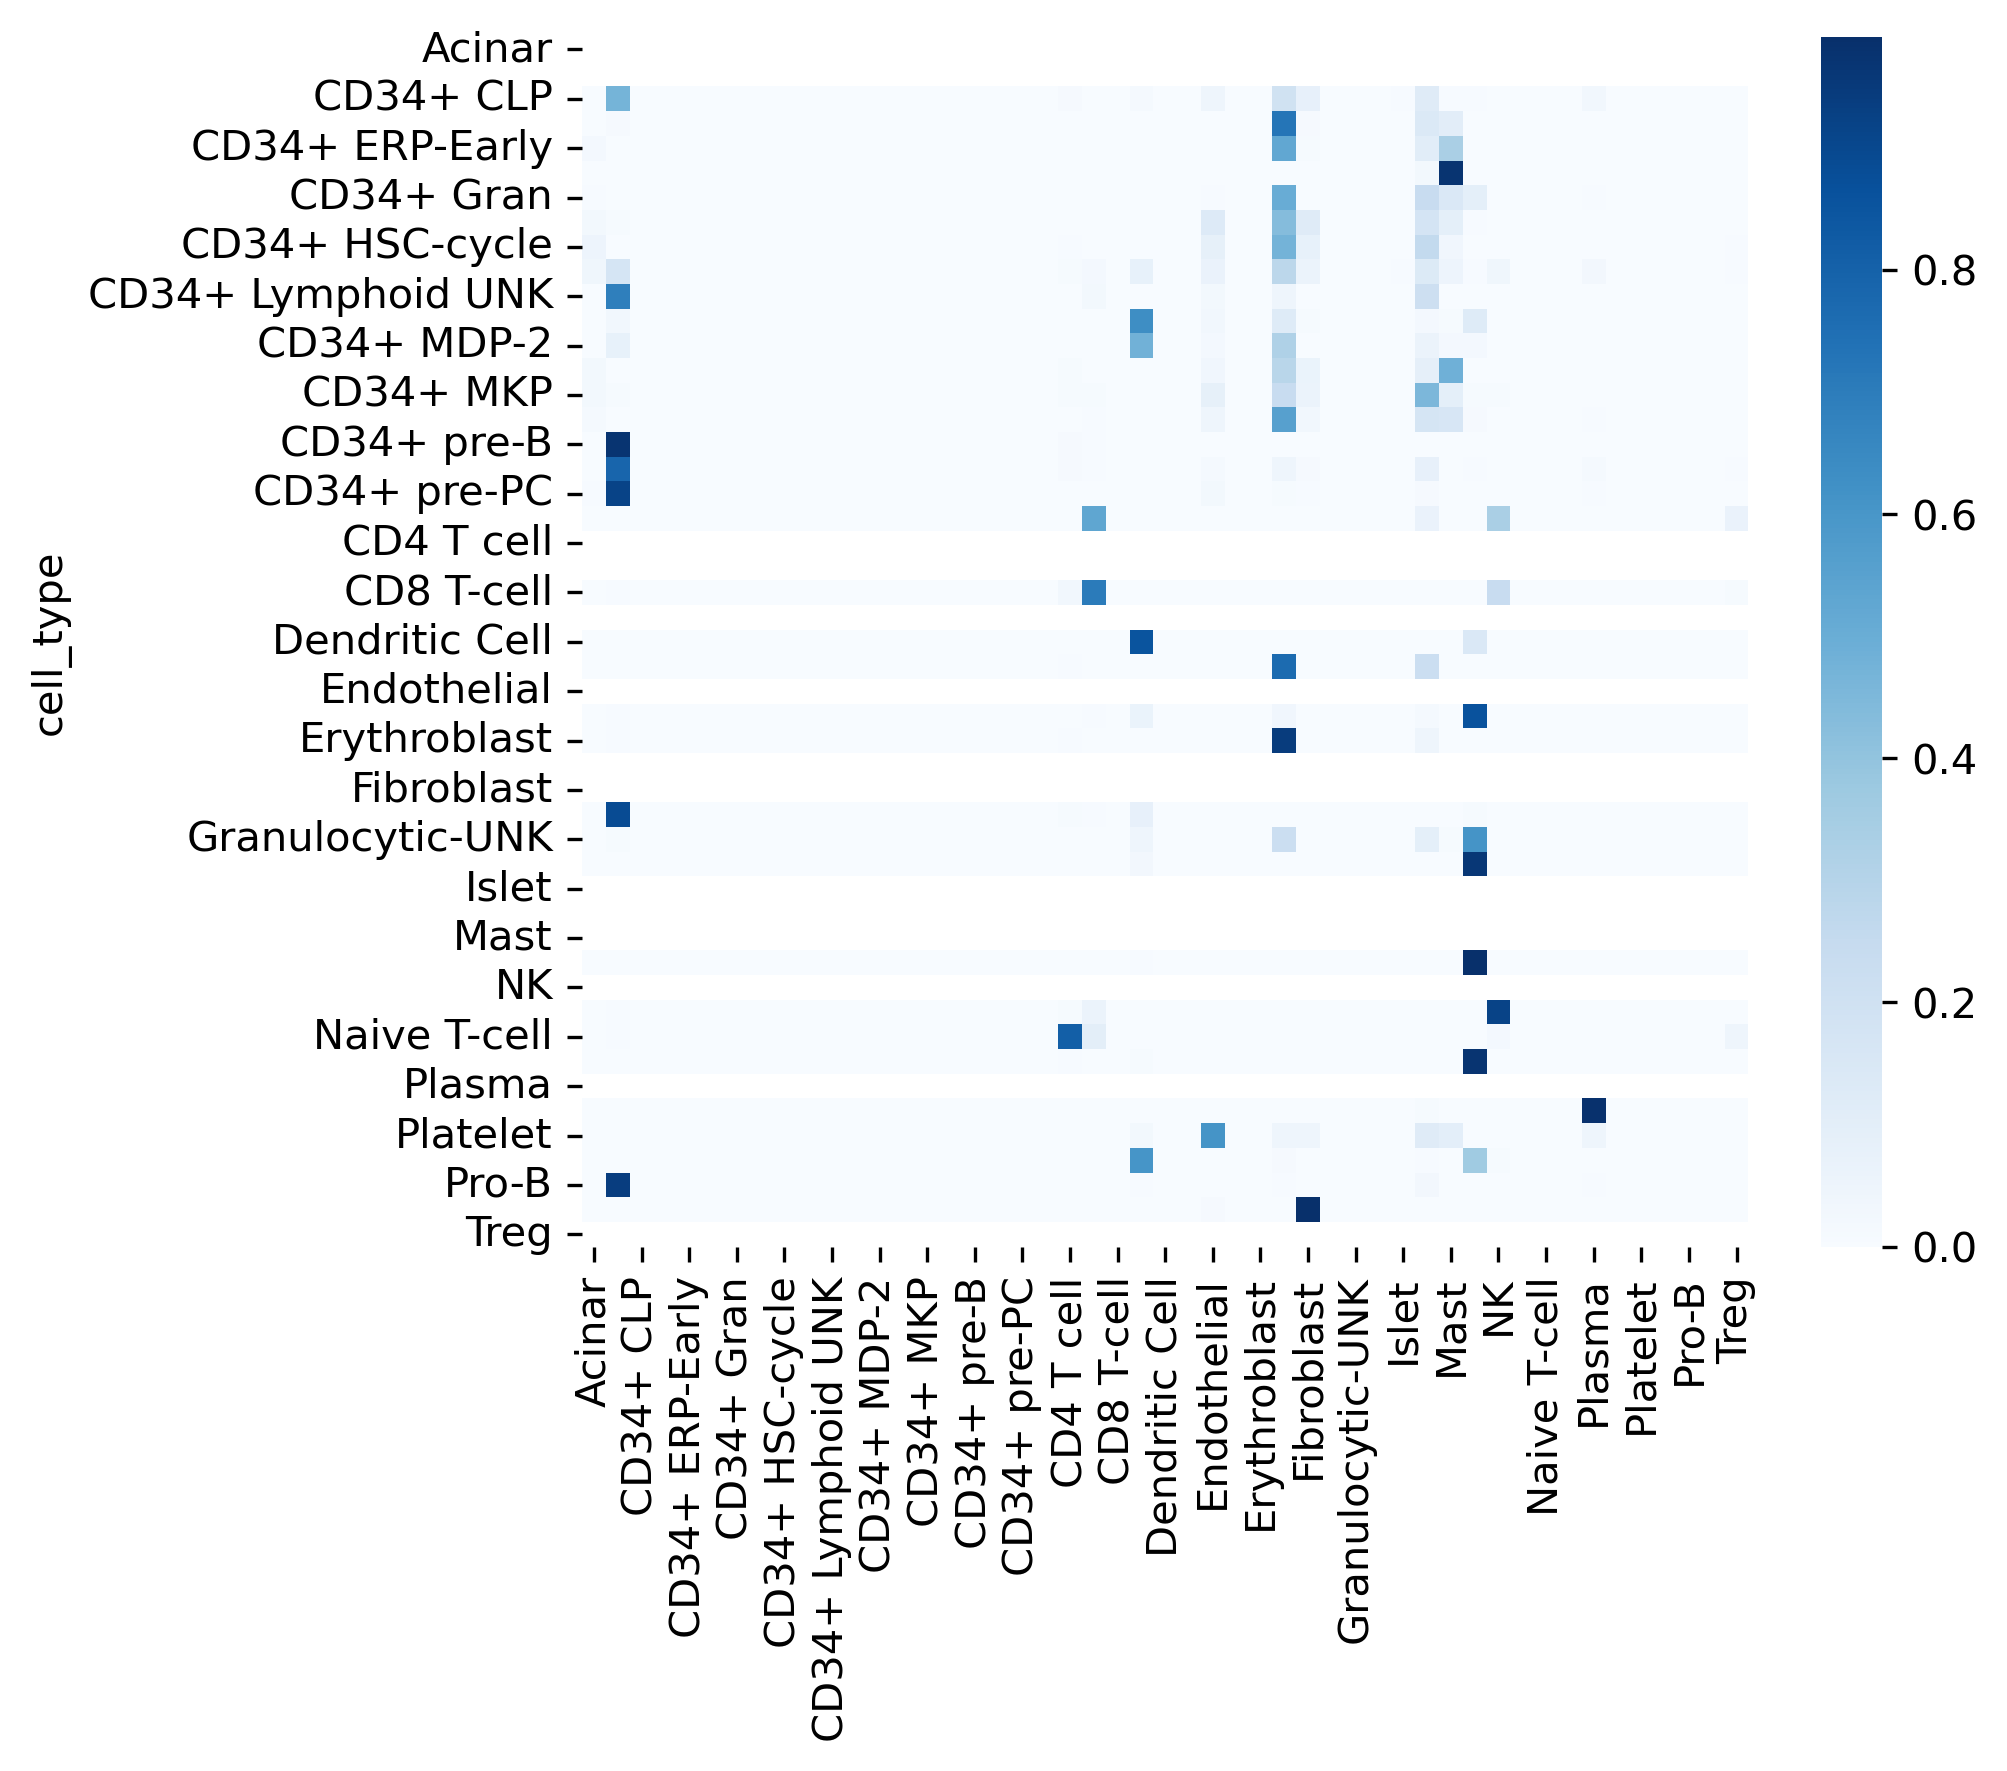

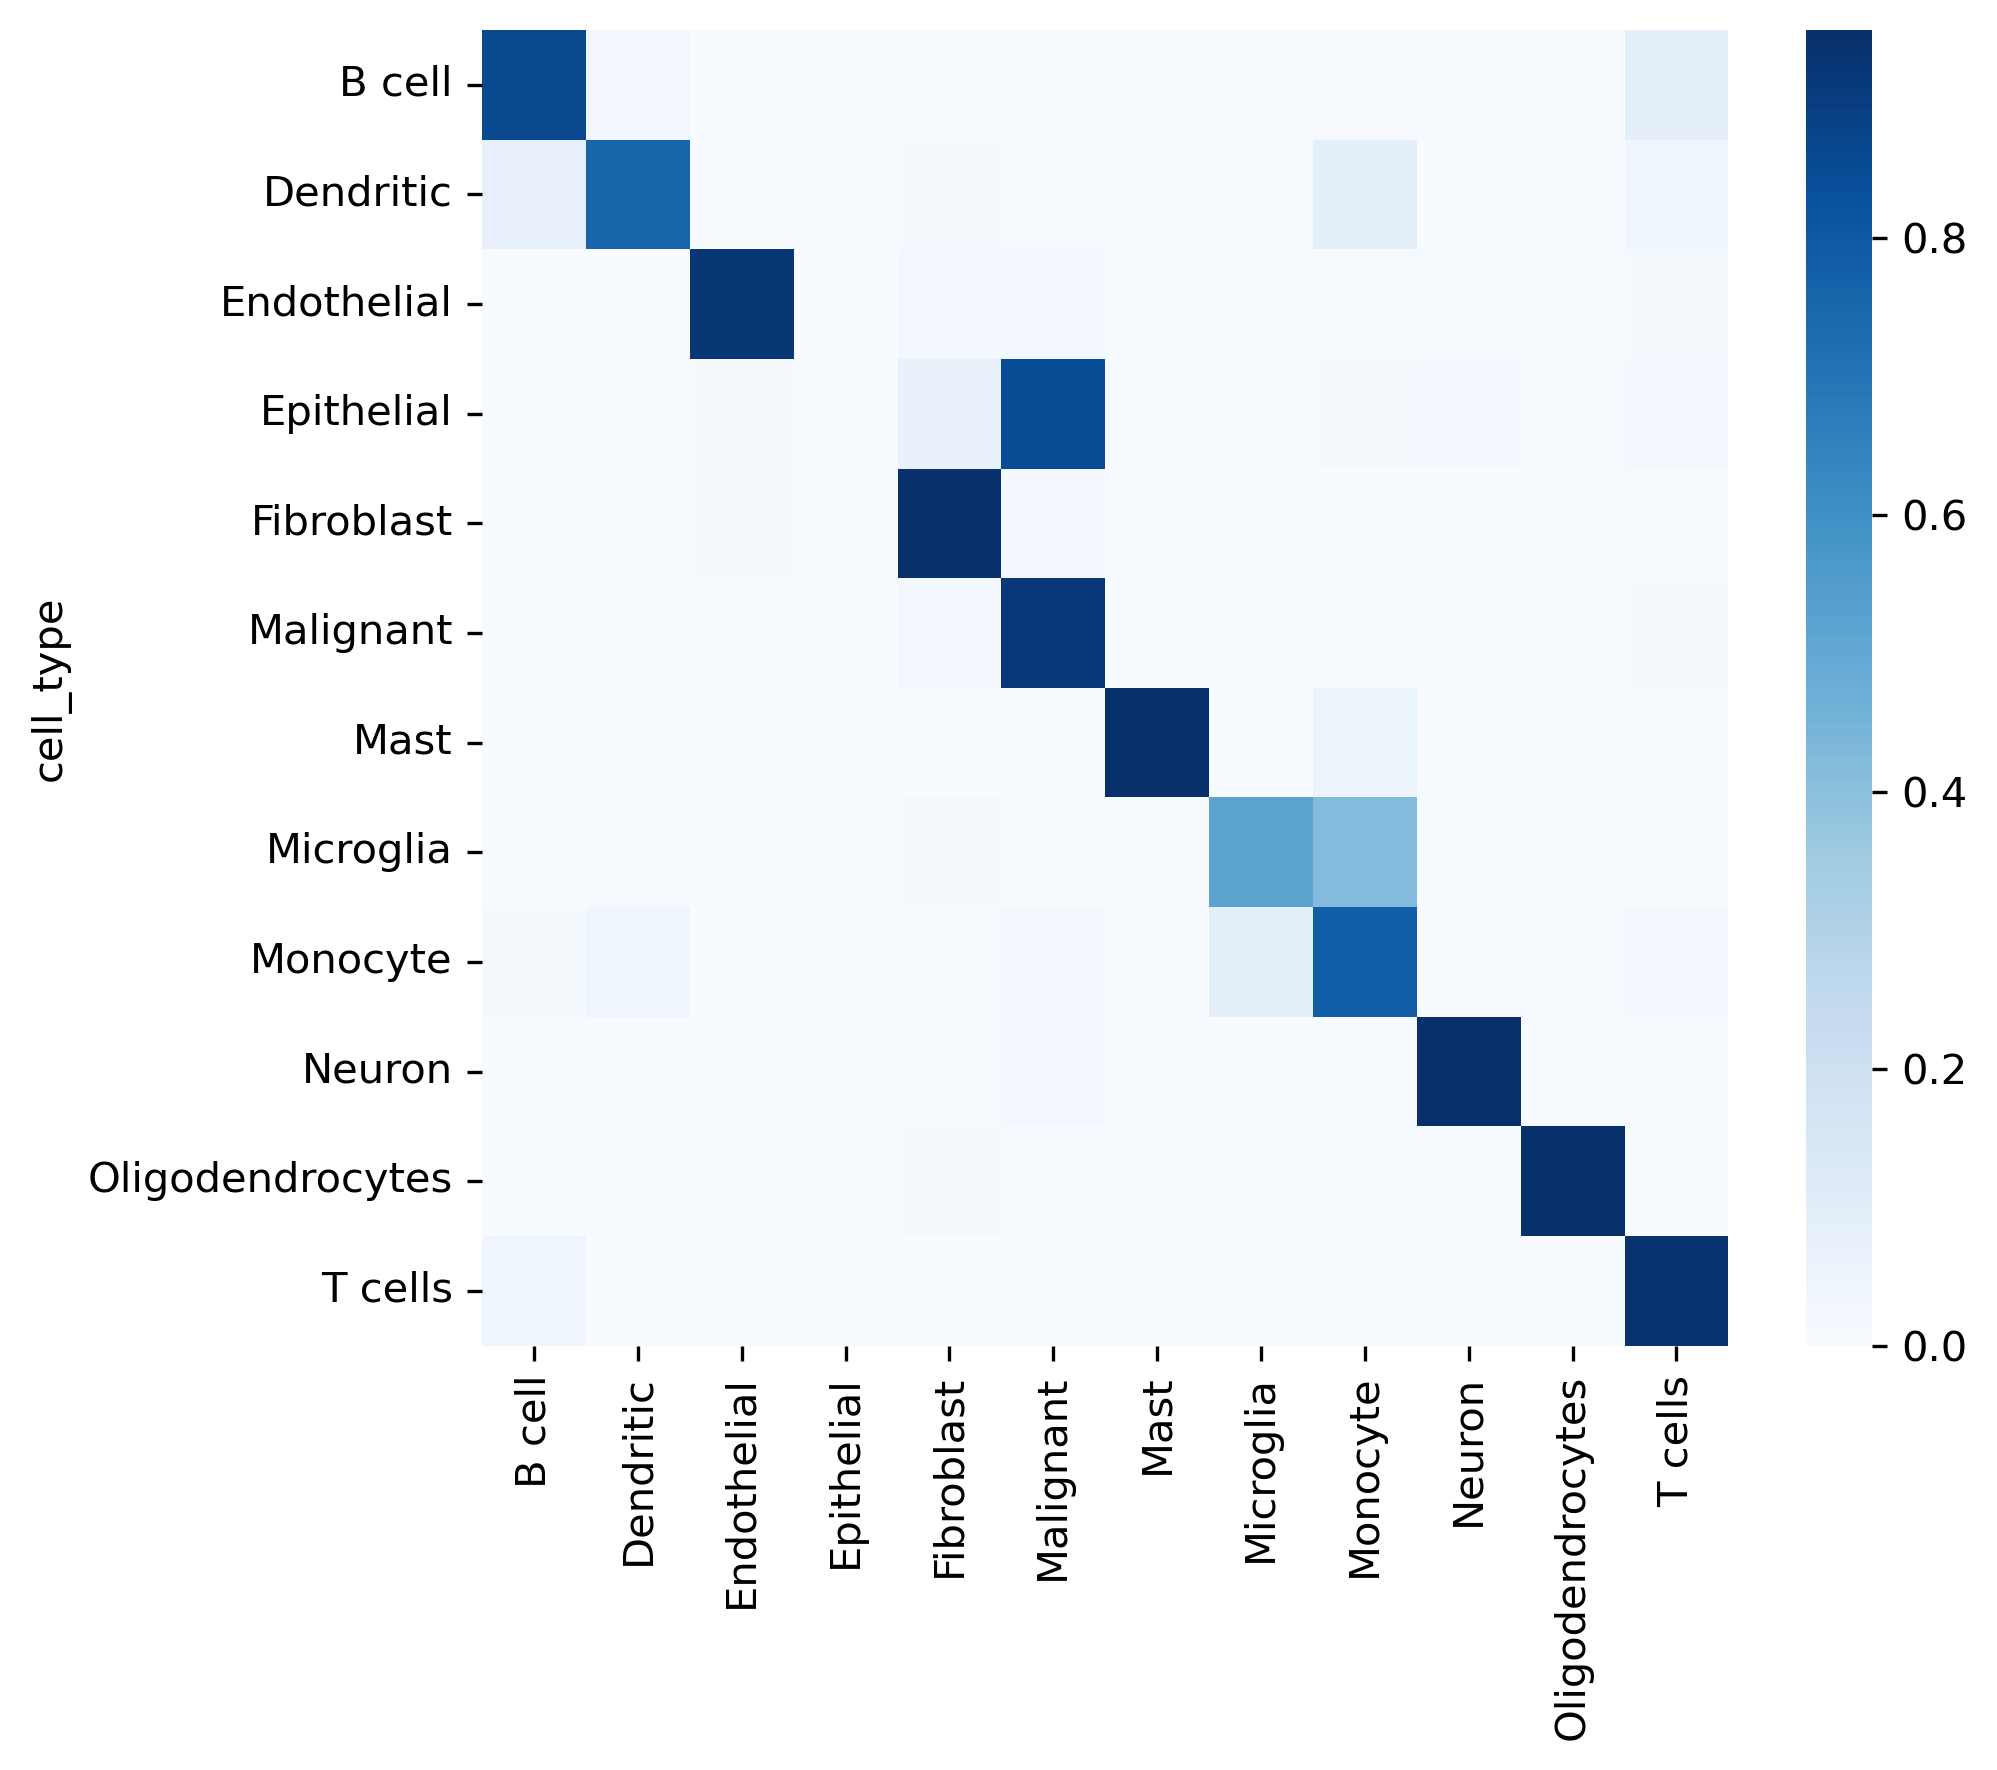

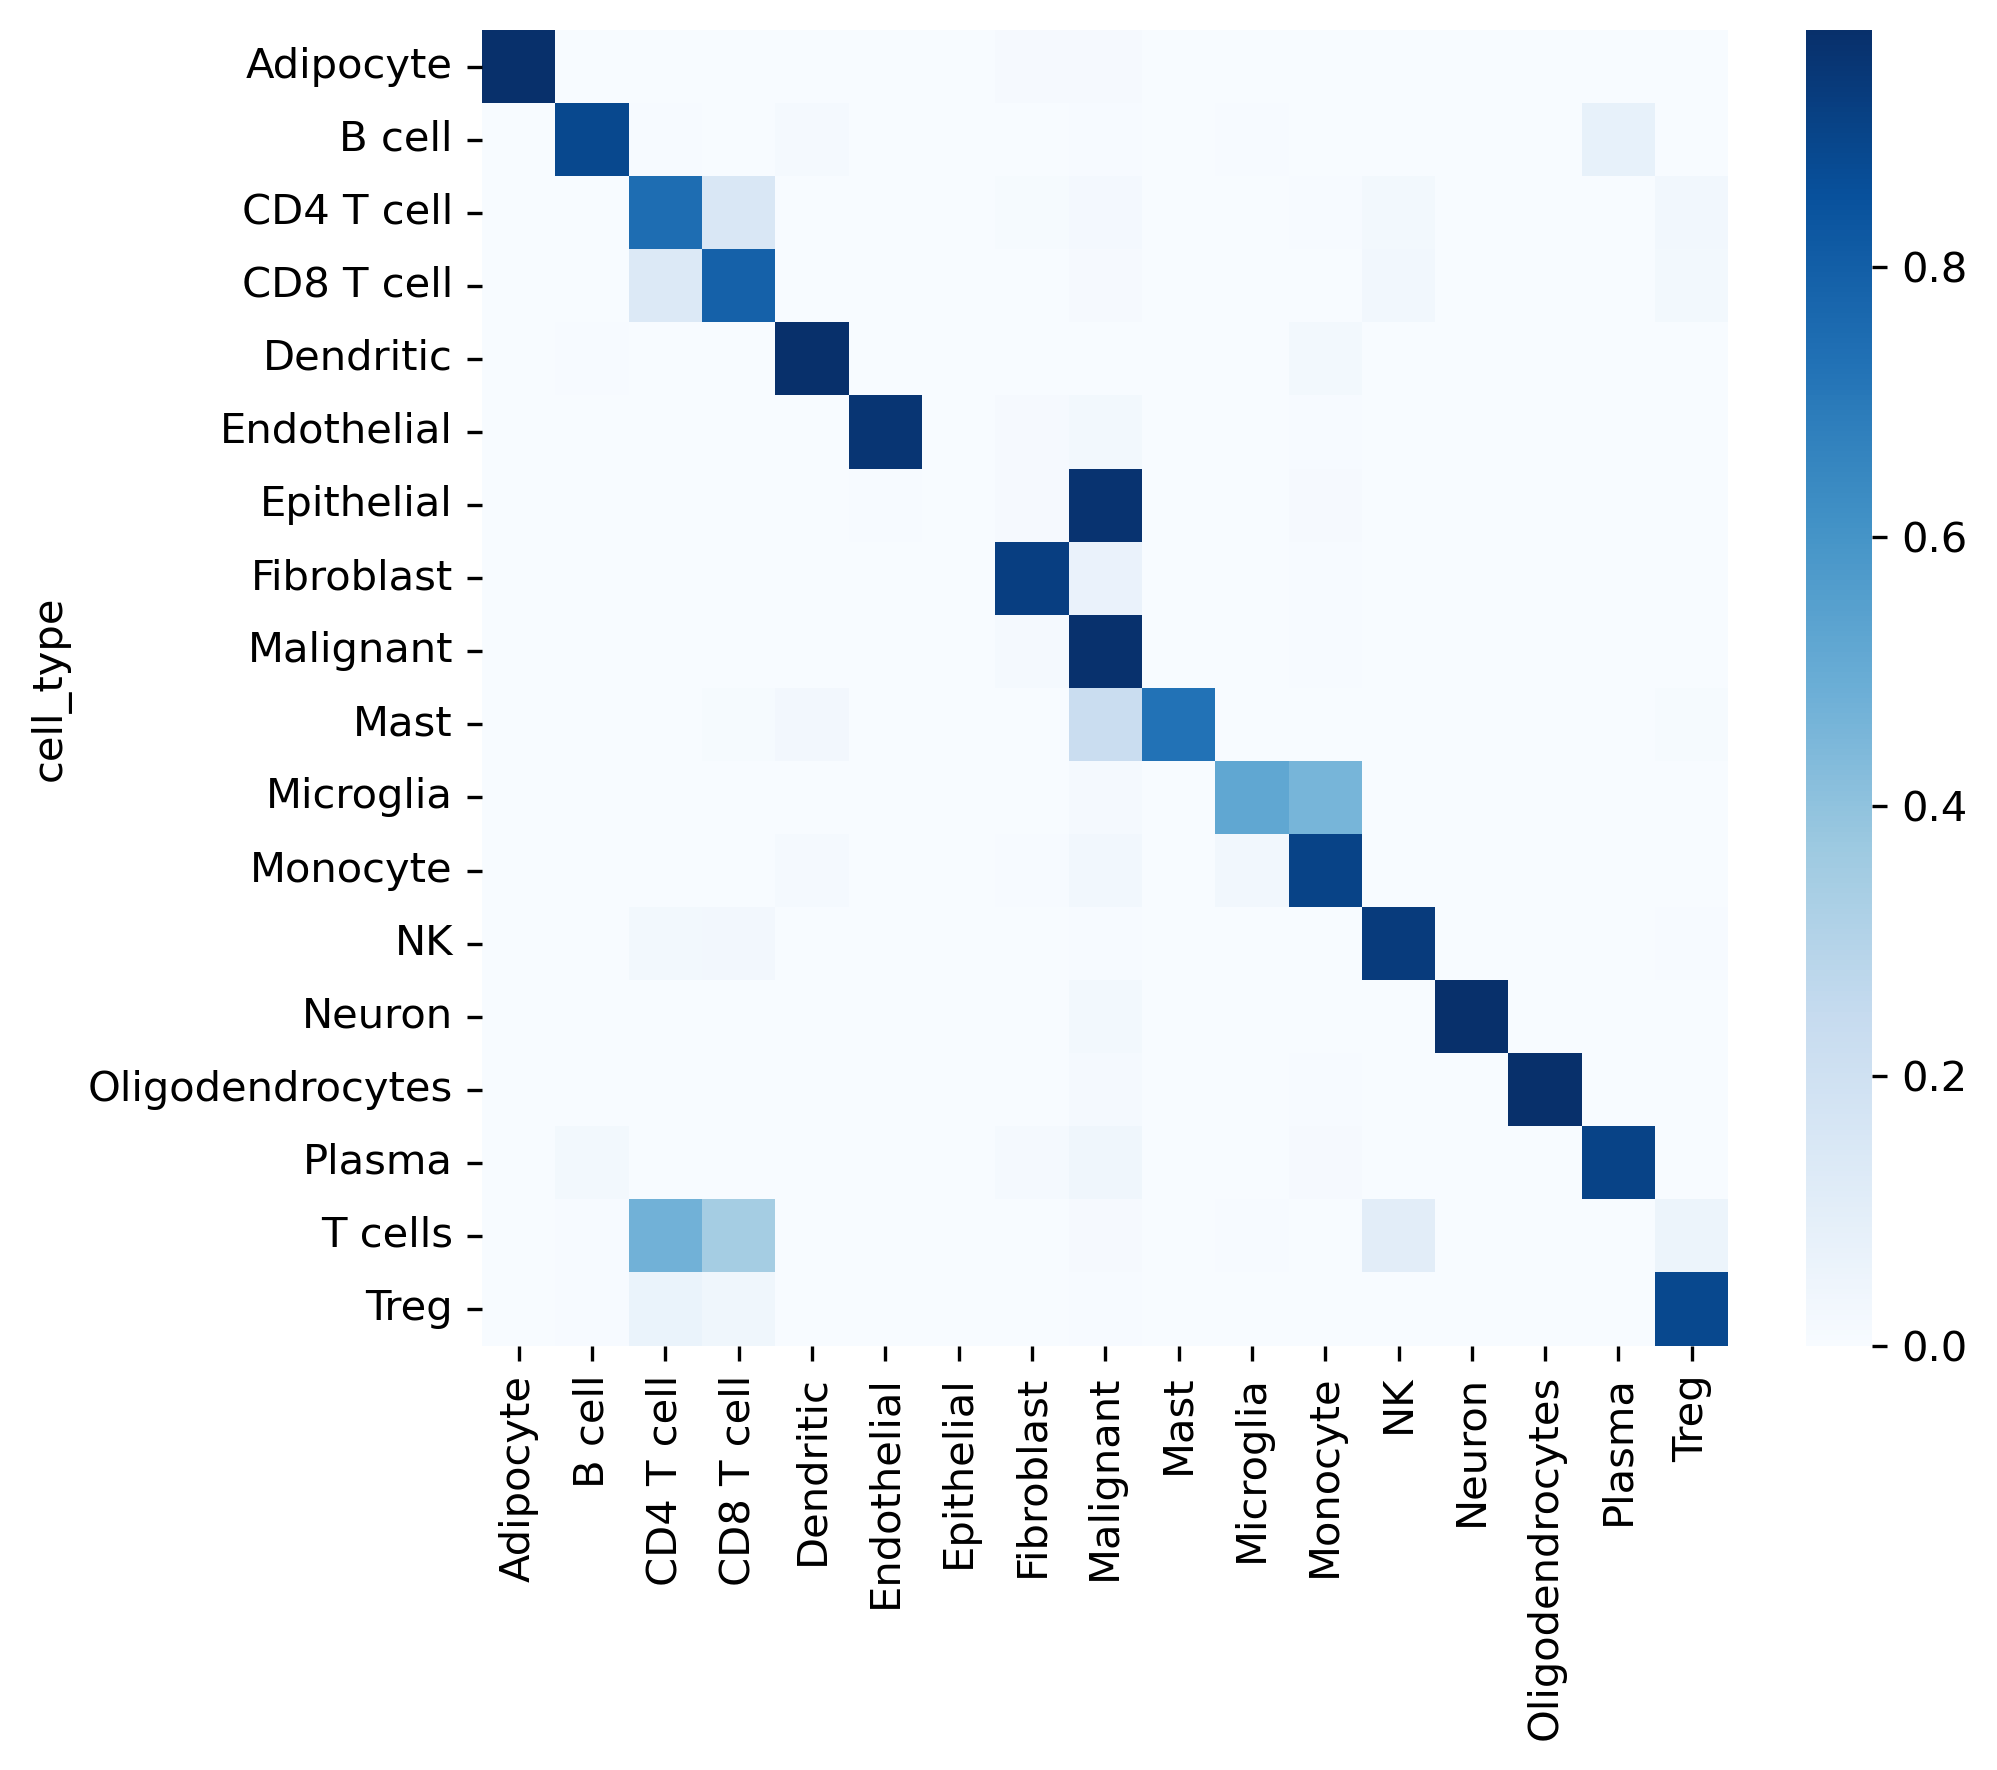

In [284]:
for dtype, df in to_combined.items():
    print(dtype)
    _, cm = get_metrics(df['cell_type'].to_list(),
                df['predicted_cell_type'].to_list(),
                overlapping_only=False)
    
    if dtype == 'snRNAseq':
        # exclude t cells for sn bc confusing to have them in same
        cm = cm.loc[:, [c for c in cm.columns if c!='T cells']]
    
    plot_confusion_matrix(cm, scale_axis=1)
#     plt.show()
    plt.savefig(f'/data/pollock/benchmarking/figures/confusion_matrix_{dtype}.pdf')
    

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

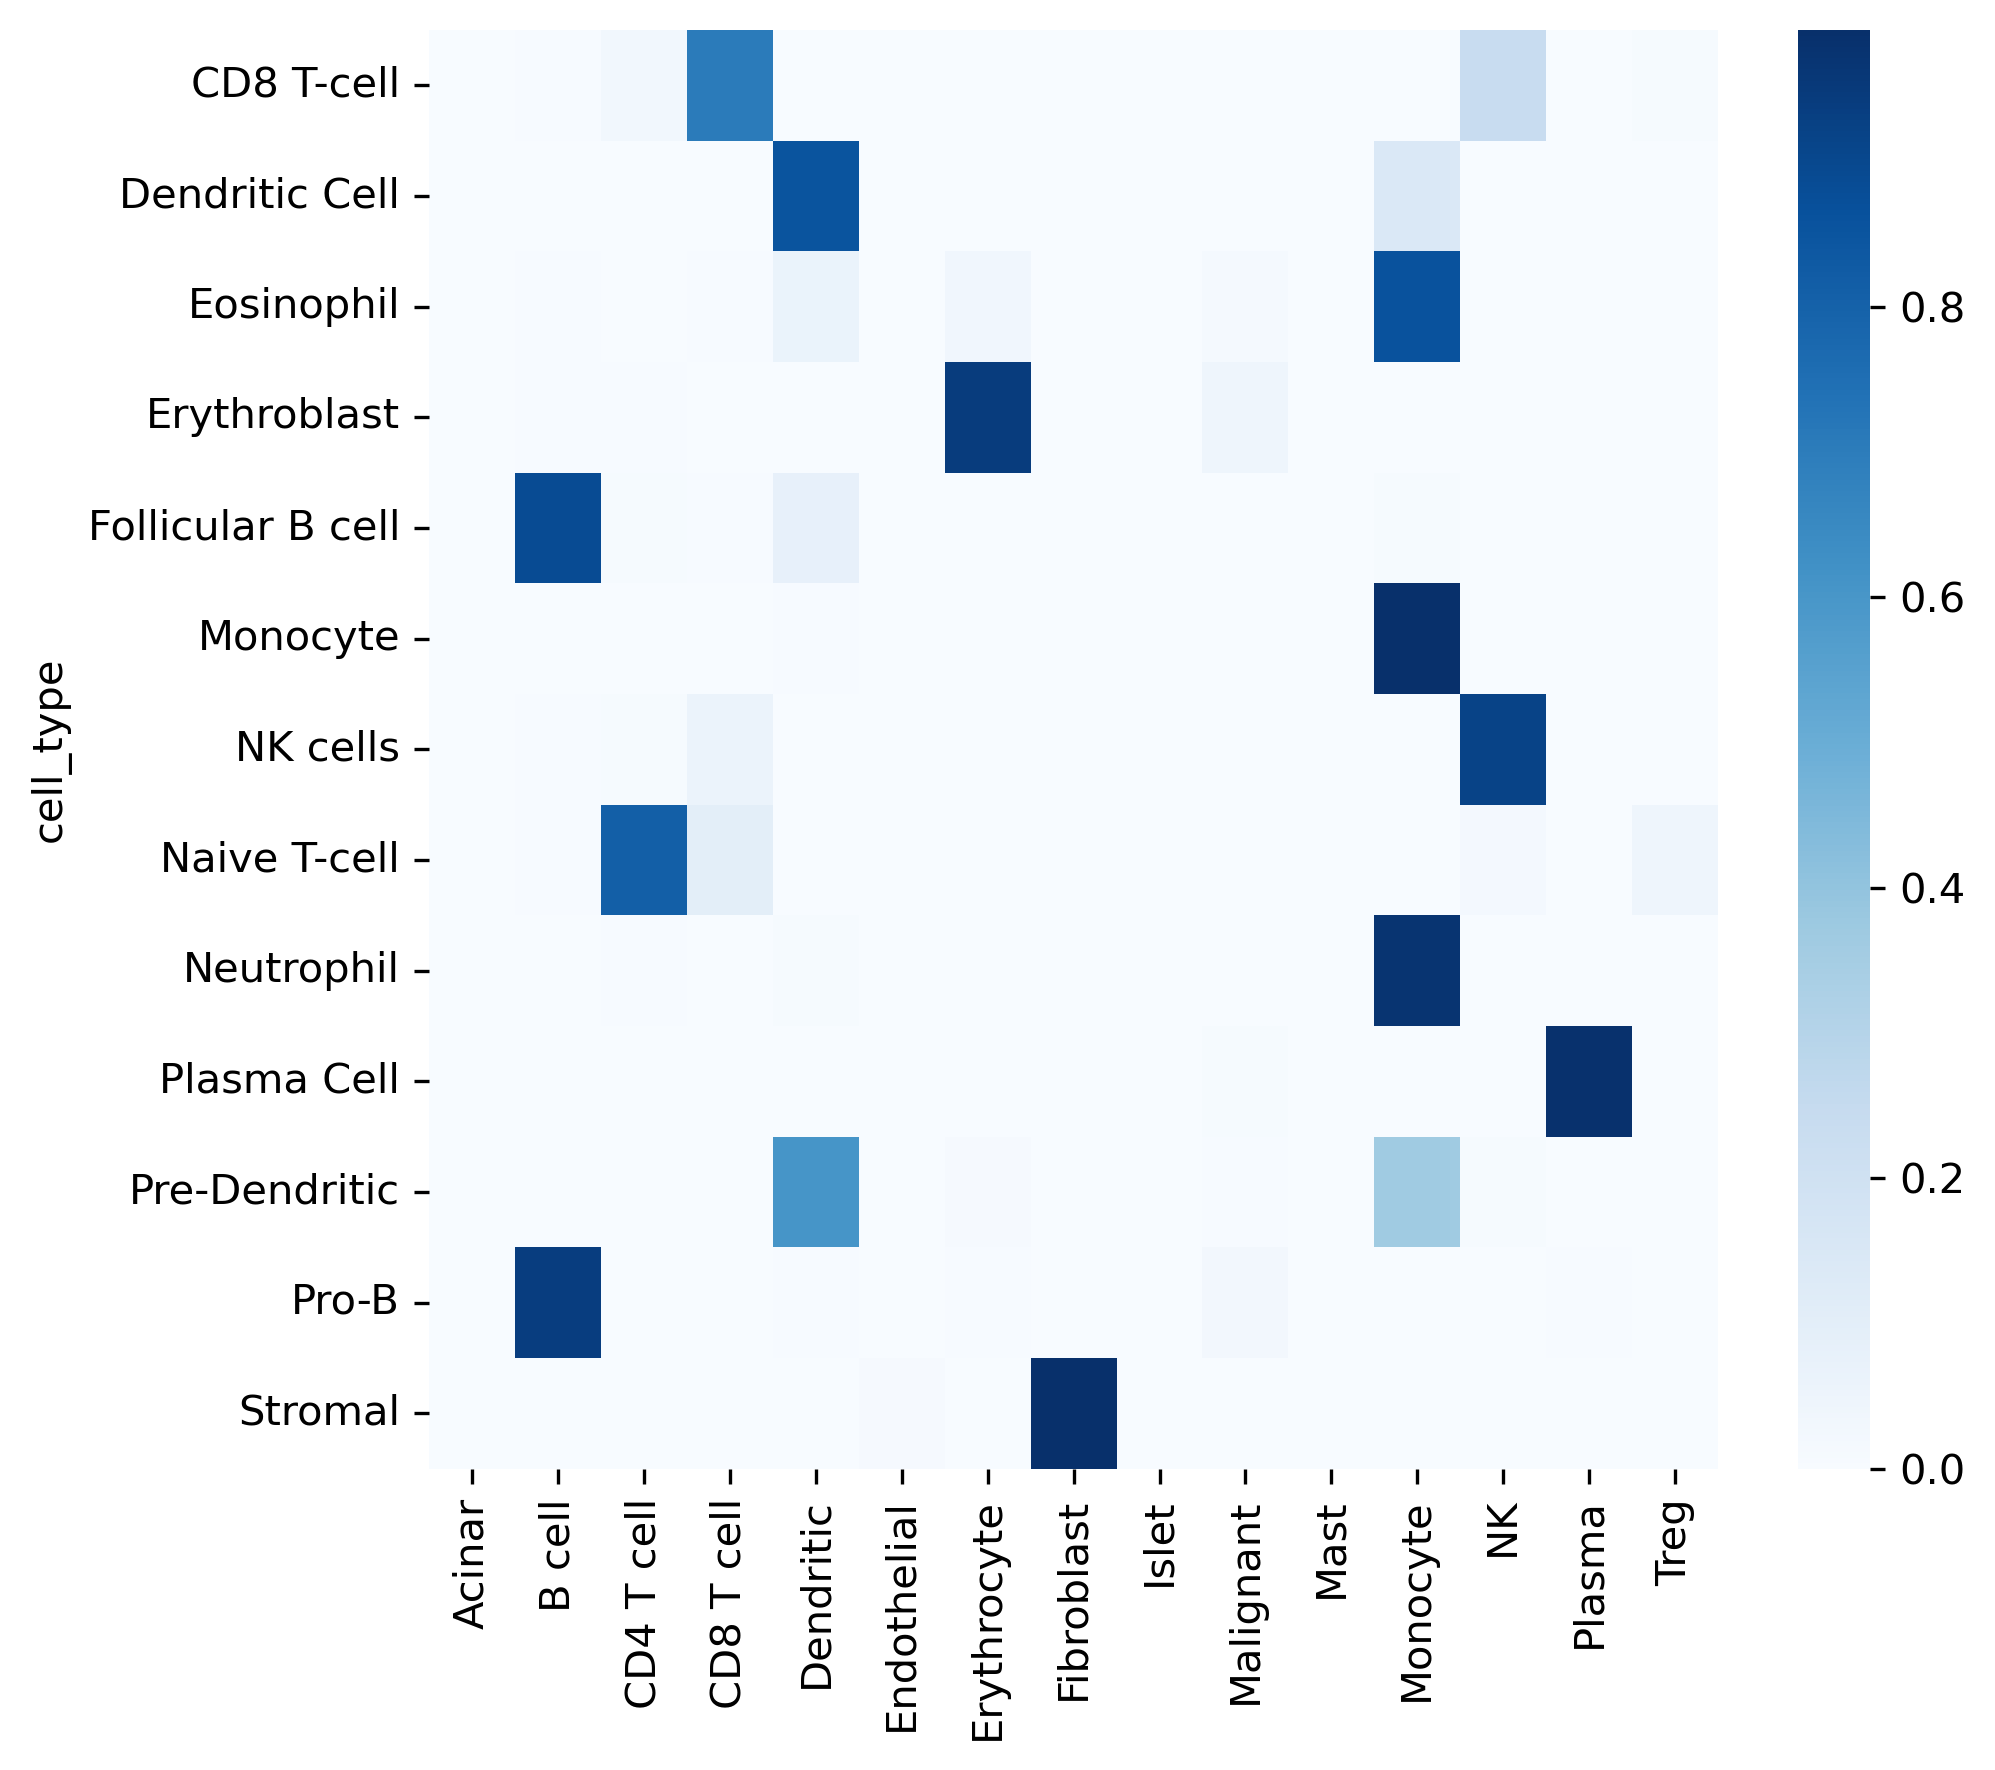

In [286]:
_, cm = get_metrics(to_combined['hca']['cell_type'].to_list(),
                    to_combined['hca']['predicted_cell_type'].to_list(),
                    overlapping_only=False)

predicted_pool = sorted(set(to_combined['hca']['predicted_cell_type']))
true_pool = sorted(set(to_combined['hca']['cell_type']))
true_pool = [c for c in true_pool if 'CD34' not in c]
exclude = ['Early-Erythroblast', 'Platelet', 'Granulocytic-UNK', 'Immature-Neutrophil']
true_pool = [c for c in true_pool if c not in exclude]
cm = cm.loc[true_pool, predicted_pool]
# sort by prevalence
# col_order = np.flip(np.argsort(np.sum(cm.values, axis=0)))
# row_order = np.flip(np.argsort(np.sum(cm.values, axis=1)))
row_order, col_order = np.argsort(cm.index), np.argsort(cm.columns)

cm = cm.iloc[row_order, col_order]
# cm = cm.iloc[:15]
plot_confusion_matrix(cm, scale_axis=1)
plt.savefig(f'/data/pollock/benchmarking/figures/confusion_matrix_hca.pdf')


In [274]:
pd.DataFrame(cm.values / np.expand_dims(np.sum(cm.values, axis=1), axis=-1),
            columns = cm.columns, index=cm.index)

Acinar    B cell  CD4 T cell  CD8 T cell  Dendritic  \
cell_type                                                                  
CD8 T-cell         0.001519  0.006726    0.034715    0.705576   0.000434   
Dendritic Cell     0.000000  0.000558    0.000279    0.000000   0.851842   
Eosinophil         0.000860  0.004299    0.003439    0.004299   0.064488   
Erythroblast       0.000000  0.004308    0.005924    0.001077   0.000000   
Follicular B cell  0.000193  0.888289    0.008103    0.004823   0.083928   
Monocyte           0.000378  0.001133    0.000378    0.000000   0.006045   
NK cells           0.001114  0.005568    0.008018    0.061693   0.003786   
Naive T-cell       0.000493  0.007182    0.808824    0.104289   0.000780   
Neutrophil         0.000450  0.002101    0.005254    0.001351   0.009006   
Plasma Cell        0.000000  0.000577    0.000000    0.000000   0.000000   
Pre-Dendritic      0.000000  0.000000    0.000000    0.000000   0.606635   
Pro-B              0.000758  0.939394    0.000758    0.001515   0.006061   
Stromal            0.000000  0.000000    0.000000    0.000000   0.000000   

                   Endothelial  Erythrocyte  Fibroblast     Islet  Malignant  \
cell_type                                                                      
CD8 T-cell            0.000000     0.000217    0.000000  0.000434   0.000868   
Dendritic Cell        0.000279     0.000837    0.000000  0.000000   0.000279   
Eosinophil            0.001720     0.036973    0.000000  0.000000   0.017197   
Erythroblast          0.000000     0.942380    0.000000  0.000000   0.043619   
Follicular B cell     0.000386     0.000193    0.000000  0.000000   0.000193   
Monocyte              0.000000     0.000378    0.000000  0.000000   0.000378   
NK cells              0.000000     0.000000    0.000000  0.000223   0.000445   
Naive T-cell          0.000082     0.000246    0.000534  0.000575   0.002668   
Neutrophil            0.000751     0.002252    0.000000  0.000150   0.001351   
Plasma Cell           0.000000     0.000577    0.000577  0.000000   0.011541   
Pre-Dendritic         0.000000     0.014218    0.000000  0.000000   0.004739   
Pro-B                 0.003030     0.006818    0.001515  0.000000   0.029545   
Stromal               0.012739     0.000000    0.987261  0.000000   0.000000   

                       Mast  Monocyte        NK    Plasma      Treg  
cell_type                                                            
CD8 T-cell         0.000000  0.000217  0.237796  0.002387  0.009113  
Dendritic Cell     0.000000  0.144531  0.000000  0.001395  0.000000  
Eosinophil         0.003439  0.860705  0.000000  0.001720  0.000860  
Erythroblast       0.000000  0.001616  0.000539  0.000539  0.000000  
Follicular B cell  0.000193  0.007910  0.003859  0.001351  0.000579  
Monocyte           0.000378  0.990555  0.000000  0.000378  0.000000  
NK cells           0.000445  0.000000  0.917817  0.000445  0.000445  
Naive T-cell       0.000944  0.000451  0.022081  0.002052  0.048800  
Neutrophil         0.000450  0.973582  0.001051  0.001501  0.000751  
Plasma Cell        0.000000  0.000000  0.000577  0.986151  0.000000  
Pre-Dendritic      0.000000  0.364929  0.009479  0.000000  0.000000  
Pro-B              0.000758  0.003788  0.000758  0.005303  0.000000  
Stromal            0.000000  0.000000  0.000000  0.000000  0.000000

In [265]:
cm

Acinar  B cell  CD4 T cell  CD8 T cell  Dendritic  \
cell_type                                                              
CD8 T-cell              7      31         160        3252          2   
Dendritic Cell          0       2           1           0       3053   
Eosinophil              1       5           4           5         75   
Erythroblast            0       8          11           2          0   
Follicular B cell       1    4604          42          25        435   
Monocyte                1       3           1           0         16   
NK cells                5      25          36         277         17   
Naive T-cell           12     175       19707        2541         19   
Neutrophil              3      14          35           9         60   
Plasma Cell             0       1           0           0          0   
Pre-Dendritic           0       0           0           0        128   
Pro-B                   1    1240           1           2          8   
Stromal                 0       0           0           0          0   

                   Endothelial  Erythrocyte  Fibroblast  Islet  Malignant  \
cell_type                                                                   
CD8 T-cell                   0            1           0      2          4   
Dendritic Cell               1            3           0      0          1   
Eosinophil                   2           43           0      0         20   
Erythroblast                 0         1750           0      0         81   
Follicular B cell            2            1           0      0          1   
Monocyte                     0            1           0      0          1   
NK cells                     0            0           0      1          2   
Naive T-cell                 2            6          13     14         65   
Neutrophil                   5           15           0      1          9   
Plasma Cell                  0            1           1      0         20   
Pre-Dendritic                0            3           0      0          1   
Pro-B                        4            9           2      0         39   
Stromal                      2            0         155      0          0   

                   Mast  Monocyte    NK  Plasma  Treg  
cell_type                                              
CD8 T-cell            0         1  1096      11    42  
Dendritic Cell        0       518     0       5     0  
Eosinophil            4      1001     0       2     1  
Erythroblast          0         3     1       1     0  
Follicular B cell     1        41    20       7     3  
Monocyte              1      2622     0       1     0  
NK cells              2         0  4121       2     2  
Naive T-cell         23        11   538      50  1189  
Neutrophil            3      6486     7      10     5  
Plasma Cell           0         0     1    1709     0  
Pre-Dendritic         0        77     2       0     0  
Pro-B                 1         5     1       7     0  
Stromal               0         0     0       0     0

In [71]:
to_combined['hca']

cell_type  \
MantonBM7_HiSeq_6-GCATGCGCATCTGGTA-1.BM7       Naive T-cell   
MantonBM3_HiSeq_3-AGAATAGGTCGACTAT-1.BM3       Naive T-cell   
MantonBM1_HiSeq_1-AGGGTGAGTTATTCTC-1.BM1  Follicular B cell   
MantonBM3_HiSeq_3-TTTGCGCGTACCGCTG-1.BM3       Naive T-cell   
MantonBM3_HiSeq_3-TACTCGCGTTGACGTT-1.BM3         Eosinophil   
...                                                     ...   
MantonBM4_HiSeq_2-CCTCTGAAGATGCCTT-1.BM4          CD34+ HSC   
MantonBM2_HiSeq_2-TTGTAGGAGGTCGGAT-1.BM2       Erythroblast   
MantonBM6_HiSeq_1-CCTACCACAGCCTTTC-1.BM6         CD34+ LMPP   
MantonBM6_HiSeq_2-TGGTTAGTCAGCGACC-1.BM6       Naive T-cell   
MantonBM6_HiSeq_2-CGGTTAATCCTGCTTG-1.BM6       Naive T-cell   

                                         predicted_cell_type disease  
MantonBM7_HiSeq_6-GCATGCGCATCTGGTA-1.BM7          CD4 T cell     hca  
MantonBM3_HiSeq_3-AGAATAGGTCGACTAT-1.BM3          CD4 T cell     hca  
MantonBM1_HiSeq_1-AGGGTGAGTTATTCTC-1.BM1              B cell     hca  
MantonBM3_HiSeq_3-TTTGCGCGTACCGCTG-1.BM3          CD8 T cell     hca  
MantonBM3_HiSeq_3-TACTCGCGTTGACGTT-1.BM3            Monocyte     hca  
...                                                      ...     ...  
MantonBM4_HiSeq_2-CCTCTGAAGATGCCTT-1.BM4                Mast     hca  
MantonBM2_HiSeq_2-TTGTAGGAGGTCGGAT-1.BM2         Erythrocyte     hca  
MantonBM6_HiSeq_1-CCTACCACAGCCTTTC-1.BM6          Fibroblast     hca  
MantonBM6_HiSeq_2-TGGTTAGTCAGCGACC-1.BM6          CD4 T cell     hca  
MantonBM6_HiSeq_2-CGGTTAATCCTGCTTG-1.BM6          CD4 T cell     hca  

[69421 rows x 3 columns]

In [80]:
a = sc.read_h5ad('/data/pollock/benchmarking/pollock_datasets/snATACseq/ccrcc_gene_activity.h5ad')
a

AnnData object with n_obs × n_vars = 79852 × 19843
    obs: 'cell_type', 'barcode', 'sample'

In [81]:
set(a.obs['cell_type'])

{'Endothelial', 'Epithelial', 'Fibroblast', 'Malignant', 'Monocyte', 'T cells'}

dropout

In [287]:
dropout_results_dir = '/data/pollock/benchmarking/results/pollock/dropout/'
fps = sorted(listfiles(dropout_results_dir, regex=r'clf_report.txt$'))
drop_to_results = {}
for fp in fps:
    root = fp.split('/')[-1].split('_clf_report')[0]
    disease, dropout = root.split('_')
    

    if disease not in drop_to_results:
        drop_to_results[disease] = {}
    
    drop_to_results[disease][dropout] = pd.read_csv(fp, sep='\t', index_col=0)
    
drop_to_results['brca']['0.20']

B cell  CD4 T cell  CD8 T cell   Dendritic  Endothelial  \
metric                                                                   
precision    0.986166    0.749027    0.754980    0.927536     0.911417   
recall       0.998000    0.770000    0.758000    0.941176     0.926000   
f1-score     0.992048    0.759369    0.756487    0.934307     0.918651   
support    500.000000  500.000000  500.000000  272.000000   500.000000   

           Erythrocyte  Fibroblast   Malignant        Mast    Monocyte  \
metric                                                                   
precision     0.909091    0.920233    0.867735    0.987654    0.859756   
recall        0.782609    0.946000    0.866000    0.975610    0.846000   
f1-score      0.841121    0.932939    0.866867    0.981595    0.852823   
support     230.000000  500.000000  500.000000  246.000000  500.000000   

                   NK      Plasma        Treg  accuracy    macro avg  \
metric                                                                 
precision    0.934874    0.882353    0.845098  0.879784     0.887379   
recall       0.890000    0.900000    0.862000  0.879784     0.881646   
f1-score     0.911885    0.891089    0.853465  0.879784     0.884050   
support    500.000000  500.000000  500.000000  0.879784  5748.000000   

           weighted avg  
metric                   
precision      0.880335  
recall         0.879784  
f1-score       0.879762  
support     5748.000000

In [288]:
data = []
for disease in drop_to_results.keys():
    for dropout in drop_to_results['brca'].keys():
        df = drop_to_results[disease][dropout]
        data.append([disease, dropout, df.loc['f1-score', 'macro avg']])
dropout_df = pd.DataFrame(data=data, columns=['disease', 'dropout rate', 'f1-score'])
dropout_df = dropout_df[dropout_df['dropout rate']!='0.95']
dropout_df

disease dropout rate  f1-score
0       brca         0.00  0.891635
1       brca         0.20  0.884050
2       brca         0.40  0.868690
3       brca         0.60  0.857758
4       brca         0.80  0.797129
5       brca         0.90  0.706449
7       cesc         0.00  0.952926
8       cesc         0.20  0.948842
9       cesc         0.40  0.947936
10      cesc         0.60  0.935126
11      cesc         0.80  0.901751
12      cesc         0.90  0.840391
14     hnscc         0.00  0.883052
15     hnscc         0.20  0.882411
16     hnscc         0.40  0.868253
17     hnscc         0.60  0.851443
18     hnscc         0.80  0.812700
19     hnscc         0.90  0.737359
21  melanoma         0.00  0.947998
22  melanoma         0.20  0.944276
23  melanoma         0.40  0.941183
24  melanoma         0.60  0.931508
25  melanoma         0.80  0.879790
26  melanoma         0.90  0.795491
28   myeloma         0.00  0.831050
29   myeloma         0.20  0.841677
30   myeloma         0.40  0.804463
31   myeloma         0.60  0.819712
32   myeloma         0.80  0.755037
33   myeloma         0.90  0.638655
35      pdac         0.00  0.852397
36      pdac         0.20  0.844541
37      pdac         0.40  0.837173
38      pdac         0.60  0.809457
39      pdac         0.80  0.738738
40      pdac         0.90  0.642610

2022-01-20 11:38:44,239 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-20 11:38:44,245 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-20 11:38:44,375 maxp pruned
2022-01-20 11:38:44,391 cmap pruned
2022-01-20 11:38:44,392 kern dropped
2022-01-20 11:38:44,393 post pruned
2022-01-20 11:38:44,394 FFTM dropped
2022-01-20 11:38:44,399 GPOS pruned
2022-01-20 11:38:44,405 GSUB pruned
2022-01-20 11:38:44,407 name pruned
2022-01-20 11:38:44,417 glyf pruned
2022-01-20 11:38:44,419 Added gid0 to subset
2022-01-20 11:38:44,420 Added first four glyphs to subset
2022-01-20 11:38:44,421 Closing glyph list over 'GSUB': 32 glyphs before
2022-01-20 11:38:44,421 Glyph names: ['.notdef', '.null', 'a', 'b', 'c

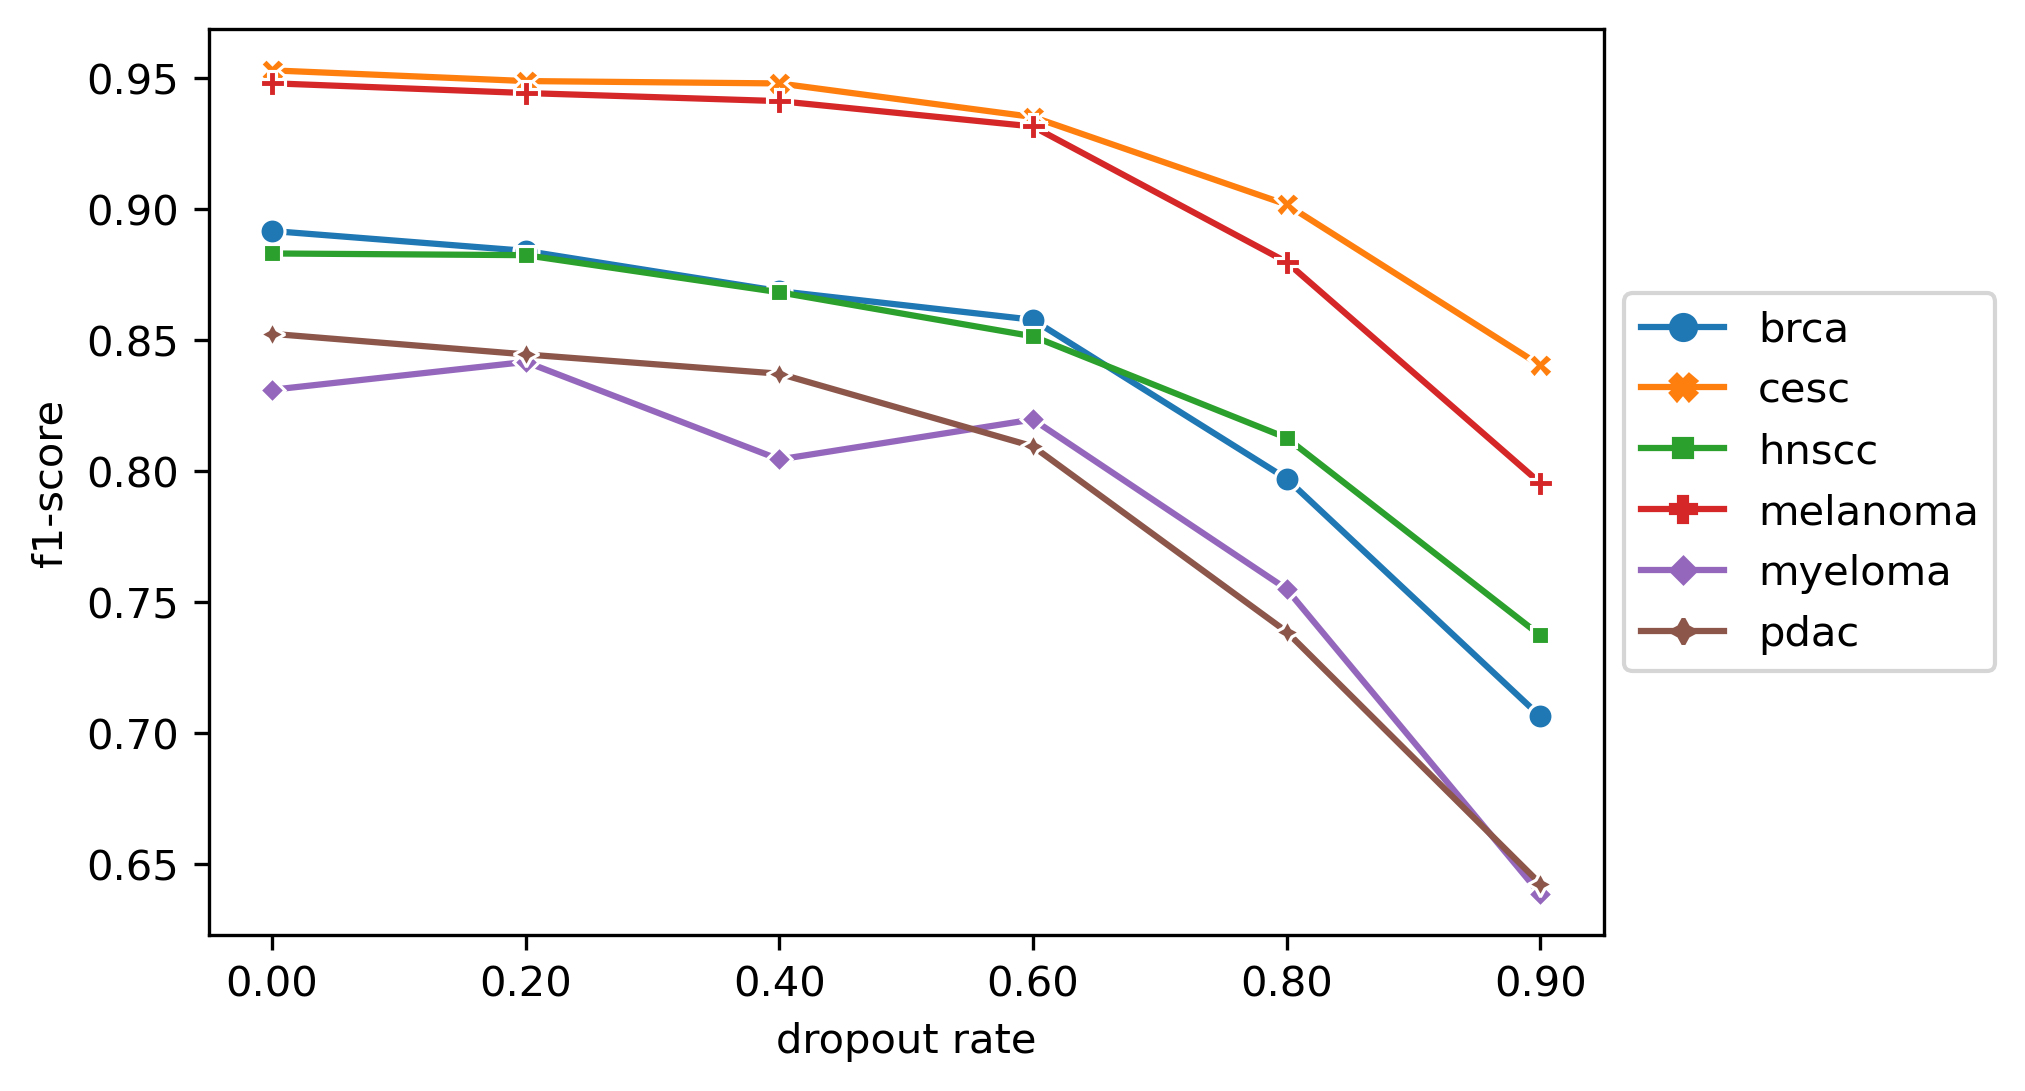

In [289]:
ax = sns.lineplot(data=dropout_df, x='dropout rate', y='f1-score', hue='disease', style="disease",
            markers=True, dashes=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'/data/pollock/benchmarking/figures/dropout_scrnaseq.pdf')

cross dataset

In [290]:
cross_results_dir = '/data/pollock/benchmarking/results/pollock/cross_disease/'
fps = sorted(listfiles(cross_results_dir, regex=r'clf_report.txt$'))
fps

['/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_brca_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_cesc_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_hnscc_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_melanoma_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_myeloma_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_brca_pdac_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_cesc_brca_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_cesc_cesc_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_cesc_hnscc_clf_report.txt',
 '/data/pollock/benchmarking/results/pollock/cross_disease/scRNAseq_cesc_melanoma_clf_report.txt',
 '/data/pollock/benchmarking/results/

In [291]:
data = []
for fp in fps:
    root = fp.split('/')[-1].split('_clf')[0]
    dtype, train_disease, val_disease = root.split('_')
    df = pd.read_csv(fp, sep='\t', index_col=0)
    for c in df.iloc[:, :-3].columns:
        data.append([dtype, train_disease, val_disease, c, df.loc['f1-score', c]])
cross_df = pd.DataFrame(data=data,
                        columns=['data type', 'train dataset', 'predicted dataset', 'cell_type', 'f1-score'])
cross_df

data type train dataset predicted dataset         cell_type  f1-score
0    scRNAseq          brca              brca            B cell  0.990079
1    scRNAseq          brca              brca        CD4 T cell  0.774510
2    scRNAseq          brca              brca        CD8 T cell  0.773176
3    scRNAseq          brca              brca         Dendritic  0.945652
4    scRNAseq          brca              brca       Endothelial  0.921549
..        ...           ...               ...               ...       ...
577  snRNAseq           gbm               gbm         Microglia  0.972277
578  snRNAseq           gbm               gbm          Monocyte  0.965517
579  snRNAseq           gbm               gbm            Neuron  0.993988
580  snRNAseq           gbm               gbm  Oligodendrocytes  0.991968
581  snRNAseq           gbm               gbm           T cells  0.987952

[582 rows x 5 columns]

In [292]:
small = cross_df[cross_df['data type']=='scRNAseq']
small['f1-score'] = [s if s!=0 else None for s in small['f1-score']]
small

/tmp/ipykernel_12940/1601925754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['f1-score'] = [s if s!=0 else None for s in small['f1-score']]


data type train dataset predicted dataset    cell_type  f1-score
0    scRNAseq          brca              brca       B cell  0.990079
1    scRNAseq          brca              brca   CD4 T cell  0.774510
2    scRNAseq          brca              brca   CD8 T cell  0.773176
3    scRNAseq          brca              brca    Dendritic  0.945652
4    scRNAseq          brca              brca  Endothelial  0.921549
..        ...           ...               ...          ...       ...
417  scRNAseq          pdac              pdac     Monocyte  0.805005
418  scRNAseq          pdac              pdac           NK  0.770492
419  scRNAseq          pdac              pdac       Plasma  0.951093
420  scRNAseq          pdac              pdac         Treg  0.912032
421  scRNAseq          pdac              pdac         Tuft  0.740741

[422 rows x 5 columns]

In [293]:
combined = None

for disease in sorted(set(small['train dataset'])):
    f = small[small['train dataset']==disease]
    c = alt.Chart(f, title=disease).mark_rect().encode(
        x=alt.X('cell_type'),
        y=alt.Y('predicted dataset'),
        color=alt.Color('f1-score:Q', scale=alt.Scale(scheme='Viridis'))
    )
    
    if combined is None:
        combined = c
    else:
        combined = alt.vconcat(combined, c)
combined

alt.VConcatChart(...)

In [294]:
data = []
for fp in fps:
    root = fp.split('/')[-1].split('_clf')[0]
    dtype, train_disease, val_disease = root.split('_')
    df = pd.read_csv(fp, sep='\t', index_col=0)
    data.append([dtype, train_disease, val_disease, df.loc['f1-score', 'macro avg']])
small = pd.DataFrame(data=data,
                        columns=['data type', 'train dataset', 'predicted dataset', 'f1-score'])
small

data type train dataset predicted dataset  f1-score
0    scRNAseq          brca              brca  0.891635
1    scRNAseq          brca              cesc  0.411853
2    scRNAseq          brca             hnscc  0.613650
3    scRNAseq          brca          melanoma  0.630937
4    scRNAseq          brca           myeloma  0.460051
5    scRNAseq          brca              pdac  0.719170
6    scRNAseq          cesc              brca  0.517703
7    scRNAseq          cesc              cesc  0.952926
8    scRNAseq          cesc             hnscc  0.504887
9    scRNAseq          cesc          melanoma  0.329260
10   scRNAseq          cesc           myeloma  0.282161
11   scRNAseq          cesc              pdac  0.587605
12   scRNAseq         hnscc              brca  0.739574
13   scRNAseq         hnscc              cesc  0.514068
14   scRNAseq         hnscc             hnscc  0.883052
15   scRNAseq         hnscc          melanoma  0.621312
16   scRNAseq         hnscc           myeloma  0.494949
17   scRNAseq         hnscc              pdac  0.782581
18   scRNAseq      melanoma              brca  0.815596
19   scRNAseq      melanoma              cesc  0.408377
20   scRNAseq      melanoma             hnscc  0.626467
21   scRNAseq      melanoma          melanoma  0.947998
22   scRNAseq      melanoma           myeloma  0.544287
23   scRNAseq      melanoma              pdac  0.763903
24   scRNAseq       myeloma              brca  0.563027
25   scRNAseq       myeloma              cesc  0.385969
26   scRNAseq       myeloma             hnscc  0.573935
27   scRNAseq       myeloma          melanoma  0.741248
28   scRNAseq       myeloma           myeloma  0.914547
29   scRNAseq       myeloma              pdac  0.459222
30   scRNAseq          pdac              brca  0.515778
31   scRNAseq          pdac              cesc  0.322626
32   scRNAseq          pdac             hnscc  0.484425
33   scRNAseq          pdac          melanoma  0.464879
34   scRNAseq          pdac           myeloma  0.328759
35   scRNAseq          pdac              pdac  0.852397
36  snATACseq          brca              brca  0.903782
37  snATACseq          brca             ccrcc  0.609399
38  snATACseq          brca               gbm  0.449728
39  snATACseq         ccrcc              brca  0.689917
40  snATACseq         ccrcc             ccrcc  0.949591
41  snATACseq         ccrcc               gbm  0.371022
42  snATACseq           gbm              brca  0.509488
43  snATACseq           gbm             ccrcc  0.388444
44  snATACseq           gbm               gbm  0.929578
45   snRNAseq          brca              brca  0.903811
46   snRNAseq          brca             ccrcc  0.501502
47   snRNAseq          brca               gbm  0.308362
48   snRNAseq         ccrcc              brca  0.599145
49   snRNAseq         ccrcc             ccrcc  0.946327
50   snRNAseq         ccrcc               gbm  0.333777
51   snRNAseq           gbm              brca  0.398151
52   snRNAseq           gbm             ccrcc  0.250945
53   snRNAseq           gbm               gbm  0.973775

In [295]:
combined = None
for dtype in set(small['data type']):
    source = small[small['data type']==dtype].copy()
    source.columns = ['data type', 'disease', 'method', 'f1-score']
    c = make_point_chart(source, show_axis=True, scale_domain=[0., 1.]) + make_tick_chart(source, title=dtype, show_axis=True, scale_domain=[0., 1.])
    
    if combined is None:
        combined = c
    else:
        combined = alt.vconcat(combined, c)
combined

alt.VConcatChart(...)

###### immune

immune specific

In [296]:
cm = pd.read_csv('/data/pollock/panimmune/results/brca-panimmune_val_confusion_matrix.txt', sep='\t',
                index_col=0)
cm

B cell  CD4 T cell  CD4 T cell - activated  \
cell_type                                                                
B cell                         490           1                       0   
CD4 T cell                       0         369                      11   
CD4 T cell - activated           0          10                     415   
CD4 T cell - exhausted           1           4                       5   
CD8 T cell - CTL                 0           0                       0   
CD8 T cell - exhausted           0          19                      44   
CD8 T cell - preexhausted        0          43                       1   
CD8 T cell - proliferating       0           1                       0   
Mast                             0           0                       0   
Monocyte/Macrophage              0           0                       0   
NK                               0           0                       0   
NKT                              0          27                      23   
Plasma                           2           0                       1   
Treg                             0          16                      13   
cDC1                             0           0                       0   
cDC2                             1           0                       0   
pDC                              0           0                       0   

                            CD4 T cell - exhausted  CD8 T cell - CTL  \
cell_type                                                              
B cell                                           0                 0   
CD4 T cell                                       4                12   
CD4 T cell - activated                           9                 0   
CD4 T cell - exhausted                         411                 0   
CD8 T cell - CTL                                 0               191   
CD8 T cell - exhausted                          49                 2   
CD8 T cell - preexhausted                        8                29   
CD8 T cell - proliferating                       0                 0   
Mast                                             0                 0   
Monocyte/Macrophage                              0                 0   
NK                                               0                 1   
NKT                                             11                 9   
Plasma                                           1                 0   
Treg                                            21                 0   
cDC1                                             0                 0   
cDC2                                             0                 0   
pDC                                              0                 0   

                            CD8 T cell - exhausted  CD8 T cell - preexhausted  \
cell_type                                                                       
B cell                                           0                          0   
CD4 T cell                                       7                         71   
CD4 T cell - activated                          29                         10   
CD4 T cell - exhausted                          39                          2   
CD8 T cell - CTL                                 0                          1   
CD8 T cell - exhausted                         275                         39   
CD8 T cell - preexhausted                        9                        391   
CD8 T cell - proliferating                       0                          0   
Mast                                             0                          0   
Monocyte/Macrophage                              0                          0   
NK                                               0                          0   
NKT                                             30                         49   
Plasma                                           4                          0   
Treg                                 

2022-01-20 11:40:09,483 maxp pruned
2022-01-20 11:40:09,500 cmap pruned
2022-01-20 11:40:09,501 kern dropped
2022-01-20 11:40:09,501 post pruned
2022-01-20 11:40:09,502 FFTM dropped
2022-01-20 11:40:09,504 GPOS pruned
2022-01-20 11:40:09,508 GSUB pruned
2022-01-20 11:40:09,511 name pruned
2022-01-20 11:40:09,528 glyf pruned
2022-01-20 11:40:09,530 Added gid0 to subset
2022-01-20 11:40:09,531 Added first four glyphs to subset
2022-01-20 11:40:09,532 Closing glyph list over 'GSUB': 43 glyphs before
2022-01-20 11:40:09,532 Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'slash', 'space', 't', 'two', 'u', 'underscore', 'v', 'x', 'y', 'zero']
2022-01-20 11:40:09,534 Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 23, 25, 27, 37, 38, 39, 46, 47, 48, 49, 51, 55, 66, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83,

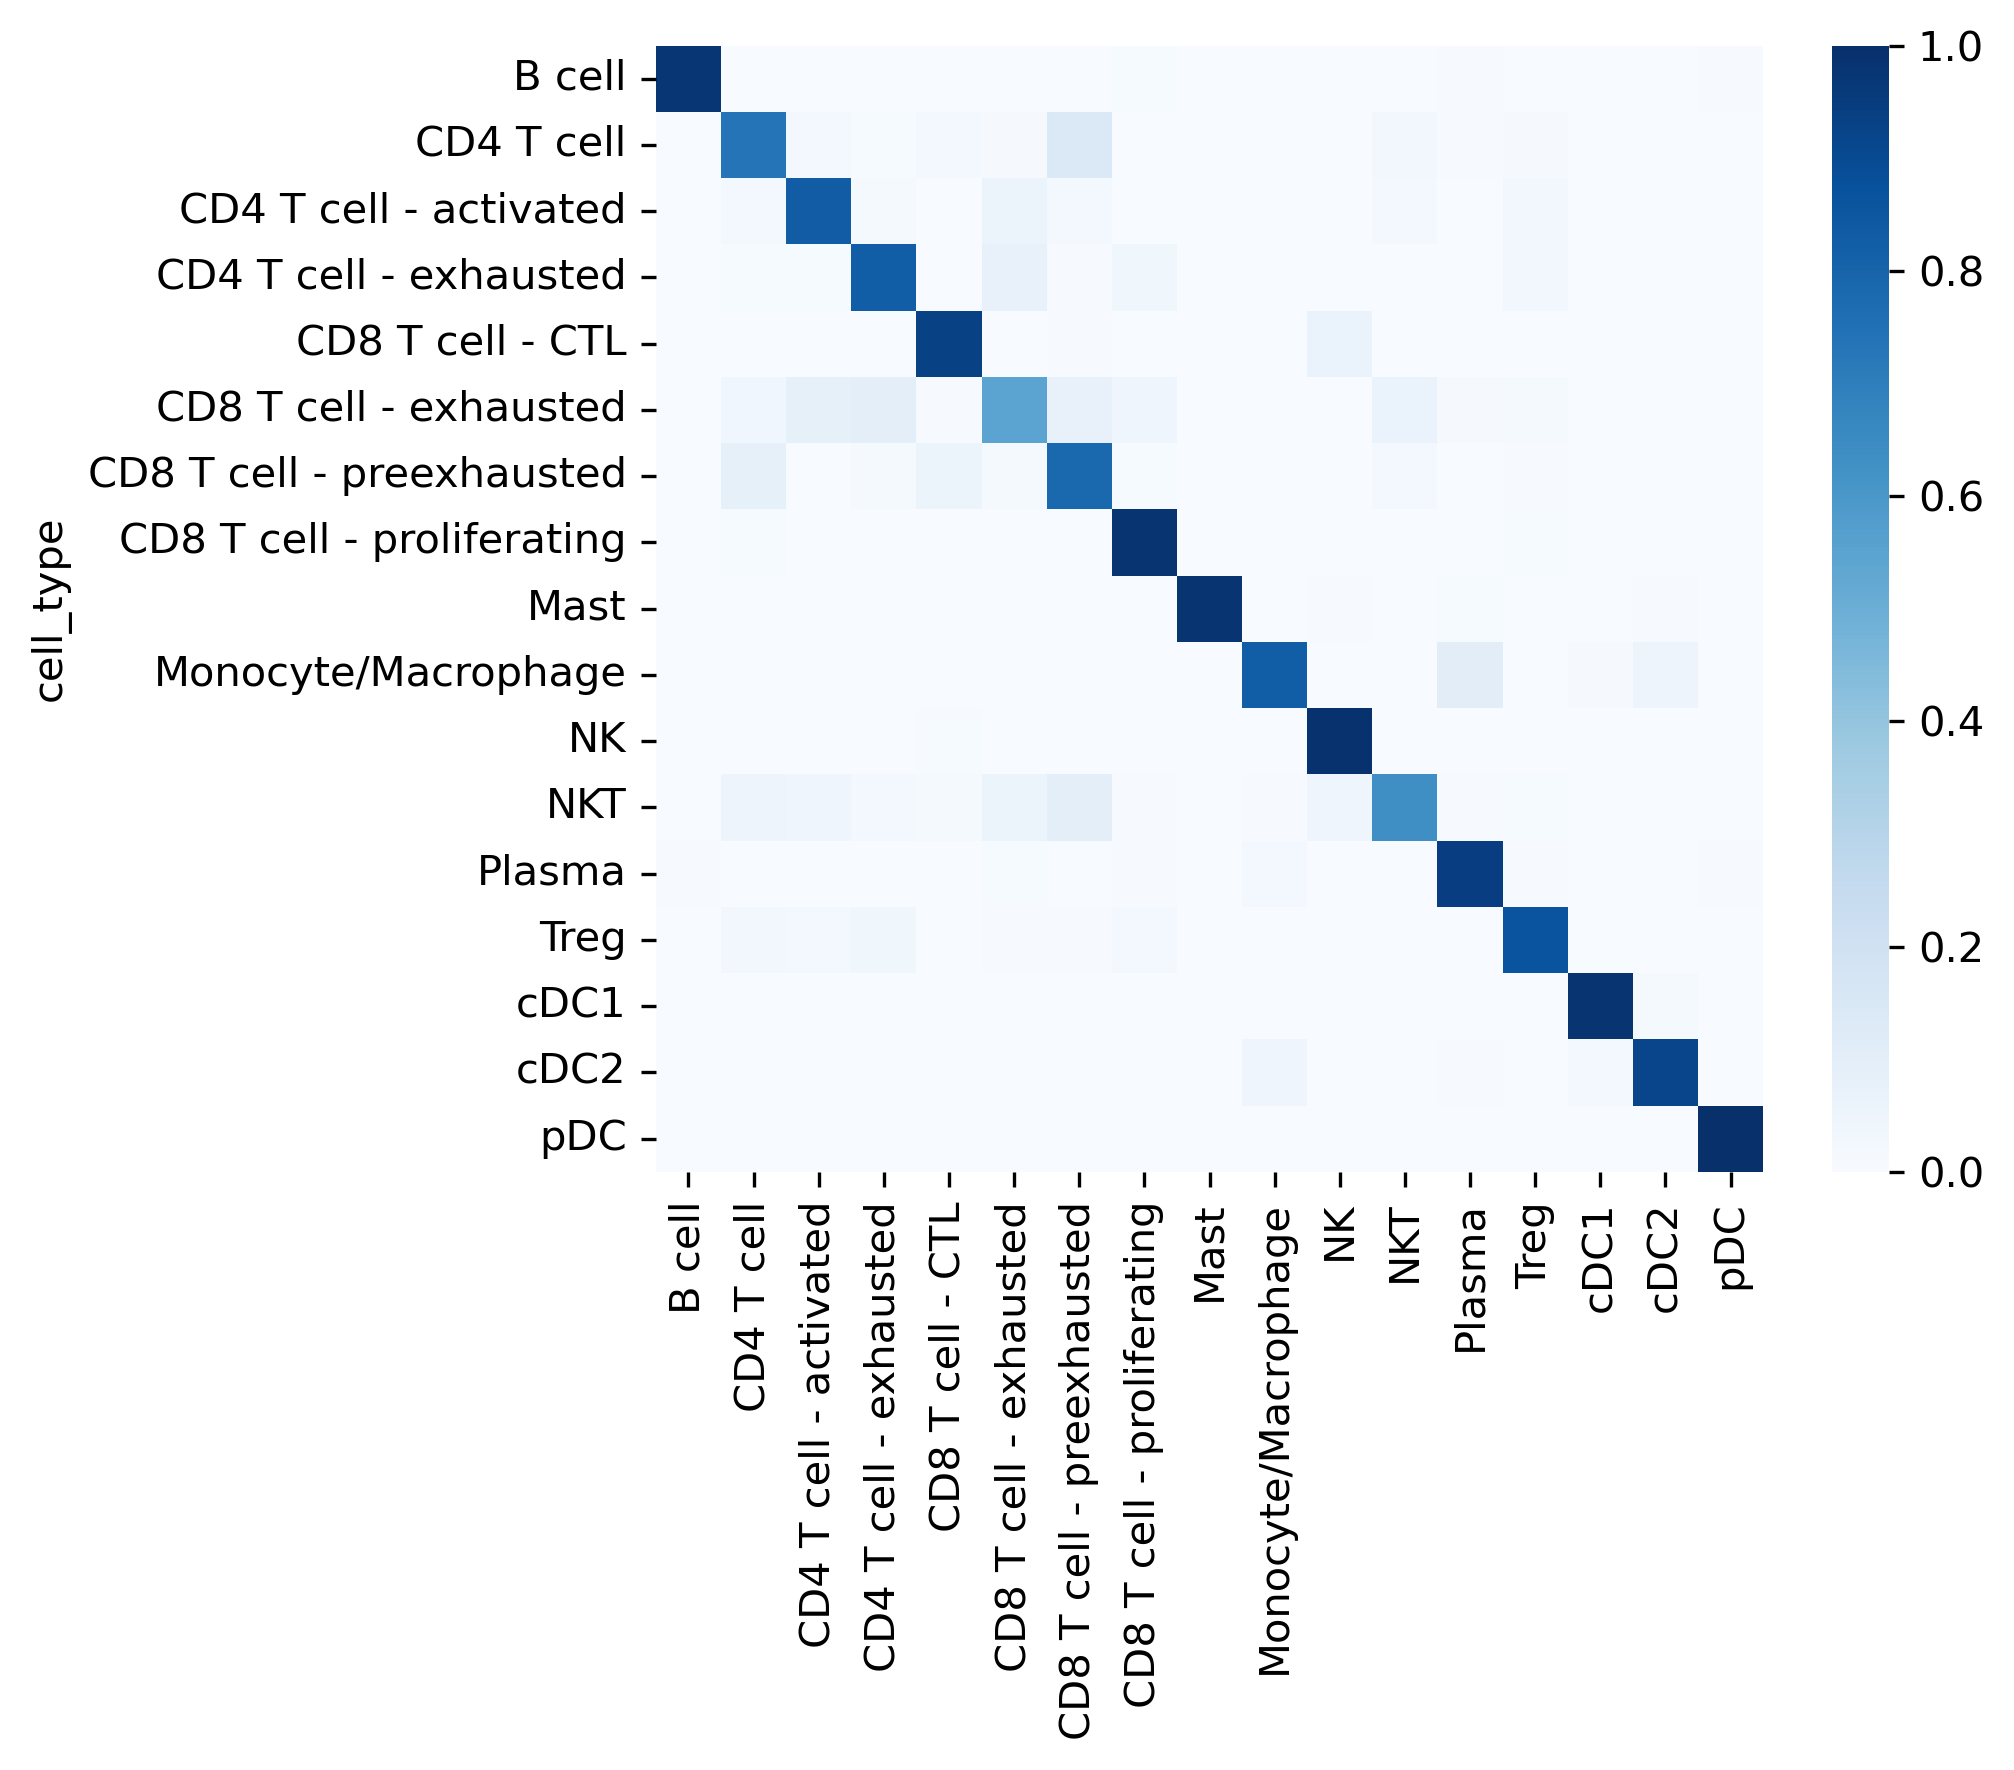

In [297]:
plot_confusion_matrix(cm)
plt.savefig(f'/data/pollock/benchmarking/figures/confusion_matrix_panimmune.pdf')

immune explain

In [335]:
df = pd.read_csv('/data/pollock/panimmune/results/explain_integrated.txt', sep='\t', index_col=0)
df

AL627309.1    AL627309.3  AL627309.4  \
HT065B1_S1H1_AGGGCCTCAAATTGCC-1        -0.0  1.403170e-06        -0.0   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1        -0.0 -9.009753e-04        -0.0   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1         0.0  8.585659e-07        -0.0   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1        -0.0  6.672578e-06        -0.0   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1        -0.0  2.470283e-06         0.0   
...                                     ...           ...         ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1        -0.0  0.000000e+00        -0.0   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1        -0.0  0.000000e+00        -0.0   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1        -0.0 -0.000000e+00         0.0   
HT171B1_S1H8_TGTTCATTCATTGTTC-1        -0.0 -0.000000e+00        -0.0   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1        -0.0 -0.000000e+00         0.0   

                                 AL669831.2  AL669831.5    FAM87B  LINC00115  \
HT065B1_S1H1_AGGGCCTCAAATTGCC-1        -0.0   -0.000011  0.000003  -0.000004   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1         0.0   -0.000023  0.000016   0.000007   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1         0.0   -0.000005  0.000010  -0.000002   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1        -0.0   -0.000017  0.000012   0.000009   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1         0.0   -0.000002  0.000006  -0.000007   
...                                     ...         ...       ...        ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1         0.0    0.000008 -0.000000  -0.000016   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1         0.0    0.000003  0.000000  -0.000013   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1         0.0    0.000016 -0.000000  -0.000014   
HT171B1_S1H8_TGTTCATTCATTGTTC-1         0.0   -0.000010 -0.000000  -0.000008   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1         0.0    0.000028 -0.000000  -0.000013   

                                   FAM41C  AL645608.3  AL645608.1  ...  \
HT065B1_S1H1_AGGGCCTCAAATTGCC-1 -0.000006         0.0        -0.0  ...   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1 -0.000013         0.0        -0.0  ...   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1 -0.000010         0.0        -0.0  ...   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1 -0.000012         0.0        -0.0  ...   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1 -0.000013         0.0        -0.0  ...   
...                                   ...         ...         ...  ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1  0.000021         0.0         0.0  ...   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1  0.000009         0.0         0.0  ...   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1  0.000034         0.0         0.0  ...   
HT171B1_S1H8_TGTTCATTCATTGTTC-1  0.000019         0.0         0.0  ...   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1  0.000008         0.0         0.0  ...   

                                   AC011043.1  AL592183.1    AC007325.4  \
HT065B1_S1H1_AGGGCCTCAAATTGCC-1  6.613822e-14    0.000001 -7.385790e-14   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1 -3.801396e-12   -0.000052 -6.576878e-13   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1 -1.370780e-12   -0.000001 -2.680380e-13   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1 -1.753536e-12   -0.000029 -3.543450e-12   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1 -1.659743e-12    0.000456 -5.032971e-13   
...                                       ...         ...           ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1  1.990896e-12    0.000016 -1.422592e-05   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1  1.099713e-12    0.000022 -2.002442e-05   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1  1.120236e-12    0.000045 -1.661529e-05   
HT171B1_S1H8_TGTTCATTCATTGTTC-1  4.069212e-13    0.000023 -1.286675e-05   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1  6.272746e-13    0.000014 -5.532404e-07   

                                 AC007325.2    AL354822.1    AC004556.1  \
HT065B1_S1H1_AGGGCCTCAAATTGCC-1        -0.0 -6.693868e-06 -3.290153e-05   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1        -0.0 -2.108621e-05 -6.721157e-05   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1         0.0 -1.950330e-05 -4.171603e-05   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1        -0.0 -2.367532e-05 -3.624754e-05   
HT067B1_S1H2_GCTGCAGAGTTACGTC-

In [336]:
from collections import Counter
Counter(df['cell_type'])

Counter({'B cell': 500,
         'CD4 T cell': 500,
         'CD4 T cell - activated': 500,
         'CD4 T cell - exhausted': 500,
         'CD8 T cell - CTL': 205,
         'CD8 T cell - exhausted': 500,
         'CD8 T cell - preexhausted': 500,
         'CD8 T cell - proliferating': 106,
         'Mast': 255,
         'Monocyte/Macrophage': 500,
         'NK': 106,
         'NKT': 500,
         'Plasma': 500,
         'Treg': 500,
         'cDC1': 54,
         'cDC2': 500,
         'pDC': 77})

In [337]:
import anndata

In [338]:
adata = anndata.AnnData(X=np.abs(df.values[:, :-1]))
adata.obs.index = df.index.to_list()
adata.obs['cell_type'] = df['cell_type'].to_list()
adata.var.index = df.columns[:-1]
adata

AnnData object with n_obs × n_vars = 6303 × 23949
    obs: 'cell_type'

In [339]:
adata.write_h5ad('/data/pollock/panimmune/results/explain.h5ad')

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


In [342]:
explain_table = pd.DataFrame(data=adata.X, columns=adata.var.index.to_list(),
                             index=adata.obs.index.to_list())
explain_table.index.name = 'cell_id'
explain_table

AL627309.1    AL627309.3  AL627309.4  \
cell_id                                                                 
HT065B1_S1H1_AGGGCCTCAAATTGCC-1         0.0  1.403170e-06         0.0   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1         0.0  9.009753e-04         0.0   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1         0.0  8.585660e-07         0.0   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1         0.0  6.672578e-06         0.0   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1         0.0  2.470283e-06         0.0   
...                                     ...           ...         ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1         0.0  0.000000e+00         0.0   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1         0.0  0.000000e+00         0.0   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1         0.0  0.000000e+00         0.0   
HT171B1_S1H8_TGTTCATTCATTGTTC-1         0.0  0.000000e+00         0.0   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1         0.0  0.000000e+00         0.0   

                                 AL669831.2  AL669831.5    FAM87B  LINC00115  \
cell_id                                                                        
HT065B1_S1H1_AGGGCCTCAAATTGCC-1         0.0    0.000011  0.000003   0.000004   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1         0.0    0.000023  0.000016   0.000007   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1         0.0    0.000005  0.000010   0.000002   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1         0.0    0.000017  0.000012   0.000009   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1         0.0    0.000002  0.000006   0.000007   
...                                     ...         ...       ...        ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1         0.0    0.000008  0.000000   0.000016   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1         0.0    0.000003  0.000000   0.000013   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1         0.0    0.000016  0.000000   0.000014   
HT171B1_S1H8_TGTTCATTCATTGTTC-1         0.0    0.000010  0.000000   0.000008   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1         0.0    0.000028  0.000000   0.000013   

                                   FAM41C  AL645608.3  AL645608.1  ...  \
cell_id                                                            ...   
HT065B1_S1H1_AGGGCCTCAAATTGCC-1  0.000006         0.0         0.0  ...   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1  0.000013         0.0         0.0  ...   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1  0.000010         0.0         0.0  ...   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1  0.000012         0.0         0.0  ...   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1  0.000013         0.0         0.0  ...   
...                                   ...         ...         ...  ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1  0.000021         0.0         0.0  ...   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1  0.000009         0.0         0.0  ...   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1  0.000034         0.0         0.0  ...   
HT171B1_S1H8_TGTTCATTCATTGTTC-1  0.000019         0.0         0.0  ...   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1  0.000008         0.0         0.0  ...   

                                    MAFIP    AC011043.1  AL592183.1  \
cell_id                                                               
HT065B1_S1H1_AGGGCCTCAAATTGCC-1  0.000002  6.613822e-14    0.000001   
HT077B1_S1H3_TTCTTGACAGCGGTCT-1  0.000008  3.801396e-12    0.000052   
HT077B1_S1H1_GCCGTGAGTGGATCAG-1  0.000010  1.370780e-12    0.000001   
HT105B1_S1H1_TTCCTAAGTGTAGCAG-1  0.000010  1.753536e-12    0.000029   
HT067B1_S1H2_GCTGCAGAGTTACGTC-1  0.000011  1.659743e-12    0.000456   
...                                   ...           ...         ...   
HT171B1_S1H8_AAGAACAGTACGCGTC-1  0.000011  1.990896e-12    0.000016   
HT105B1_N1K1_CAGCCAGAGATCCAAA-1  0.000003  1.099713e-12    0.000022   
HT065B1_S1H7_ACAGCCGAGCGTATAA-1  0.000013  1.120236e-12    0.000045   
HT171B1_S1H8_TGTTCATTCATTGTTC-1  0.000005  4.069212e-13    0.000023   
HT171B1_S1H8_TGAGCGCCAGAAGTTA-1  0.000006  6.272746e-13    0.000014   

                                   AC007325.4  AC007325.2    AL354822.1  \
cell_id                                                                   
HT065

In [343]:
explain_table.to_csv('/data/pollock/panimmune/results/explain_abs.txt', sep='\t')

In [344]:
marker_genes = {
    'B cell': ['MS4A1'],
    'CD4 T cell': ['CD3G', 'CD4'],
    'CD8 T cell': ['CD8A'],
    'T cell - Activated': ['CD69', 'CD28'],
    'T cell - Naive': ['IL7R'],
    'T cell - Effector': ['GZMA'],
    'T cell - Memory': ['CX3CR1'],
    'T cell - Regulatory': ['FOXP3'],
    'T cell - pre-exausted': ['GZMK'],
    'T cell - exausted': ['PDCD1', 'LAG3'],
    'T cell - proliferating': ['MKI67', 'TOP2A'],
    'NK': ['GNLY', 'CD7'],
    'NK - Strong': ['NKG7'],
    'NK - Weak': ['NCAM1'],
    'Mast': ['KIT', 'FCER1A'],
    'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
    'cDC': ['BATF3','IDO1'],
    'pDC': ['IL3RA'],
    'Plasma': ['SDC1'],
}
order = ['B cell', 'CD4 T cell', 'CD8 T cell', 'T cell - Activated', 'T cell - Naive', 'T cell - Effector',
        'T cell - Memory', 'T cell - Regulatory', 'T cell - pre-exausted', 'T cell - exausted',
        'T cell - proliferating', 'NK', 'NK - Strong', 'NK - Weak', 'Mast', 'Macrophage', 'cDC', 'pDC',
        'Plasma']
markers = []
for k in order: markers += marker_genes[k]
markers

['MS4A1',
 'CD3G',
 'CD4',
 'CD8A',
 'CD69',
 'CD28',
 'IL7R',
 'GZMA',
 'CX3CR1',
 'FOXP3',
 'GZMK',
 'PDCD1',
 'LAG3',
 'MKI67',
 'TOP2A',
 'GNLY',
 'CD7',
 'NKG7',
 'NCAM1',
 'KIT',
 'FCER1A',
 'CD14',
 'FCGR3A',
 'LYZ',
 'BATF3',
 'IDO1',
 'IL3RA',
 'SDC1']

In [345]:
sc.settings.figdir = '/data/pollock/benchmarking/figures/'

2022-01-21 11:26:30,432 maxp pruned
2022-01-21 11:26:30,444 cmap pruned
2022-01-21 11:26:30,445 kern dropped
2022-01-21 11:26:30,446 post pruned
2022-01-21 11:26:30,447 FFTM dropped
2022-01-21 11:26:30,451 GPOS pruned
2022-01-21 11:26:30,459 GSUB pruned
2022-01-21 11:26:30,460 name pruned
2022-01-21 11:26:30,470 glyf pruned
2022-01-21 11:26:30,472 Added gid0 to subset
2022-01-21 11:26:30,473 Added first four glyphs to subset
2022-01-21 11:26:30,473 Closing glyph list over 'GSUB': 56 glyphs before
2022-01-21 11:26:30,475 Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'zero']
2022-01-21 11:26:30,476 Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 36, 37, 38, 

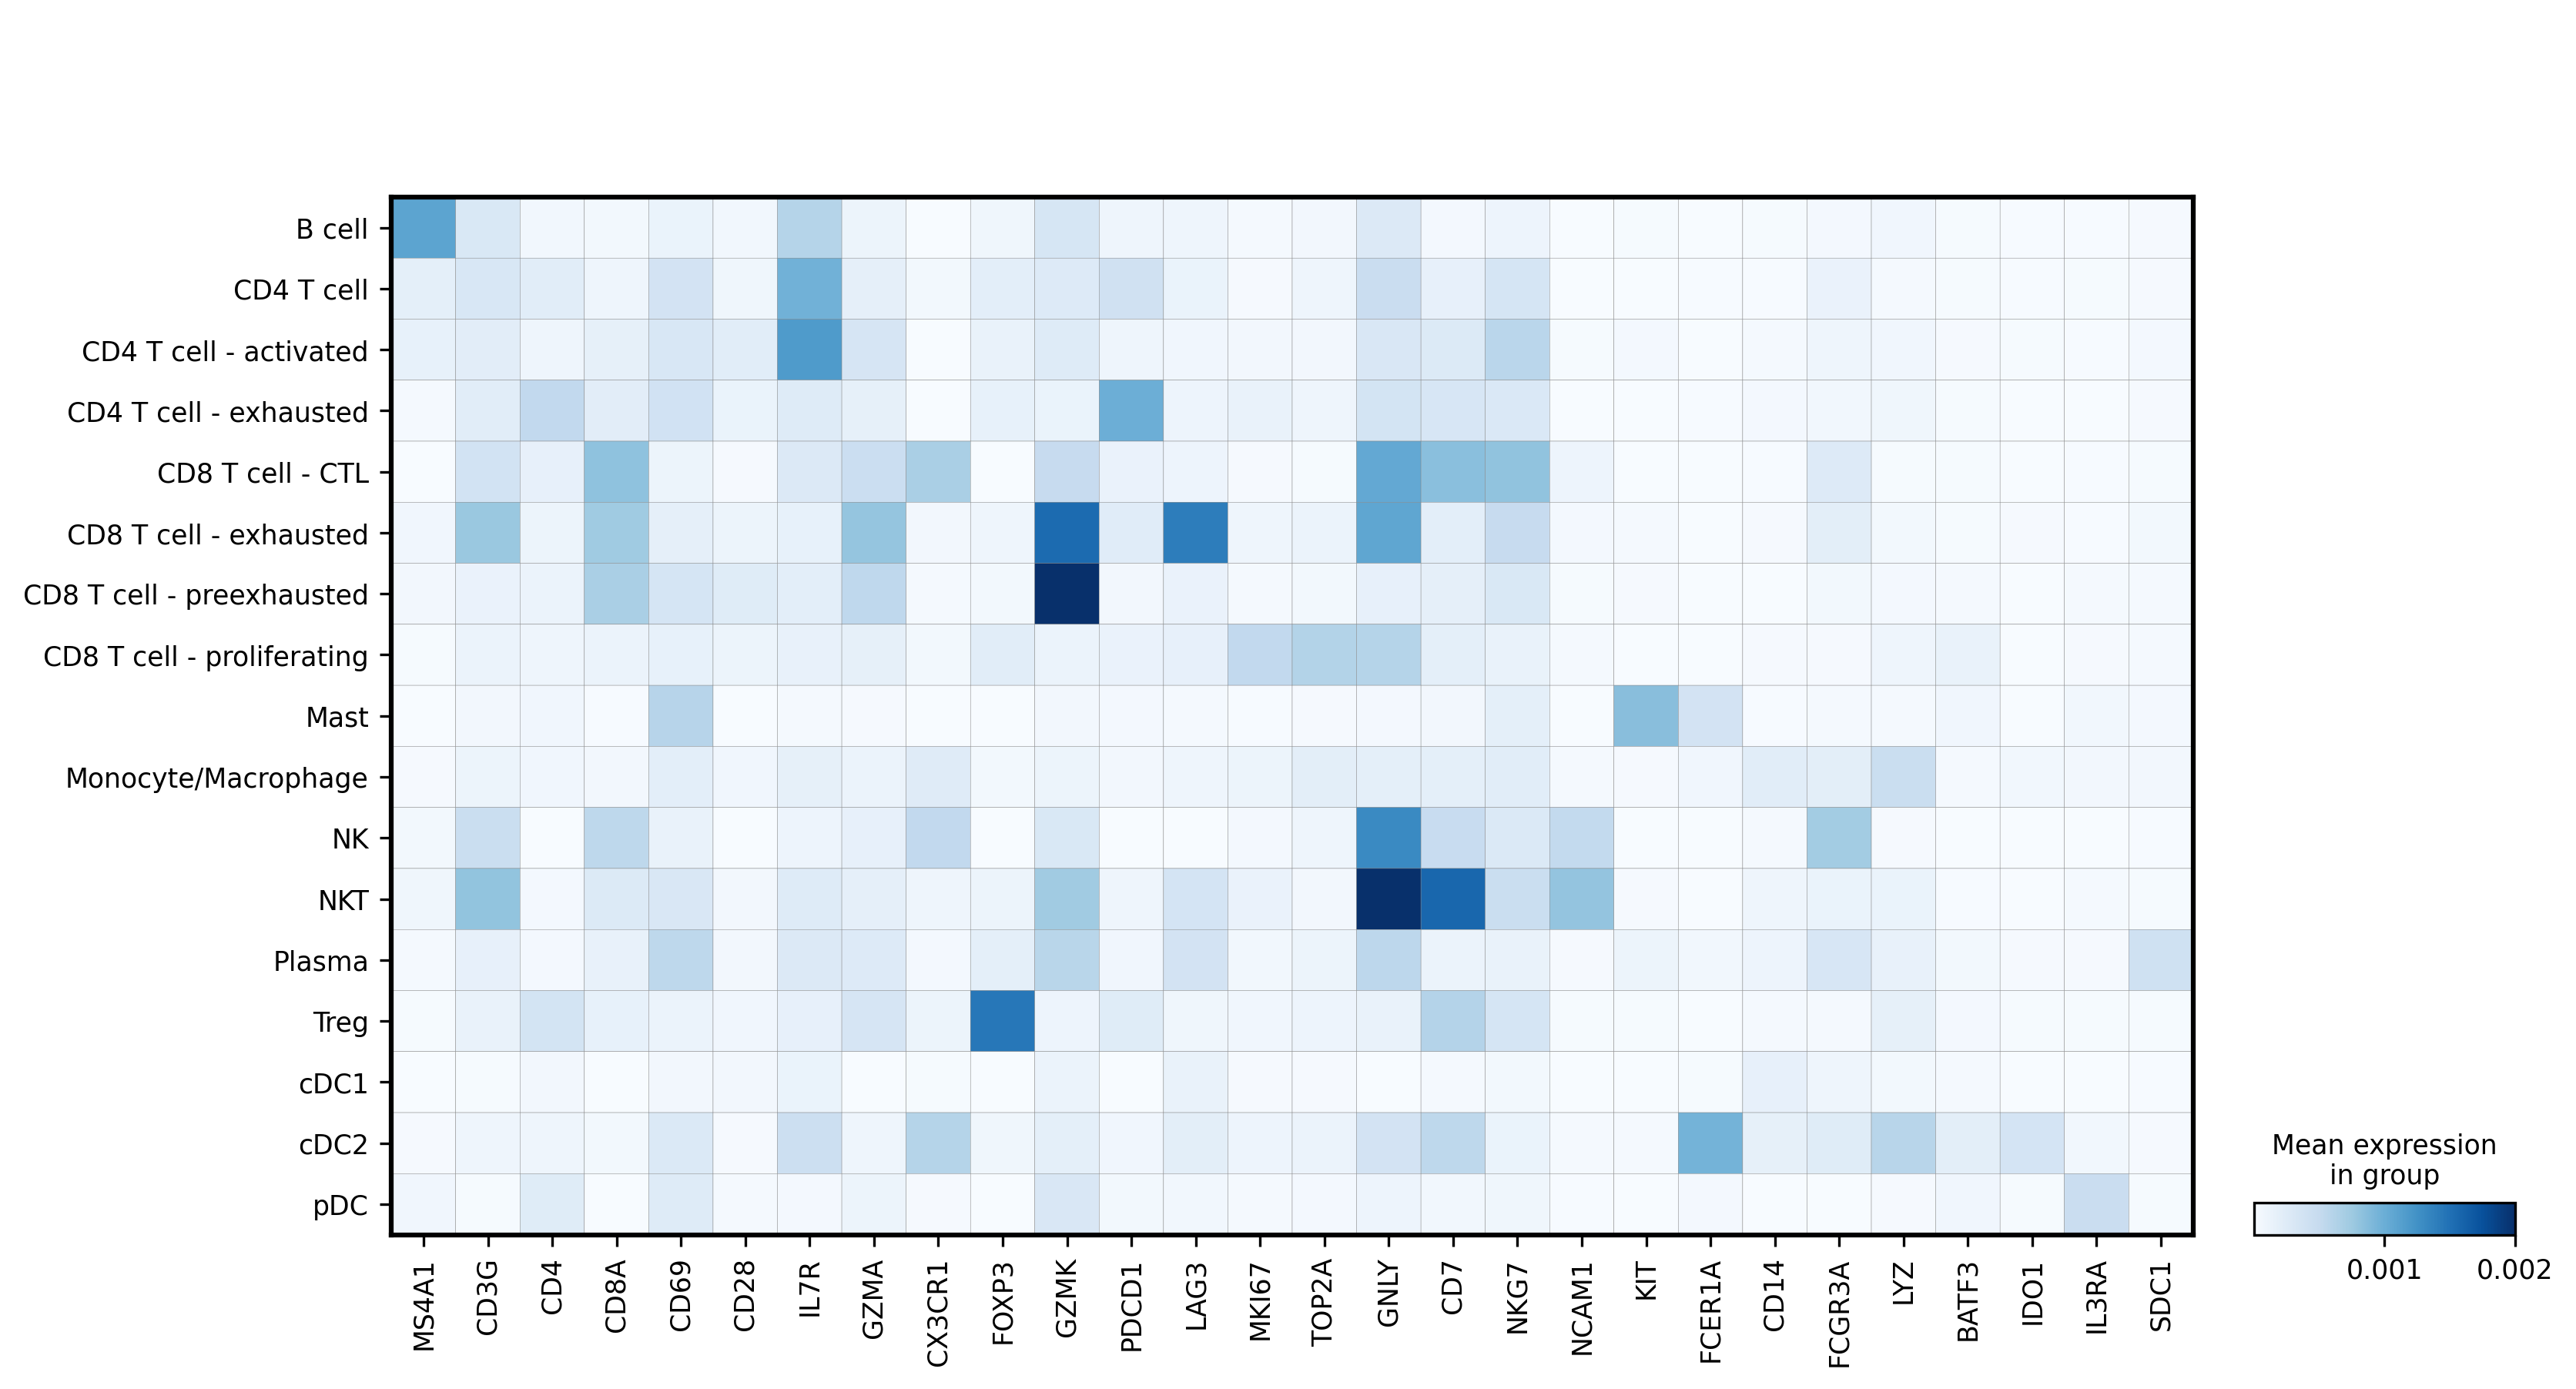

In [346]:
sc.pl.matrixplot(adata, markers, groupby='cell_type', cmap='Blues', vmax=.002, save='_feature_importance_squares.pdf')

In [347]:
exp = sc.read_h5ad('/data/pollock/panimmune/data/brca-panimmune_val.h5ad')
exp = exp[adata.obs.index.to_list()]
exp

View of AnnData object with n_obs × n_vars = 6303 × 27131
    obs: 'cell_type', 'sample', 'barcode'
    obsm: 'X_umap'
    layers: 'counts'

In [348]:
sc.pp.normalize_total(exp, target_sum=1e6)
sc.pp.log1p(exp)

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


2022-01-21 11:26:36,049 maxp pruned
2022-01-21 11:26:36,059 cmap pruned
2022-01-21 11:26:36,060 kern dropped
2022-01-21 11:26:36,061 post pruned
2022-01-21 11:26:36,061 FFTM dropped
2022-01-21 11:26:36,065 GPOS pruned
2022-01-21 11:26:36,071 GSUB pruned
2022-01-21 11:26:36,073 name pruned
2022-01-21 11:26:36,083 glyf pruned
2022-01-21 11:26:36,085 Added gid0 to subset
2022-01-21 11:26:36,086 Added first four glyphs to subset
2022-01-21 11:26:36,086 Closing glyph list over 'GSUB': 59 glyphs before
2022-01-21 11:26:36,087 Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'zero']
2022-01-21 11:26:36,088 Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 16, 18, 19, 2

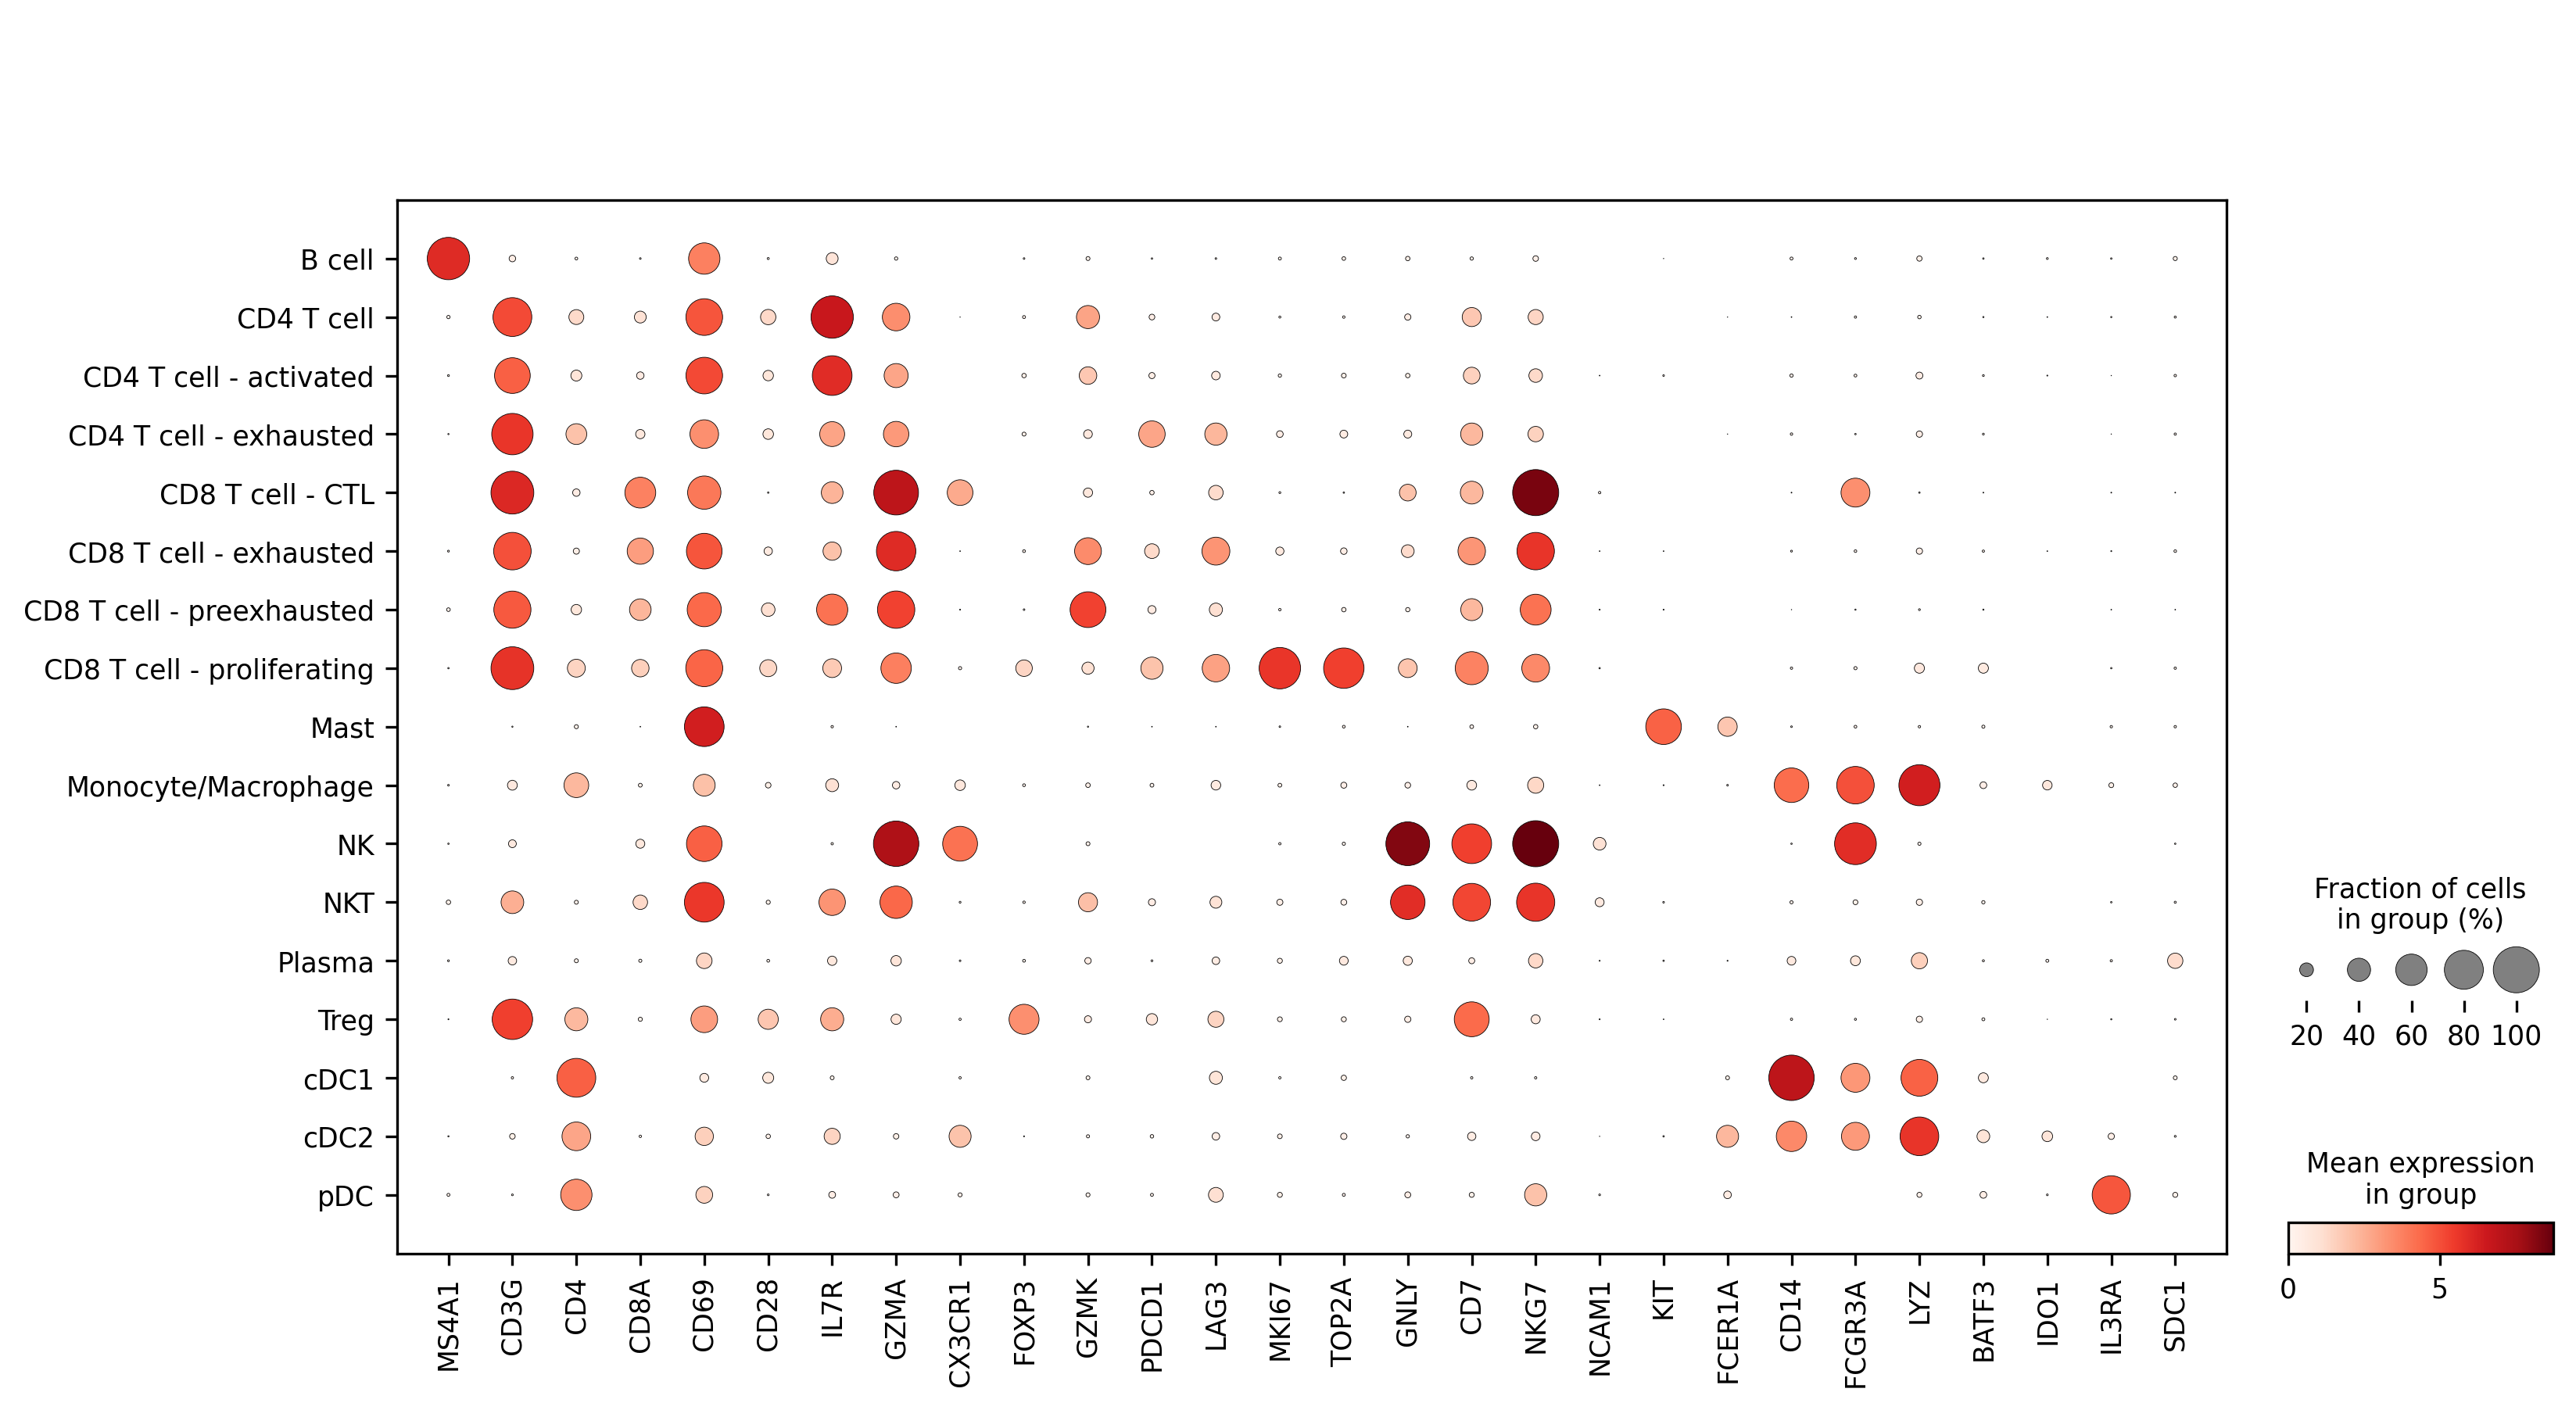

In [349]:
sc.pl.dotplot(exp, markers, groupby='cell_type', cmap='Reds', save='_exp_circles.pdf')

In [350]:
sc.tl.rank_genes_groups(adata, groupby='cell_type')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_12940/4179989524.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2022-01-20 11:44:46,180 maxp pruned
2022-01-20 11:44:46,191 cmap pruned
2022-01-20 11:44:46,192 kern dropped
2022-01-20 11:44:46,193 post pruned
2022-01-20 11:44:46,194 FFTM dropped
2022-01-20 11:44:46,197 GPOS pruned
2022-01-20 11:44:46,203 GSUB pruned
2022-01-20 11:44:46,205 name pruned
2022-01-20 11:44:46,564 glyf pruned
2022-01-20 11:44:46,566 Added gid0 to subset
2022-01-20 11:44:46,567 Added first four glyphs to subset
2022-01-20 11:44:46,568 Closing glyph list over 'GSUB': 41 glyphs before
2022-01-20 11:44:46,568 Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'slash', 'space', 't', 'two', 'u', 'v', 'x', 'y', 'zero']
2022-01-20 11:44:46,570 Gl

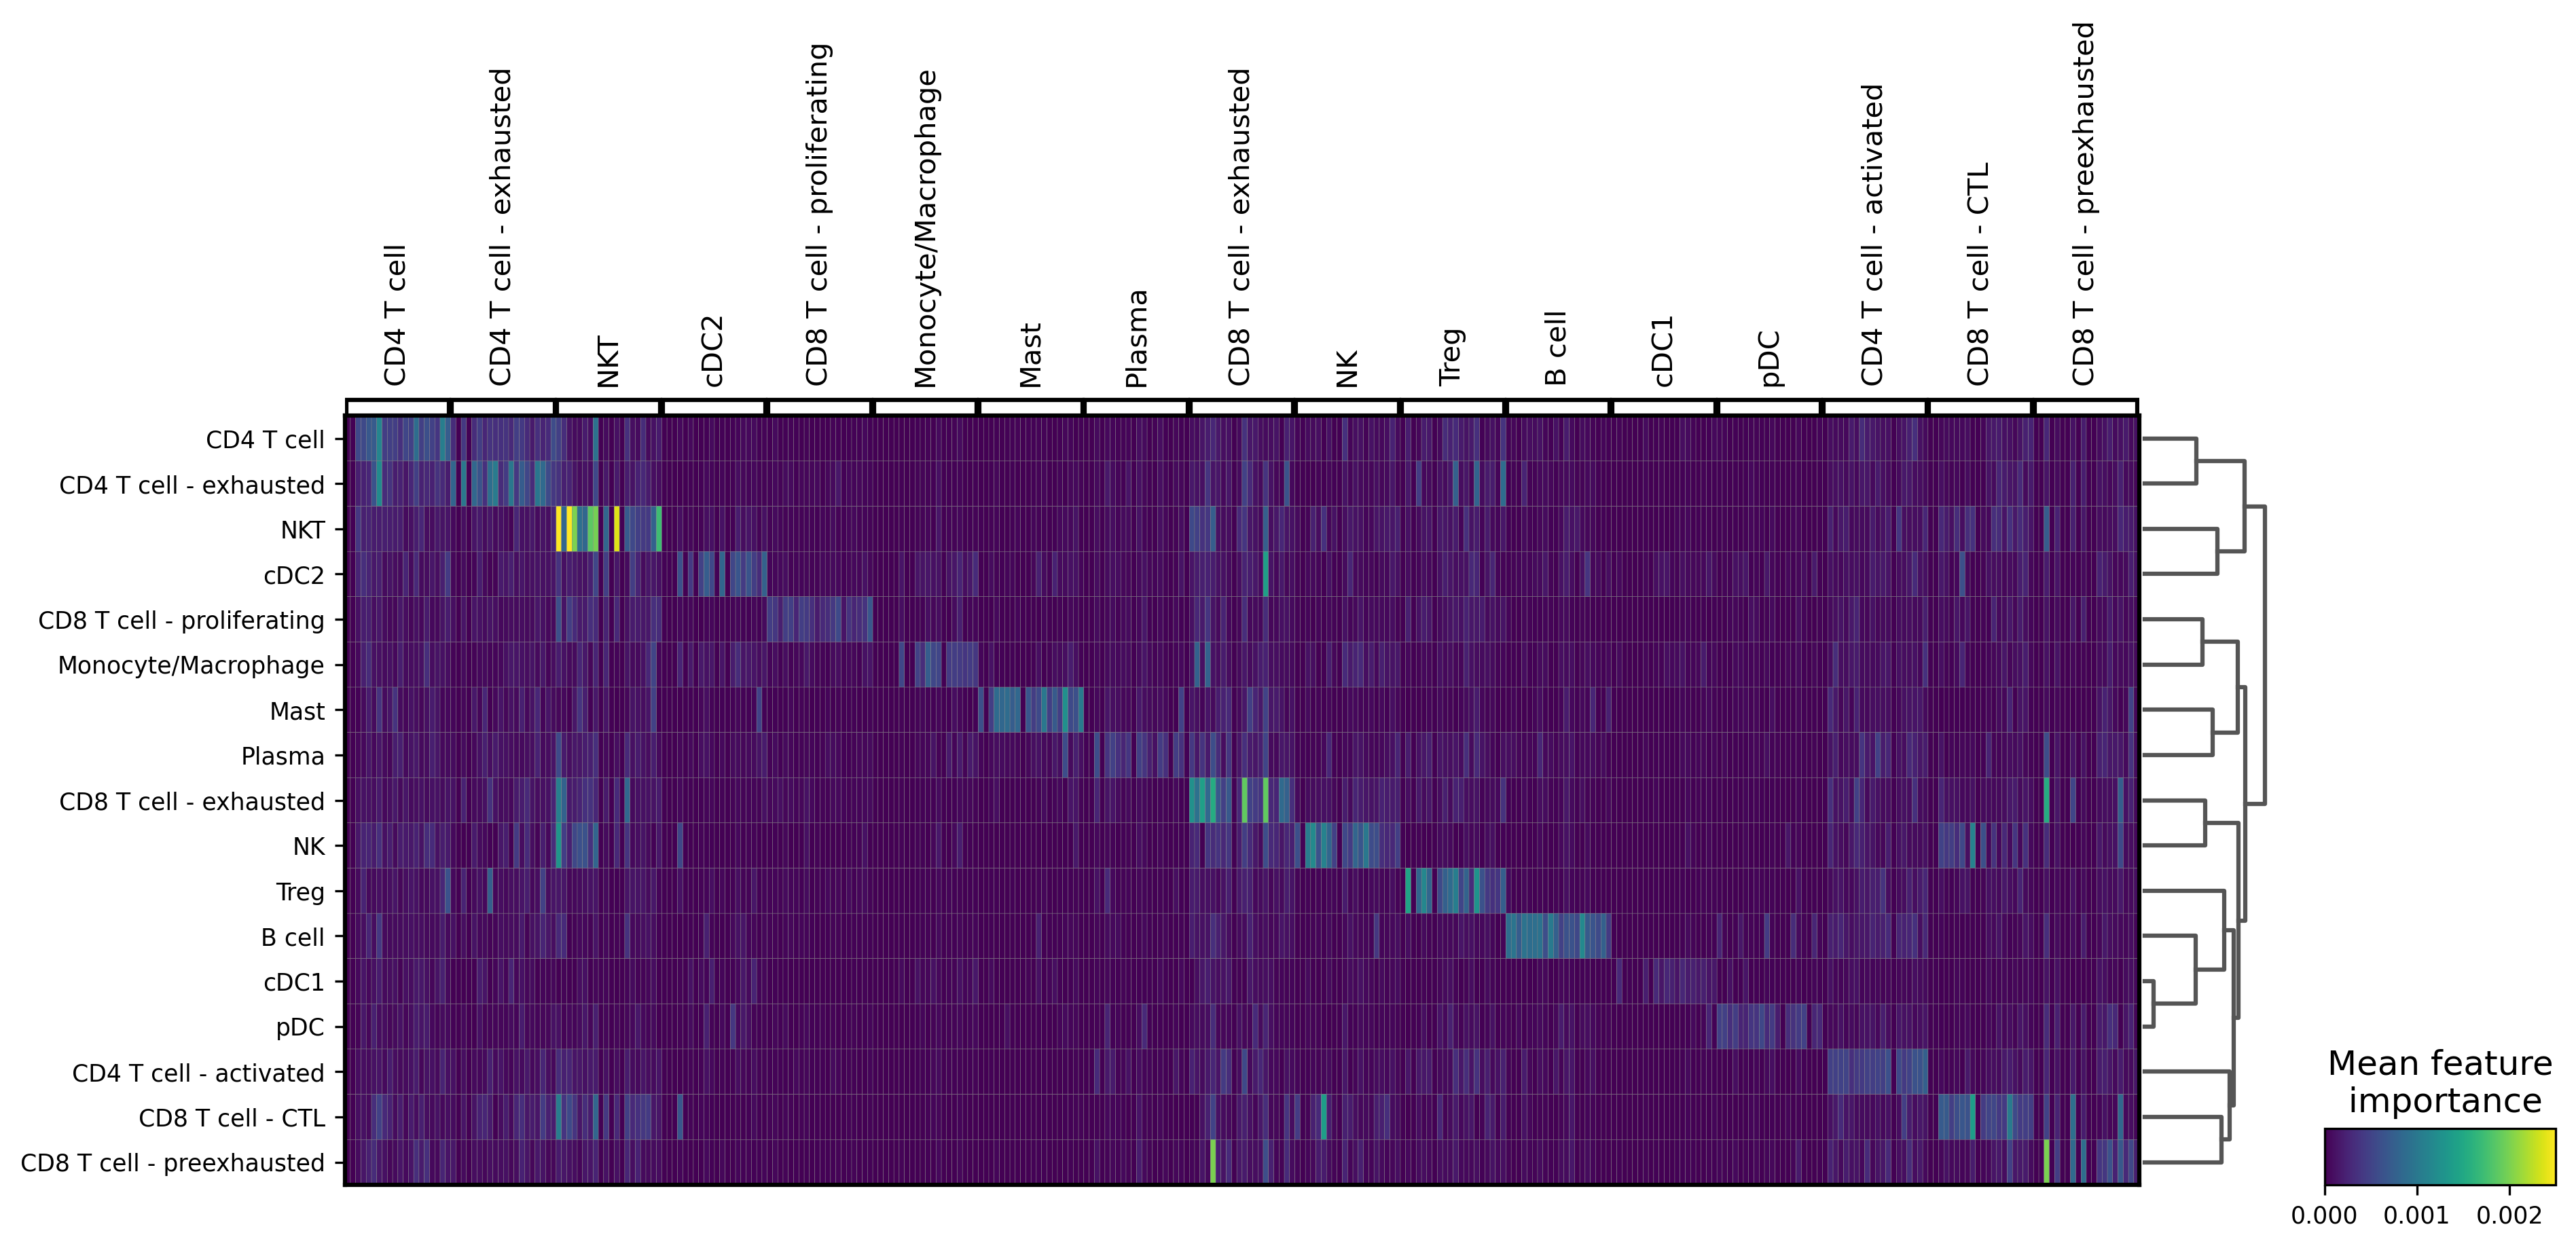

In [309]:
axs = sc.pl.rank_genes_groups_matrixplot(adata, groupby='cell_type', n_genes=20, show=False,
                                         figsize=(14, 5), vmax=.0025)

axs['mainplot_ax'].set_xticks([])
axs['mainplot_ax'].set_xlabel('')
axs['color_legend_ax'].set_title('Mean feature\n importance')

plt.tight_layout()
plt.savefig('/data/pollock/benchmarking/figures/rank_feature_importances.pdf')

In [353]:
adata.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [354]:
adata.uns['rank_genes_groups']['names']

rec.array([('TNFRSF13B', 'AL731537.1', 'CDHR2', 'TSHZ2', 'BSN', 'S100A7', 'OR10K1', 'CDCA2', 'AL157895.1', 'RAD21L1', 'S1PR5', 'GNLY', 'AC022613.2', 'AC093151.3', 'OR51B2', 'AC007731.4', 'TCL1A'),
           ('CD19', 'AC089998.1', 'EZR', 'DIO3', 'ABCA9-AS1', 'S100A8', 'PADI1', 'ARHGAP11A', 'C9orf135', 'BEAN1-AS1', 'ANGPTL8', 'CD3G', 'IGBP1-AS2', 'FOXP3', 'MAMDC2', 'HMGCS2', 'LAMP5'),
           ('FCRLA', 'PARP8', 'ATP5PO', 'PDCD1', 'ADGRG1', 'LAG3', 'GZMK', 'ANLN', 'PTGS1', 'CLVS1', 'MYOM2', 'XCL1', 'TM4SF1', 'AC018946.1', 'RPEL1', 'Z97205.2', 'SCN9A'),
           ...,
           ('PKM', 'GPNMB', 'UQCRH', 'H1FX', 'IFIT1', 'CIR1', 'HNRNPDL', 'RAB8B', 'CD247', 'RFC1', 'SIT1', 'SRRM1', 'SEPT6', 'GCC2', 'DUSP4', 'PET100', 'EIF4G2'),
           ('AKAP9', 'UPF2', 'GAPT', 'BPTF', 'S100A8', 'CCNI', 'EIF3H', 'GAPT', 'GBP5', 'EIF5B', 'CD82', 'PPP1CB', 'BRK1', 'PKM', 'RHOH', 'TRBC2', 'CD8A'),
           ('CST7', 'EIF3J', 'HNRNPH1', 'G3BP2', 'RSAD2', 'YPEL5', 'CSK', 'TMCO1', 'GIMAP4', 'PRDX5', 'IF

In [356]:
adata.uns['rank_genes_groups']['scores']['B cell']

array([ 30.529036,  29.654795,  29.45997 , ..., -39.47534 , -40.487026,
       -42.95407 ], dtype=float32)

In [359]:
df = None
for ct in sorted(set(adata.obs['cell_type'])):
    small = pd.DataFrame.from_dict({
        'gene': adata.uns['rank_genes_groups']['names'][ct],
        'score': adata.uns['rank_genes_groups']['scores'][ct],
        'p-value': adata.uns['rank_genes_groups']['pvals'][ct],
        'p-value adj': adata.uns['rank_genes_groups']['pvals'][ct],
        'logfold change': adata.uns['rank_genes_groups']['pvals'][ct],
    })
    small['cell type'] = ct
    
    if df is None:
        df = small
    else:
        df = pd.concat((df, small), axis=0)
df

gene      score        p-value    p-value adj  logfold change  \
0      TNFRSF13B  30.529036  1.551050e-116  1.551050e-116   1.551050e-116   
1           CD19  29.654795  7.537969e-113  7.537969e-113   7.537969e-113   
2          FCRLA  29.459970  5.509720e-112  5.509720e-112   5.509720e-112   
3           AIM2  29.294086  4.463560e-112  4.463560e-112   4.463560e-112   
4      TNFRSF13C  29.262115  3.789060e-111  3.789060e-111   3.789060e-111   
...          ...        ...            ...            ...             ...   
23944      NLRP1 -38.416698  5.911971e-290  5.911971e-290   5.911971e-290   
23945      PSMD8 -39.244682  1.526533e-107  1.526533e-107   1.526533e-107   
23946     EIF4G2 -39.312664  4.859058e-100  4.859058e-100   4.859058e-100   
23947       CD8A -42.775875   0.000000e+00   0.000000e+00    0.000000e+00   
23948    PSTPIP1 -48.257908   0.000000e+00   0.000000e+00    0.000000e+00   

      cell type  
0        B cell  
1        B cell  
2        B cell  
3        B cell  
4        B cell  
...         ...  
23944       pDC  
23945       pDC  
23946       pDC  
23947       pDC  
23948       pDC  

[407133 rows x 6 columns]

In [360]:
df.to_csv('/data/pollock/panimmune/results/explain_dwgs.txt', sep='\t', index=False)

In [184]:
n = 20
pathways = {}

In [182]:

for g in adata.uns['rank_genes_groups']['names']['CD8 T cell - proliferating'][:n]: print(g)

CDCA2
ARHGAP11A
ANLN
SGO1
PBK
FOXM1
CENPA
RRM2
SPC25
CKAP2L
KIF14
KIF23
BUB1B
CCNA2
E2F7
NCAPH
STIL
KIF4A
BRCA1
CDCA8


In [185]:
import pandas as pd
import numpy as np
go_pathways = pd.read_csv('/data/pollock/panimmune/results/explain/t_cell_proliferating.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways['Genes in pathway'] = go_pathways['Hit Count in Query List'].to_list()
pathways['CD8 T cell - proliferating'] = go_pathways

In [362]:
for g in adata.uns['rank_genes_groups']['names']['CD8 T cell - exhausted'][:n]: print(g)

S100A7
S100A8
LAG3
S100A9
GZMK
AAK1
H2AFV
NDUFB2
AL138733.1
BCLAF1
IFNG
CAST
IRF7
VAMP2
CCL4L2
YY1
ANKRD44
IGHGP
SH2D1A
NCOR1


In [189]:
go_pathways = pd.read_csv('/data/pollock/panimmune/results/explain/cd8_exhausted.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways['Genes in pathway'] = go_pathways['Hit Count in Query List'].to_list()
pathways['CD8 T cell - exhausted'] = go_pathways

In [191]:
for g in adata.uns['rank_genes_groups']['names']['NK'][:n]: print(g)

S1PR5
ANGPTL8
MYOM2
KLRF1
CD160
FGFBP2
PRSS23
NCR1
AC008667.4
SYNE1
ITGAM
TTC38
CEP78
AKR1C3
GK5
NCR3
TRAPPC10
PLEKHA1
PRPF40A
PTPN12


In [192]:
go_pathways = pd.read_csv('/data/pollock/panimmune/results/explain/nk.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways['Genes in pathway'] = go_pathways['Hit Count in Query List'].to_list()
pathways['NK'] = go_pathways

In [193]:
for g in adata.uns['rank_genes_groups']['names']['Treg'][:n]: print(g)

AC093151.3
FOXP3
AC018946.1
CXCR6
RTKN2
LINC01943
AL591806.3
ANKRD10
DUSP16
IKZF2
CTLA4
SLAMF1
MIR4435-2HG
UBE2K
TNFRSF4
AC017002.3
GATA3
AP2B1
F5
SIRPG


In [194]:
go_pathways = pd.read_csv('/data/pollock/panimmune/results/explain/treg.txt',
                         sep='\t')
go_pathways['-log10(FDR)'] = [-np.log10(x) for x in go_pathways['q-value FDR B&H']]
go_pathways['Genes in pathway'] = go_pathways['Hit Count in Query List'].to_list()
pathways['Treg'] = go_pathways

In [195]:
source = pathways['NK']
source

Category          ID  \
0   GO: Biological Process  GO:0001910   
1   GO: Biological Process  GO:0031341   
2   GO: Biological Process  GO:0001909   
3   GO: Biological Process  GO:0042269   
4   GO: Biological Process  GO:0002715   
5   GO: Biological Process  GO:0001912   
6   GO: Biological Process  GO:0042267   
7   GO: Biological Process  GO:0031343   
8   GO: Biological Process  GO:0001906   
9   GO: Biological Process  GO:0002228   
10  GO: Biological Process  GO:0002703   
11  GO: Biological Process  GO:0030101   
12  GO: Biological Process  GO:2000353   
13  GO: Biological Process  GO:0045954   
14  GO: Biological Process  GO:0002705   
15  GO: Biological Process  GO:0050776   
16  GO: Biological Process  GO:0043302   
17  GO: Biological Process  GO:0002717   
18  GO: Biological Process  GO:0002706   
19  GO: Biological Process  GO:1904037   
20  GO: Biological Process  GO:0045827   
21  GO: Biological Process  GO:1900280   
22  GO: Biological Process  GO:1900053   
23  GO: Biological Process  GO:0043300   
24  GO: Biological Process  GO:0002697   
25  GO: Biological Process  GO:0046164   
26  GO: Biological Process  GO:1903307   
27  GO: Biological Process  GO:0002699   
28  GO: Biological Process  GO:0048008   
29  GO: Biological Process  GO:2000351   
30  GO: Biological Process  GO:0061886   
31  GO: Biological Process  GO:1905675   
32  GO: Biological Process  GO:0016487   
33  GO: Biological Process  GO:0016488   
34  GO: Biological Process  GO:0006714   
35  GO: Biological Process  GO:1900279   
36  GO: Biological Process  GO:0016107   
37  GO: Biological Process  GO:1900052   
38  GO: Biological Process  GO:1903353   
39  GO: Biological Process  GO:0110090   
40  GO: Biological Process  GO:0072577   
41  GO: Biological Process  GO:1901616   
42  GO: Biological Process  GO:2000363   
43  GO: Biological Process  GO:2000361   
44  GO: Biological Process  GO:0060376   
45  GO: Biological Process  GO:1905674   
46  GO: Biological Process  GO:0035783   
47  GO: Biological Process  GO:0150064   
48  GO: Biological Process  GO:0046167   
49  GO: Biological Process  GO:0090716   
50  GO: Biological Process  GO:0016095   
51  GO: Biological Process  GO:1904149   
52  GO: Biological Process  GO:0090634   
53  GO: Biological Process  GO:1904151   
54  GO: Biological Process  GO:2000524   
55  GO: Biological Process  GO:0090292   

                                                 Name Source   p-value  \
0       regulation of leukocyte mediated cytotoxicity         0.000001   
1                          regulation of cell killing         0.000003   
2                     leukocyte mediated cytotoxicity         0.000006   
3   regulation of natural killer cell mediated cyt...         0.000013   
4   regulation of natural killer cell mediated imm...         0.000017   
5   positive regulation of leukocyte mediated cyto...         0.000027   
6           natural killer cell mediated cytotoxicity         0.000040   
7                 positive regulation of cell killing         0.000040   
8                                        cell killing         0.000045   
9               natural killer cell mediated immunity         0.000046   
10          regulation of leukocyte mediated immunity         0.000077   
11                     natural killer cell activation         0.000124   
12  positive regulation of endothelial cell apopto...         0.000312   
13  positive regulation of natural killer cell med...         0.000312   
14  positive regulation of leukocyte mediated immu...         0.000316   
15                      regulation of immune response         0.000318   
16     positive regulation of leukocyte degranulation         0.000434   
17  positive regulation of natural killer cell med...         0.000434   
18         regulation of lymphocyte mediated immunity         0.000646   
19  positive regulation of epithelial cell apoptot...         0.000920   
20  negative regulation of isoprenoid metabolic pr...         0.00094

In [197]:
order = ['CD8 T cell - proliferating', 'CD8 T cell - exhausted', 'NK', 'Treg']
top_level = []
for i, k in enumerate(order):
    chart = alt.Chart(pathways[k].iloc[:10], title=k)
    chart = chart.mark_bar().encode(
        y=alt.Y(f'Name:N', axis=alt.Axis(title=None), sort='-x'),
        x=alt.X(f'Genes in pathway:Q', scale=alt.Scale(zero=False), axis=alt.Axis(grid=True),
               title='Genes in pathway' if i in [1,3] else ''),
        color=alt.Color(f'-log10(FDR):Q', scale=alt.Scale(zero=True, scheme='oranges')),
    ).properties(width=250)
    
    if i==0:
        top_level.append(chart)
    elif i == 1:
        top_level[0] = alt.vconcat(top_level[0], chart)
    elif i == 2:
        top_level.append(chart)
    elif i == 3:
        top_level[1] = alt.vconcat(top_level[1], chart)

top_level = alt.hconcat(top_level[0], top_level[1])
top_level


alt.HConcatChart(...)

In [ ]:
# showcase umap

In [311]:
fps = sorted(listfiles('/data/pollock/benchmarking/results/pollock', regex='.h5ad$'))
fps = [fp for fp in fps if fp.split('/')[-2] == 'pollock' and 'scRNAseq' in fp]
fps
# a = sc.read_h5ad('/data/pollock/benchmarking/results/')

['/data/pollock/benchmarking/results/pollock/scRNAseq_brca.h5ad',
 '/data/pollock/benchmarking/results/pollock/scRNAseq_cesc.h5ad',
 '/data/pollock/benchmarking/results/pollock/scRNAseq_hnscc.h5ad',
 '/data/pollock/benchmarking/results/pollock/scRNAseq_melanoma.h5ad',
 '/data/pollock/benchmarking/results/pollock/scRNAseq_myeloma.h5ad',
 '/data/pollock/benchmarking/results/pollock/scRNAseq_pdac.h5ad']

In [312]:
a = sc.read_h5ad(fps[0])
a

AnnData object with n_obs × n_vars = 5748 × 23553
    obs: 'cell_type', 'barcode', 'sample', 'n_counts', 'size_factors', 'y_pred', 'predicted_cell_type_probability', 'predicted_cell_type', 'probability B cell', 'probability CD4 T cell', 'probability CD8 T cell', 'probability Dendritic', 'probability Endothelial', 'probability Erythrocyte', 'probability Fibroblast', 'probability Malignant', 'probability Mast', 'probability Monocyte', 'probability NK', 'probability Plasma', 'probability Treg'
    var: 'mean', 'std'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

In [325]:
plt.rcParams['figure.figsize'] = [5.5,5]

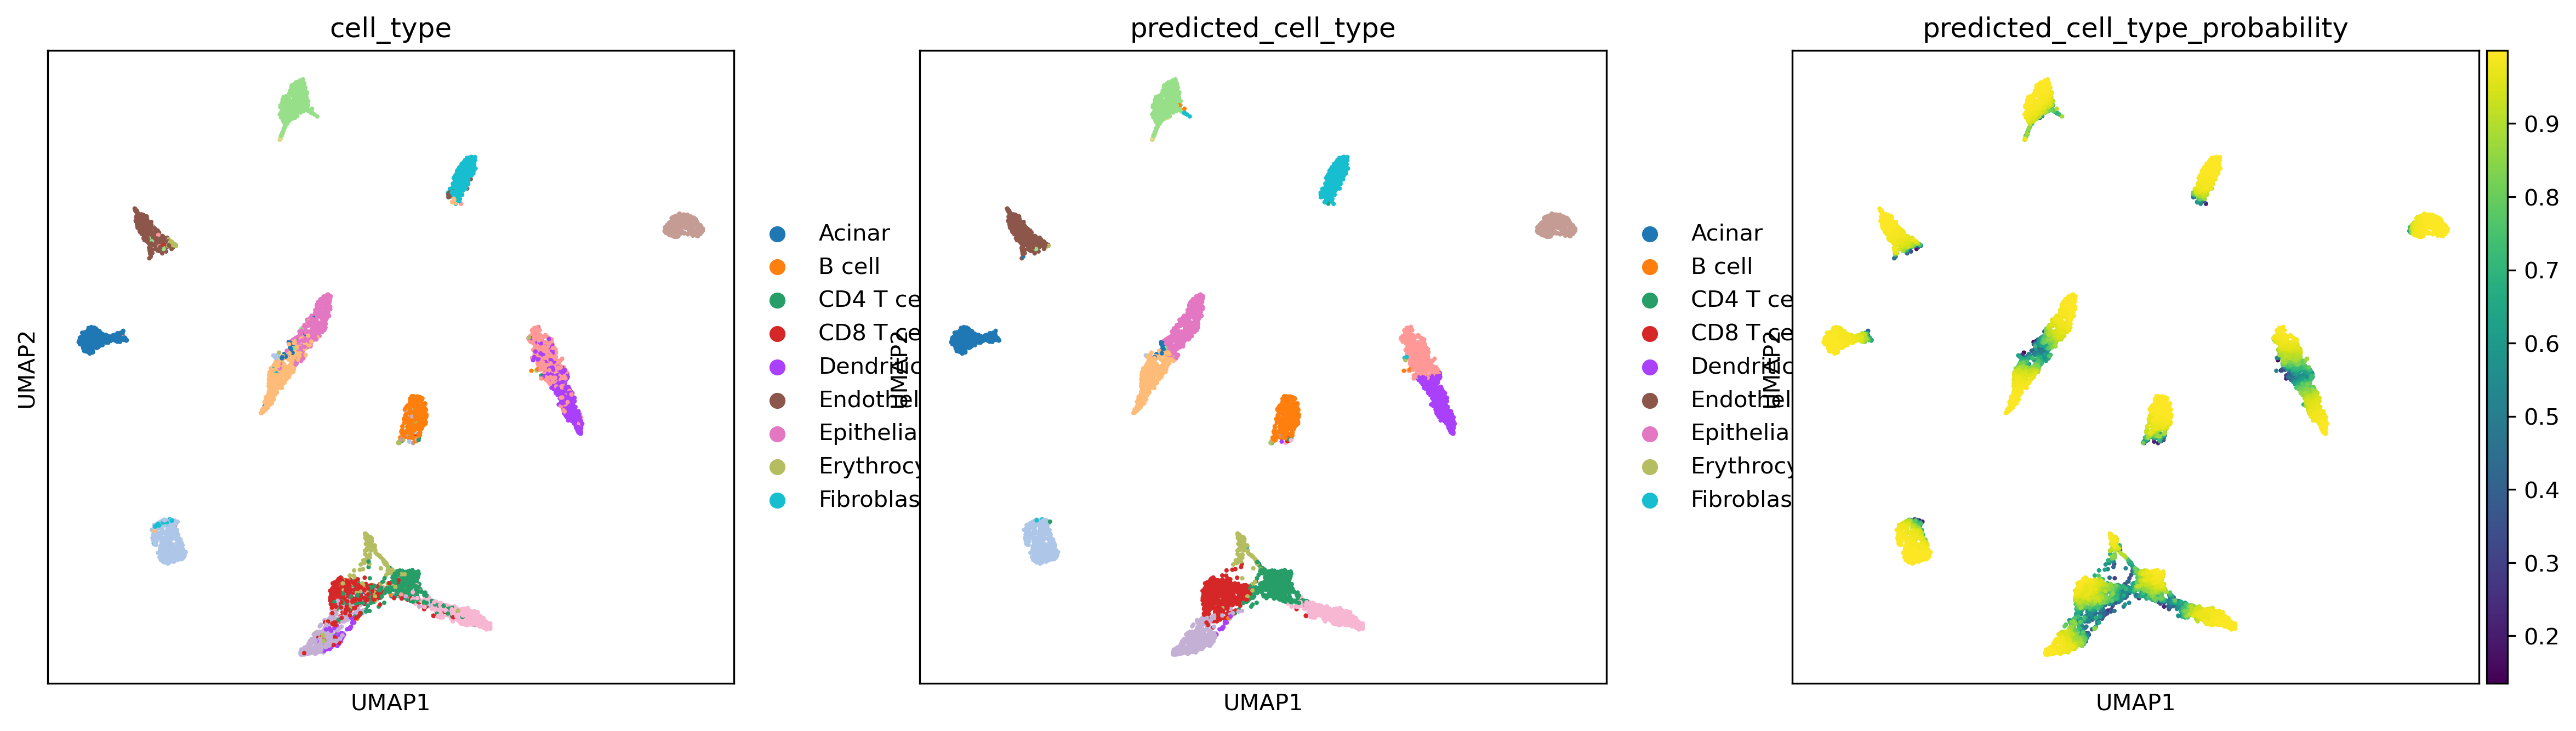

In [326]:

sc.pl.umap(a, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'], )

In [329]:
cell_types = set()
for fp in fps:
    a = sc.read_h5ad(fp)
    cell_types.update(a.obs['cell_type'].to_list())
cell_types = sorted(cell_types)
cmap = {c:x for c, x in zip(cell_types, sns.color_palette('tab20'))}
cmap

{'Acinar': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'B cell': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'CD4 T cell': (1.0, 0.4980392156862745, 0.054901960784313725),
 'CD8 T cell': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Dendritic': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Endothelial': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Epithelial': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Erythrocyte': (1.0, 0.596078431372549, 0.5882352941176471),
 'Fibroblast': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Islet': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Malignant': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'Mast': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'Monocyte': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'NK': (0.9686274509803922, 0.7137254901960784, 0.8235294117

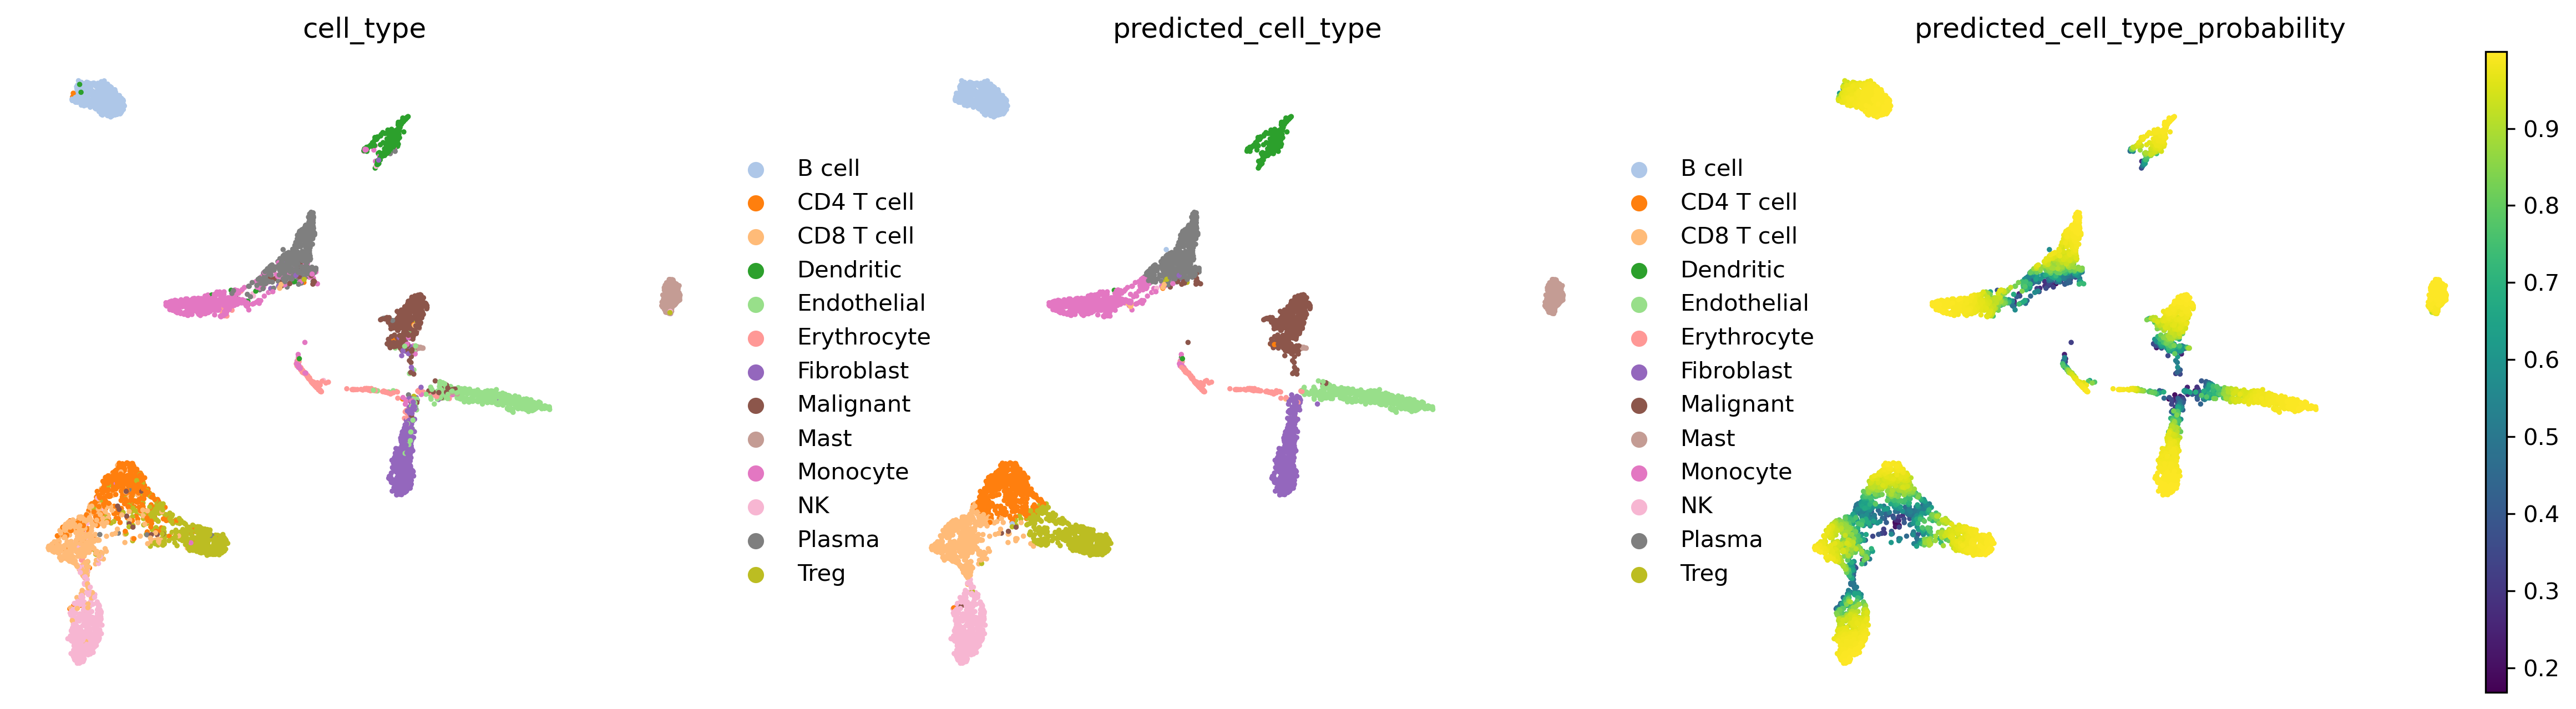

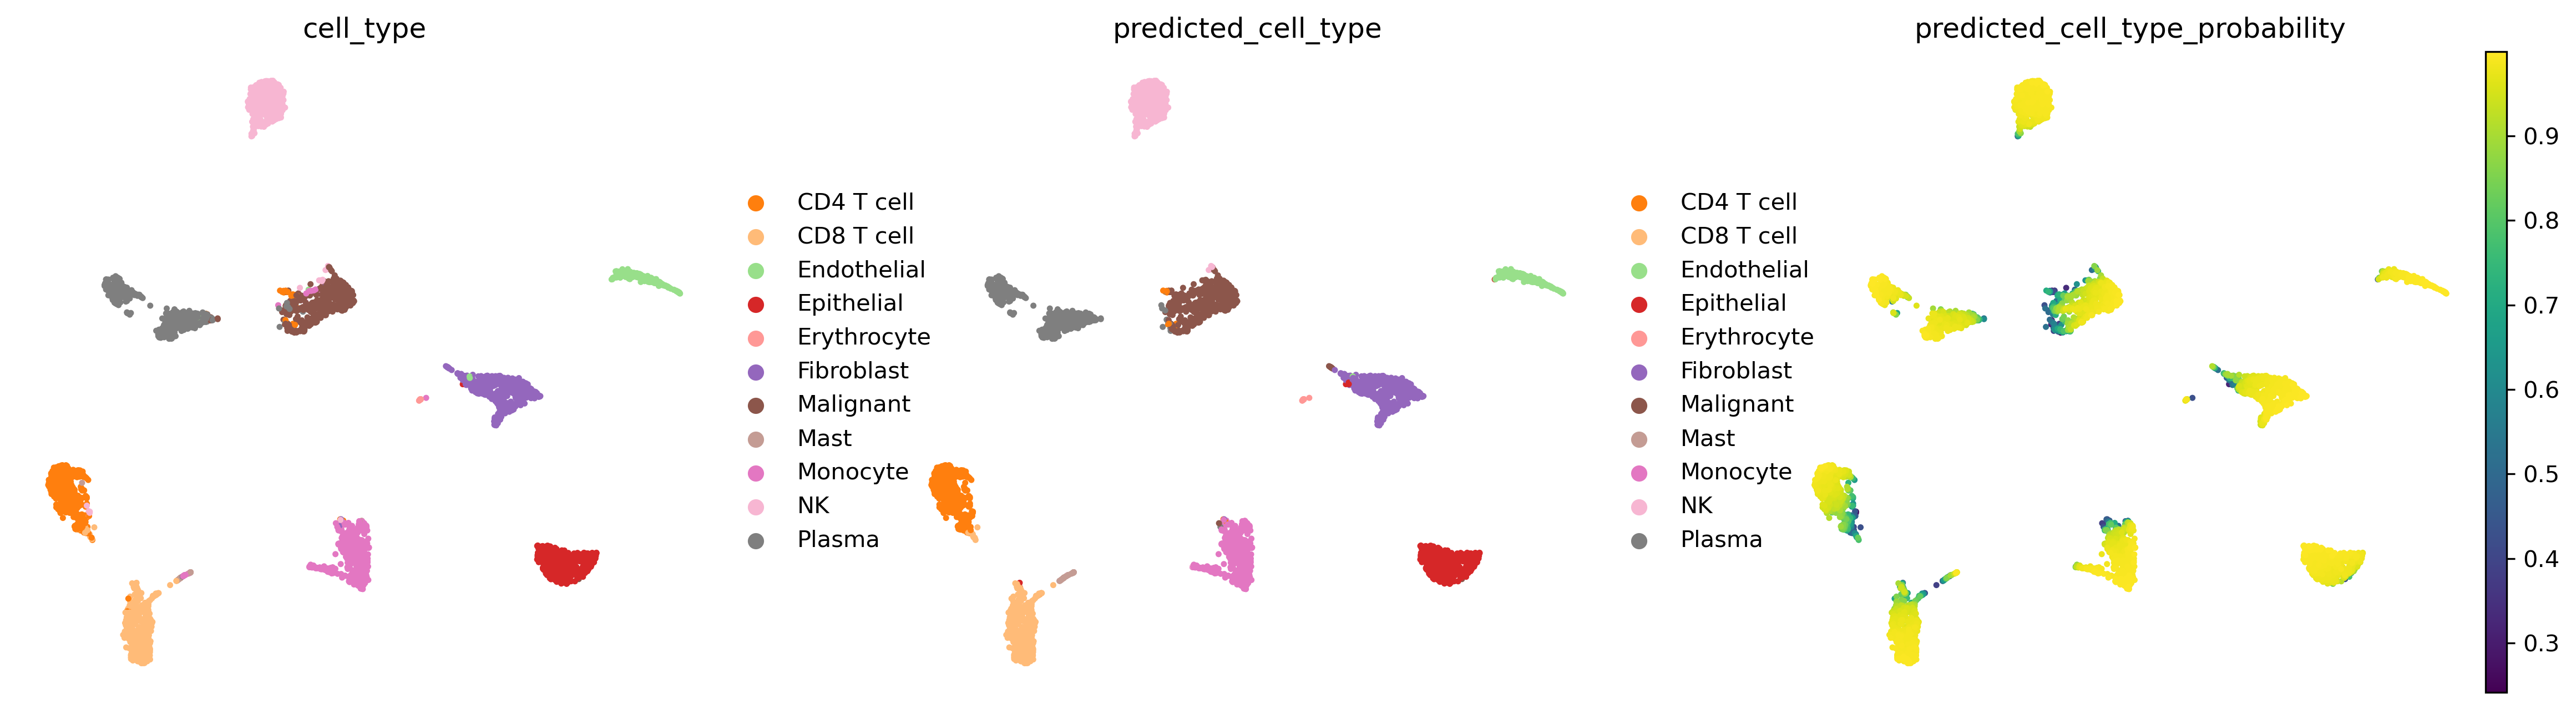

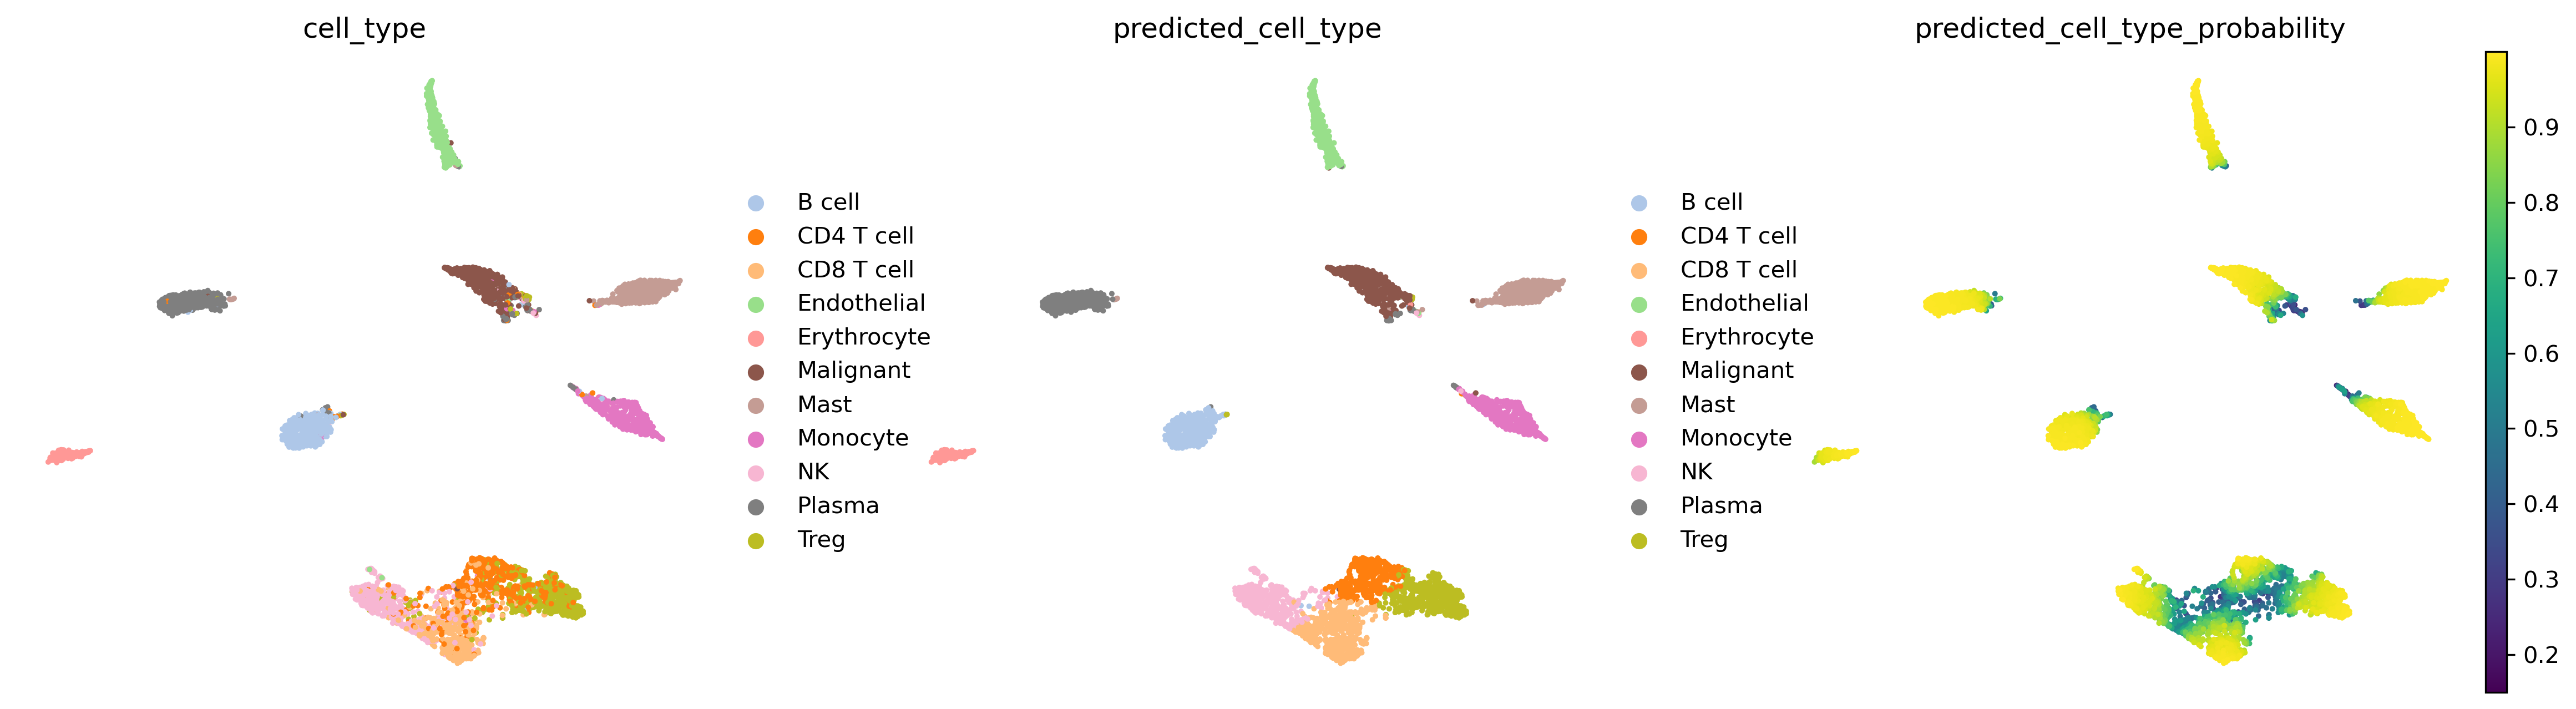

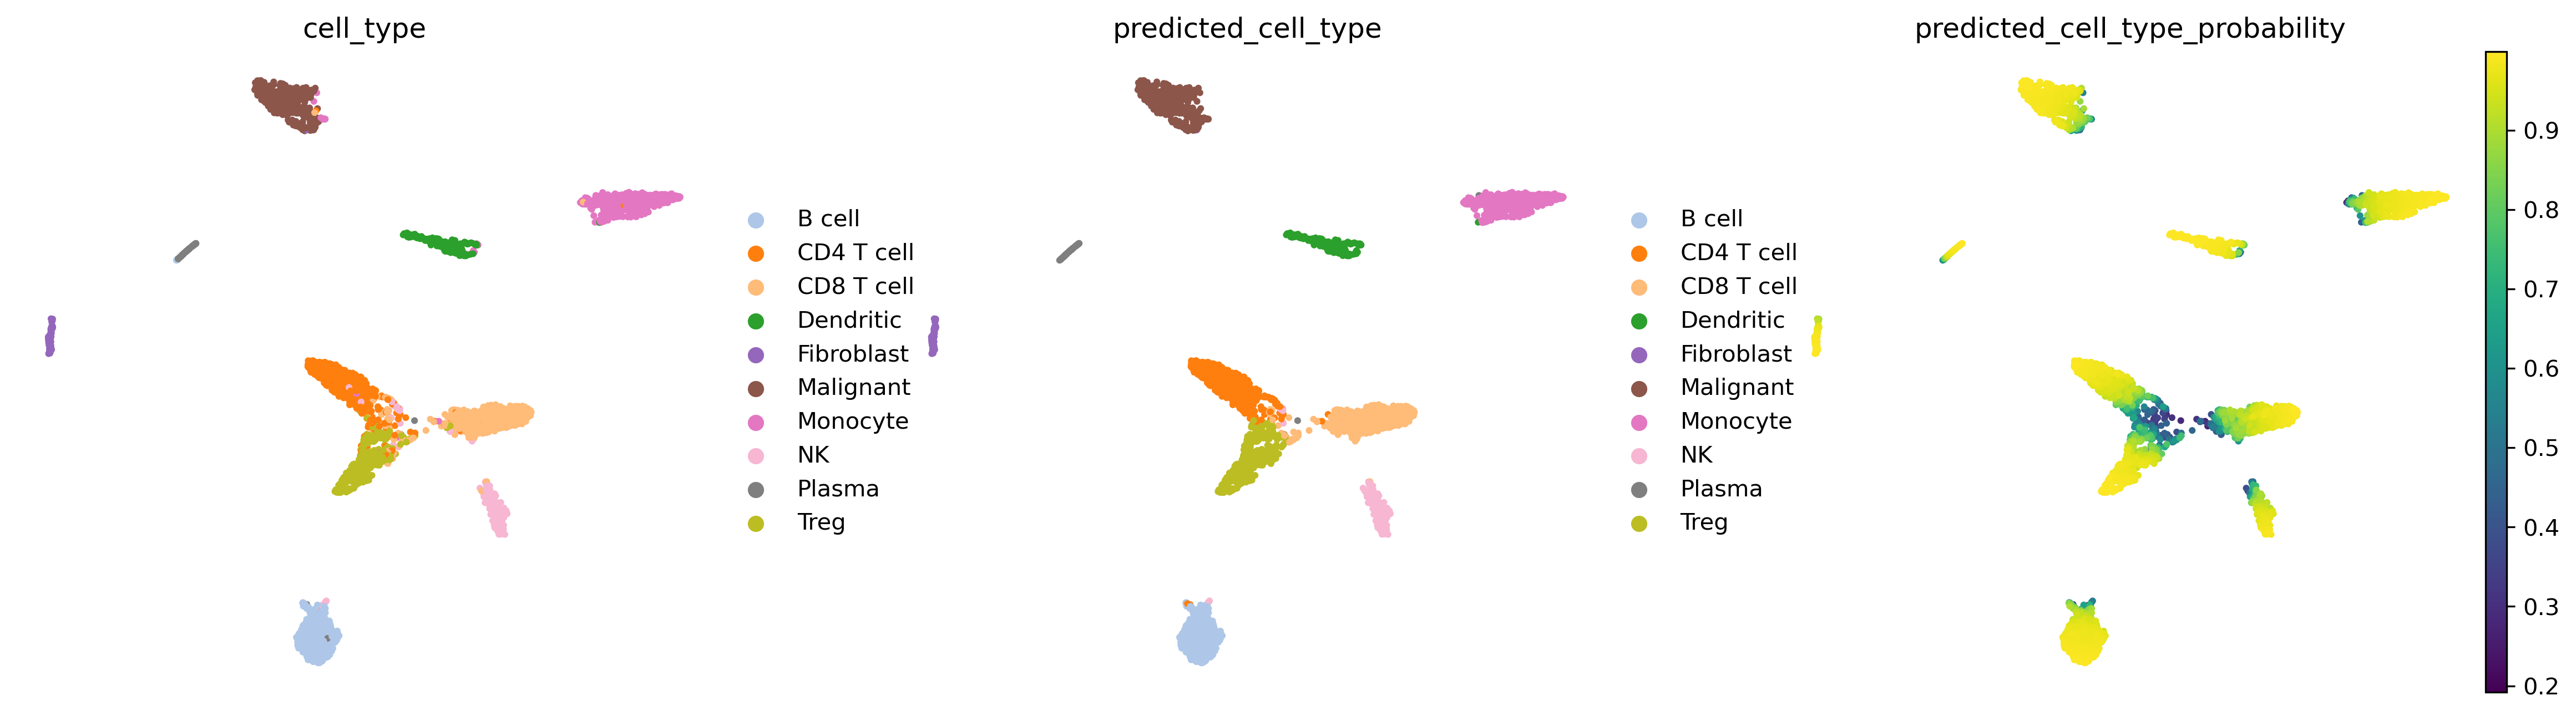

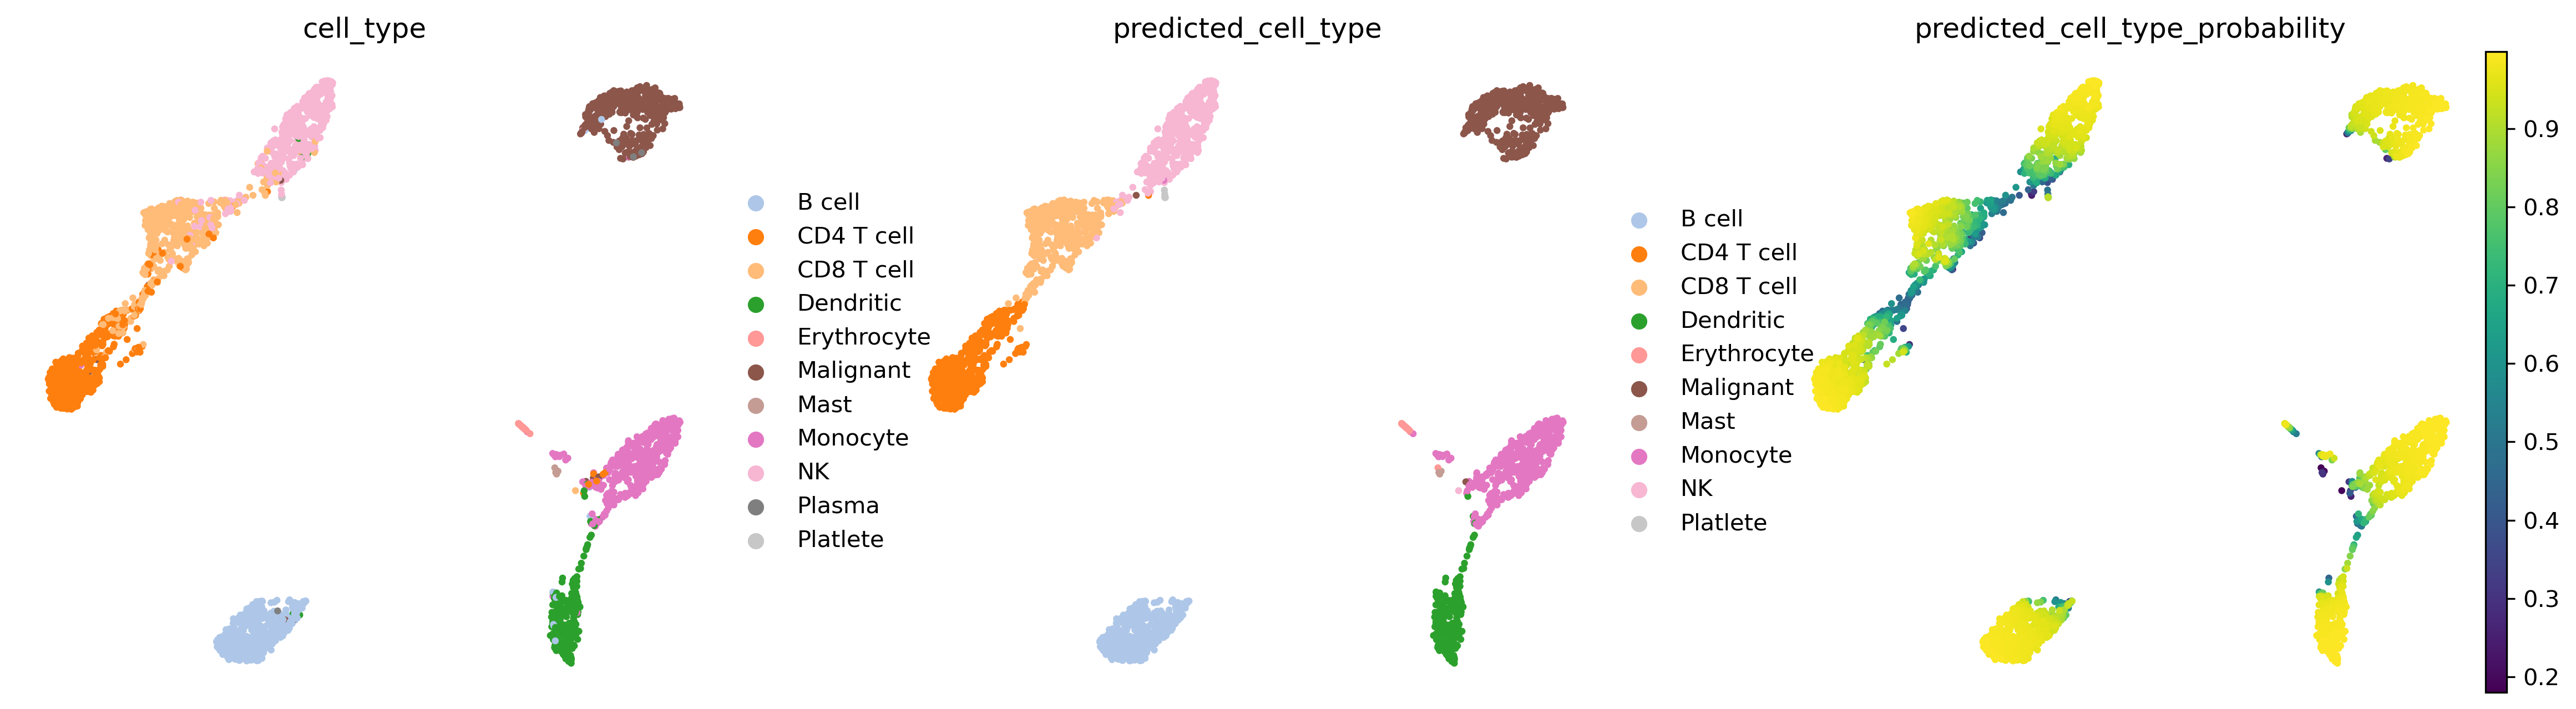

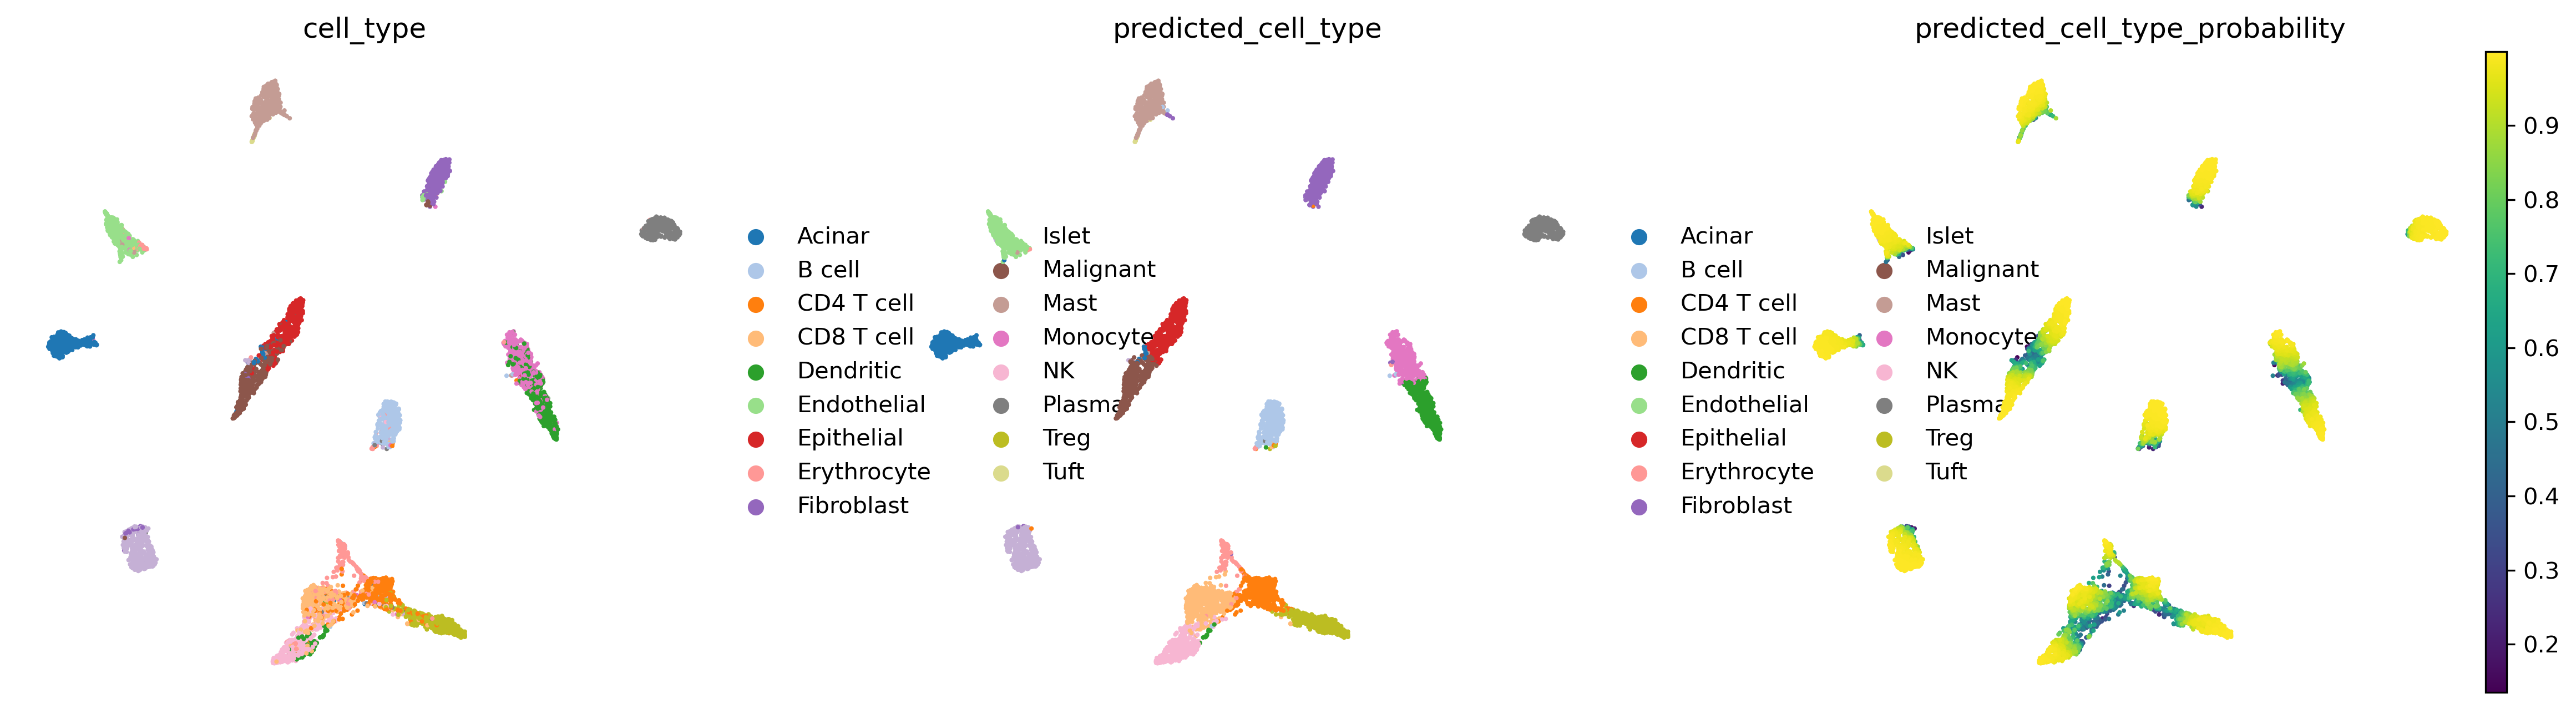

In [334]:
combined = None
for fp in fps:
    a = sc.read_h5ad(fp)
    disease = fp.split('/')[-1].replace('.h5ad', '').replace('scRNAseq_', '')
    
    sc.pl.umap(a, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'], frameon=False,
               save=f'_umap_{disease}.png', palette=cmap)
        
combined

In [317]:
# combined = None
# for fp in fps:
#     a = sc.read_h5ad(fp)
#     df = a.obs[['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability']]
#     df['UMAP1'] = a.obsm['X_umap'][:, 0]
#     df['UMAP2'] = a.obsm['X_umap'][:, 1]
#     df['disease'] = fp.split('/')[-1].replace('.h5ad', '').replace('scRNAseq_', '')
    
#     if combined is None:
#         combined = df
#     else:
#         combined = pd.concat((combined, df), axis=0)
        
# combined

In [198]:
# overlaps

In [363]:
panglao = pd.read_csv('/data/pollock/panimmune/results/explain/panglaodb_markers.txt.gz', sep='\t')
panglao = panglao[[True if 'Hs' in s else False for s in panglao['species']]]
panglao

FileNotFoundError: [Errno 2] No such file or directory: '/data/pollock/panimmune/results/explain/panglaodb_markers.txt.gz'

In [364]:
set(panglao['cell type'])

{'Acinar cells',
 'Adipocyte progenitor cells',
 'Adipocytes',
 'Adrenergic neurons',
 'Airway epithelial cells',
 'Airway goblet cells',
 'Airway smooth muscle cells',
 'Alpha cells',
 'Alveolar macrophages',
 'Anterior pituitary gland cells',
 'Astrocytes',
 'B cells',
 'B cells memory',
 'B cells naive',
 'Basal cells',
 'Basophils',
 'Bergmann glia',
 'Beta cells',
 'Cajal-Retzius cells',
 'Cardiac stem and precursor cells',
 'Cardiomyocytes',
 'Cholangiocytes',
 'Cholinergic neurons',
 'Chondrocytes',
 'Choroid plexus cells',
 'Chromaffin cells',
 'Ciliated cells',
 'Clara cells',
 'Crypt cells',
 'Decidual cells',
 'Delta cells',
 'Dendritic cells',
 'Distal tubule cells',
 'Dopaminergic neurons',
 'Ductal cells',
 'Embryonic stem cells',
 'Endothelial cells',
 'Endothelial cells (aorta)',
 'Endothelial cells (blood brain barrier)',
 'Enteric glia cells',
 'Enteric neurons',
 'Enterochromaffin cells',
 'Enterocytes',
 'Enteroendocrine cells',
 'Eosinophils',
 'Ependymal cells',
 

In [365]:
set(adata.obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',
 'CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',
 'Mast',
 'Monocyte/Macrophage',
 'NK',
 'NKT',
 'Plasma',
 'Treg',
 'cDC1',
 'cDC2',
 'pDC'}

In [382]:
overlap_map = {
    'B cell': 'B cells',
    'CD4 T cell': 'T helper cells',
    'CD4 T cell - activated': 'T helper cells',
    'CD4 T cell - exhausted': 'T helper cells',
    'CD8 T cell - CTL': 'T cytotoxic cells',
    'CD8 T cell - exhausted': 'T cytotoxic cells',
    'CD8 T cell - preexhausted': 'T cytotoxic cells',
    'CD8 T cell - proliferating': 'T cytotoxic cells',
    'Treg': 'T regulatory cells',
    'Mast': 'Mast cells',
    'Monocyte/Macrophage': 'Macrophages',
    'NK': 'NK cells',
    'NKT': 'Natural killer T cells',
    'Plasma': 'Plasma cells',
    'cDC1': 'Dendritic cells',
    'cDC2': 'Dendritic cells',
    'pDC': 'Plasmacytoid dendritic cells'
}

In [383]:
for k, v in overlap_map.items():
    p_genes = set(panglao[panglao['cell type']==v]['official gene symbol'])
    e_genes = set(adata.uns['rank_genes_groups']['names'][k][:100])
    print(k, len(p_genes), p_genes.intersection(e_genes))

B cell 98 {'BCL11A', 'SWAP70', 'FCMR', 'BANK1', 'PAX5', 'POU2AF1', 'RALGPS2', 'EBF1', 'IGHM', 'FCER2', 'CD40', 'MS4A1', 'CD79A', 'IGHD', 'TNFRSF13B', 'EAF2', 'CD79B', 'FCRLA', 'FAM129C', 'VPREB3', 'HVCN1', 'TNFRSF13C', 'SPIB', 'CD22', 'CD19', 'BLNK'}
CD4 T cell 60 {'NR3C1', 'RORA'}
CD4 T cell - activated 60 {'KLRB1', 'CCR7', 'CD40LG'}
CD4 T cell - exhausted 60 {'KLRB1', 'CD4', 'NR3C1', 'NFATC2', 'ICOS'}
CD8 T cell - CTL 8 {'CD8A'}
CD8 T cell - exhausted 8 {'CD8A'}
CD8 T cell - preexhausted 8 {'CD8A'}
CD8 T cell - proliferating 8 set()
Treg 21 {'CTLA4', 'CD4', 'FOXP3', 'IKZF2', 'TNFRSF4', 'IL2RA'}
Mast 142 {'OSBPL8', 'IL1RL1', 'TPSB2', 'CPA3', 'KIT', 'LTC4S', 'HPGDS', 'MLPH', 'BTK', 'MITF', 'SLC45A3', 'VWA5A', 'HDC', 'MS4A2', 'MAOB', 'TPSAB1', 'RGS13', 'RAB27B', 'CTSG'}
Monocyte/Macrophage 128 {'FCGR1A', 'SLC11A1', 'C5AR1', 'CLEC7A', 'TREM2', 'SLC7A7', 'FPR1', 'MS4A7', 'SLC15A3', 'GPNMB', 'LILRB4'}
NK 80 {'TXK', 'FCGR3A', 'CD247', 'KLRF1', 'ITGAM', 'NCR1', 'HOPX', 'LAIR2', 'FGFBP2', 'SP

In [389]:
data = []
for k, v in overlap_map.items():
    p_genes = set(panglao[panglao['cell type']==v]['official gene symbol'])
    e_genes = set(adata.uns['rank_genes_groups']['names'][k][:100])
    overlap = sorted(p_genes.intersection(e_genes))
    fraction = len(overlap) / len(p_genes)
    data.append([k, v, len(overlap), len(p_genes), fraction, ','.join(overlap)])
df = pd.DataFrame(data=data,
                  columns=['cell state', 'PanglaoDB cell state',
                           '# shared genes', '# PanglaoDB cell state genes', '% shared', 'shared genes'])
df = df.sort_values('% shared', ascending=False)
df


cell state          PanglaoDB cell state  # shared genes  \
8                         Treg            T regulatory cells               6   
0                       B cell                       B cells              26   
16                         pDC  Plasmacytoid dendritic cells              14   
11                          NK                      NK cells              11   
9                         Mast                    Mast cells              19   
4             CD8 T cell - CTL             T cytotoxic cells               1   
5       CD8 T cell - exhausted             T cytotoxic cells               1   
6    CD8 T cell - preexhausted             T cytotoxic cells               1   
13                      Plasma                  Plasma cells               9   
15                        cDC2               Dendritic cells              11   
10         Monocyte/Macrophage                   Macrophages              11   
3       CD4 T cell - exhausted                T helper cells               5   
2       CD4 T cell - activated                T helper cells               3   
12                         NKT        Natural killer T cells               1   
1                   CD4 T cell                T helper cells               2   
14                        cDC1               Dendritic cells               3   
7   CD8 T cell - proliferating             T cytotoxic cells               0   

    # PanglaoDB cell state genes  % shared  \
8                             21  0.285714   
0                             98  0.265306   
16                            55  0.254545   
11                            80  0.137500   
9                            142  0.133803   
4                              8  0.125000   
5                              8  0.125000   
6                              8  0.125000   
13                            86  0.104651   
15                           121  0.090909   
10                           128  0.085938   
3                             60  0.083333   
2                             60  0.050000   
12                            23  0.043478   
1                             60  0.033333   
14                           121  0.024793   
7                              8  0.000000   

                                         shared genes  
8                 CD4,CTLA4,FOXP3,IKZF2,IL2RA,TNFRSF4  
0   BANK1,BCL11A,BLNK,CD19,CD22,CD40,CD79A,CD79B,E...  
16  BCL11A,BLNK,CLEC4C,CUX2,FAM129C,IL3RA,IRF8,LAM...  
11  CD247,FCGR3A,FGFBP2,HOPX,ITGAM,KLRF1,LAIR2,NCR...  
9   BTK,CPA3,CTSG,HDC,HPGDS,IL1RL1,KIT,LTC4S,MAOB,...  
4                                                CD8A  
5                                                CD8A  
6                                                CD8A  
13  CD24,IGHA1,IGHG1,IGHG2,IGKC,JCHAIN,MS4A4A,MZB1...  
15  AXL,CD86,CLEC7A,CX3CR1,CXCL16,CXCL8,FCER1A,NR4...  
10  C5AR1,CLEC7A,FCGR1A,FPR1,GPNMB,LILRB4,MS4A7,SL...  
3                         CD4,ICOS,KLRB1,NFATC2,NR3C1  
2                                   CCR7,CD40LG,KLRB1  
12                                               GZMB  
1                                          NR3C1,RORA  
14                                   CD180,CD209,DAB2  
7

In [390]:
df.to_csv('/data/pollock/panimmune/results/explain_panglao_overlap.txt', sep='\t', index=False)

###### atac peaks


In [27]:
brca_peaks, ccrcc_peaks, gbm_peaks = (
    pd.read_csv('/data/pollock/benchmarking/results/pollock/atac_peaks/brca_clf_report.txt', sep='\t'),
    pd.read_csv('/data/pollock/benchmarking/results/pollock/atac_peaks/ccrcc_clf_report.txt', sep='\t'),
    pd.read_csv('/data/pollock/benchmarking/results/pollock/atac_peaks/gbm_clf_report.txt', sep='\t'),
)
data = [
    ['brca', 'peaks', brca_peaks.loc[2, 'macro avg']],
    ['ccrcc', 'peaks', ccrcc_peaks.loc[2, 'macro avg']],
    ['gbm', 'peaks', gbm_peaks.loc[2, 'macro avg']],
]
df = pd.DataFrame(data=data, columns=['disease', 'method', 'f1-score'])

brca_g, ccrcc_g, gbm_g = (
    pd.read_csv('/data/pollock/benchmarking/results/pollock/snATACseq_brca_clf_report.txt', sep='\t'),
    pd.read_csv('/data/pollock/benchmarking/results/pollock/snATACseq_ccrcc_clf_report.txt', sep='\t'),
    pd.read_csv('/data/pollock/benchmarking/results/pollock/snATACseq_gbm_clf_report.txt', sep='\t'),
)
data = [
    ['brca', 'gene_activity', brca_g.loc[2, 'macro avg']],
    ['ccrcc', 'gene_activity', ccrcc_g.loc[2, 'macro avg']],
    ['gbm', 'gene_activity', gbm_g.loc[2, 'macro avg']],
]
df2 = pd.DataFrame(data=data, columns=['disease', 'method', 'f1-score'])


df = pd.concat((df, df2), axis=0)

df

disease         method  f1-score
0    brca          peaks  0.923079
1   ccrcc          peaks  0.864569
2     gbm          peaks  0.906559
0    brca  gene_activity  0.903782
1   ccrcc  gene_activity  0.949591
2     gbm  gene_activity  0.929578

In [30]:
chart = make_point_chart(df, show_axis=True if i==2 else False, scale_domain=[.84, .96]) + make_tick_chart(df, title=dtype, show_axis=True if i==2 else False, scale_domain=[.84, .96])
#     chart = make_chart(df, title=dtype, show_axis=True if i==2 else False, color=sns.color_palette().as_hex()[i])
chart



alt.LayerChart(...)

###### benchmarking with folds

In [31]:
result_dir = '/data/pollock/benchmarking/results/'
tools = ['actinn', 'mlp', 'pollock', 'scanpy', 'seurat', 'singlecellnet', 'svm_linear']

In [39]:
to_results = {}
for tool in tools:
    print(tool)
    fps = sorted(listfiles(os.path.join(result_dir, tool), regex=r'clf_report.txt$'))
    fps = [fp for fp in fps if 'interdataset_with_folds' in fp]
    print(len(fps))
    fps = [fp for fp in fps if fp.split('/')[-3]==tool]
    to_results[tool] = {}
    for fp in fps:
        root = fp.split('/')[-1].split('_clf_report')[0]
        root = root.replace('_gene_activity', '')
        dtype, disease, fold = root.split('_')
        
        if dtype not in to_results[tool]:
            to_results[tool][dtype] = {}
        if disease not in to_results[tool][dtype]:
            to_results[tool][dtype][disease] = {}
            
        to_results[tool][dtype][disease][fold] = pd.read_csv(fp, sep='\t', index_col=0)
to_results['pollock']['scRNAseq']['brca']['fold0']

actinn
55
mlp
60
pollock
60
scanpy
60
seurat
59
singlecellnet
59
svm_linear
60


B cell  CD4 T cell  CD8 T cell   Dendritic  Endothelial  \
metric                                                                   
precision    0.993927    0.815195    0.771084    0.805556     0.965591   
recall       0.982000    0.794000    0.768000    0.974790     0.898000   
f1-score     0.987928    0.804458    0.769539    0.882129     0.930570   
support    500.000000  500.000000  500.000000  119.000000   500.000000   

           Erythrocyte  Fibroblast   Malignant        Mast    Monocyte  \
metric                                                                   
precision     0.786325    0.927593    0.855984    0.979508    0.898520   
recall        0.893204    0.948000    0.844000    0.971545    0.850000   
f1-score      0.836364    0.937685    0.849950    0.975510    0.873587   
support     103.000000  500.000000  500.000000  246.000000  500.000000   

                  NK      Plasma        Treg  accuracy    macro avg  \
metric                                                                
precision    0.91875    0.834915    0.857944  0.883138     0.877761   
recall       0.88200    0.880000    0.918000  0.883138     0.892580   
f1-score     0.90000    0.856865    0.886957  0.883138     0.883965   
support    500.00000  500.000000  500.000000  0.883138  5468.000000   

           weighted avg  
metric                   
precision      0.884704  
recall         0.883138  
f1-score       0.883296  
support     5468.000000

In [42]:
data = []
for tool, d1 in to_results.items():
    for dtype, d2 in d1.items():
        for disease, d3 in d2.items():
            for fold, df in d3.items():
                f1 = df.loc['f1-score', 'macro avg']
                data.append([tool, dtype, disease, fold, f1])
df = pd.DataFrame(data=data, columns=['tool', 'dtype', 'disease', 'fold', 'f1-score'])
df

tool     dtype disease   fold  f1-score
0        actinn  scRNAseq    brca  fold0  0.892302
1        actinn  scRNAseq    brca  fold1  0.895623
2        actinn  scRNAseq    brca  fold2  0.899348
3        actinn  scRNAseq    brca  fold3  0.883937
4        actinn  scRNAseq    brca  fold4  0.884779
..          ...       ...     ...    ...       ...
408  svm_linear  snRNAseq     gbm  fold0  0.979209
409  svm_linear  snRNAseq     gbm  fold1  0.980235
410  svm_linear  snRNAseq     gbm  fold2  0.983760
411  svm_linear  snRNAseq     gbm  fold3  0.981487
412  svm_linear  snRNAseq     gbm  fold4  0.980106

[413 rows x 5 columns]

2022-03-30 07:42:13,713 maxp pruned
2022-03-30 07:42:13,723 cmap pruned
2022-03-30 07:42:13,724 kern dropped
2022-03-30 07:42:13,724 post pruned
2022-03-30 07:42:13,725 FFTM dropped
2022-03-30 07:42:13,728 GPOS pruned
2022-03-30 07:42:13,734 GSUB pruned
2022-03-30 07:42:13,735 name pruned
2022-03-30 07:42:13,745 glyf pruned
2022-03-30 07:42:13,747 Added gid0 to subset
2022-03-30 07:42:13,748 Added first four glyphs to subset
2022-03-30 07:42:13,748 Closing glyph list over 'GSUB': 33 glyphs before
2022-03-30 07:42:13,749 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:13,750 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 24, 27, 28, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:13,757 Closed glyph list over 'GSUB': 38 glyphs a

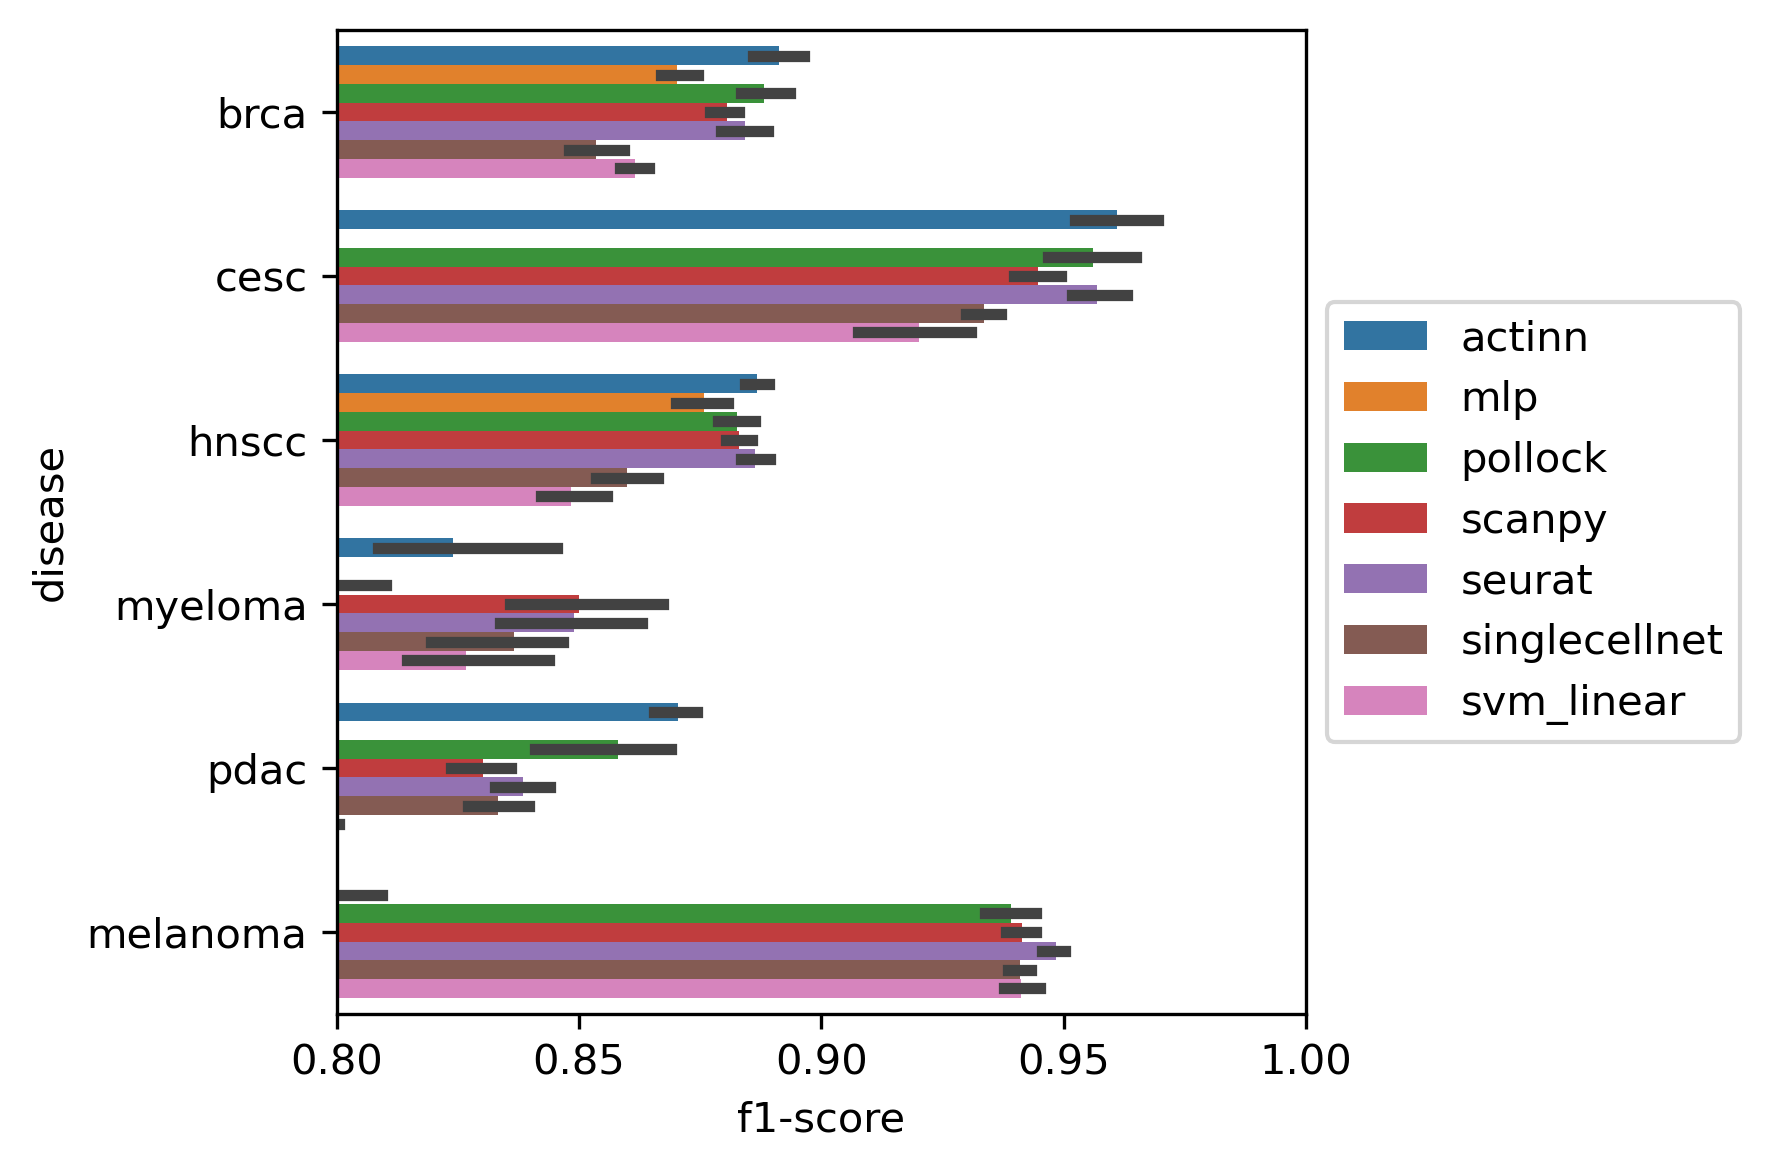

2022-03-30 07:42:14,909 maxp pruned
2022-03-30 07:42:14,918 cmap pruned
2022-03-30 07:42:14,919 kern dropped
2022-03-30 07:42:14,920 post pruned
2022-03-30 07:42:14,921 FFTM dropped
2022-03-30 07:42:14,924 GPOS pruned
2022-03-30 07:42:14,930 GSUB pruned
2022-03-30 07:42:14,932 name pruned
2022-03-30 07:42:15,140 glyf pruned
2022-03-30 07:42:15,142 Added gid0 to subset
2022-03-30 07:42:15,143 Added first four glyphs to subset
2022-03-30 07:42:15,143 Closing glyph list over 'GSUB': 34 glyphs before
2022-03-30 07:42:15,144 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:15,145 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 25, 27, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:15,149 Closed glyph list over 'GSUB': 3

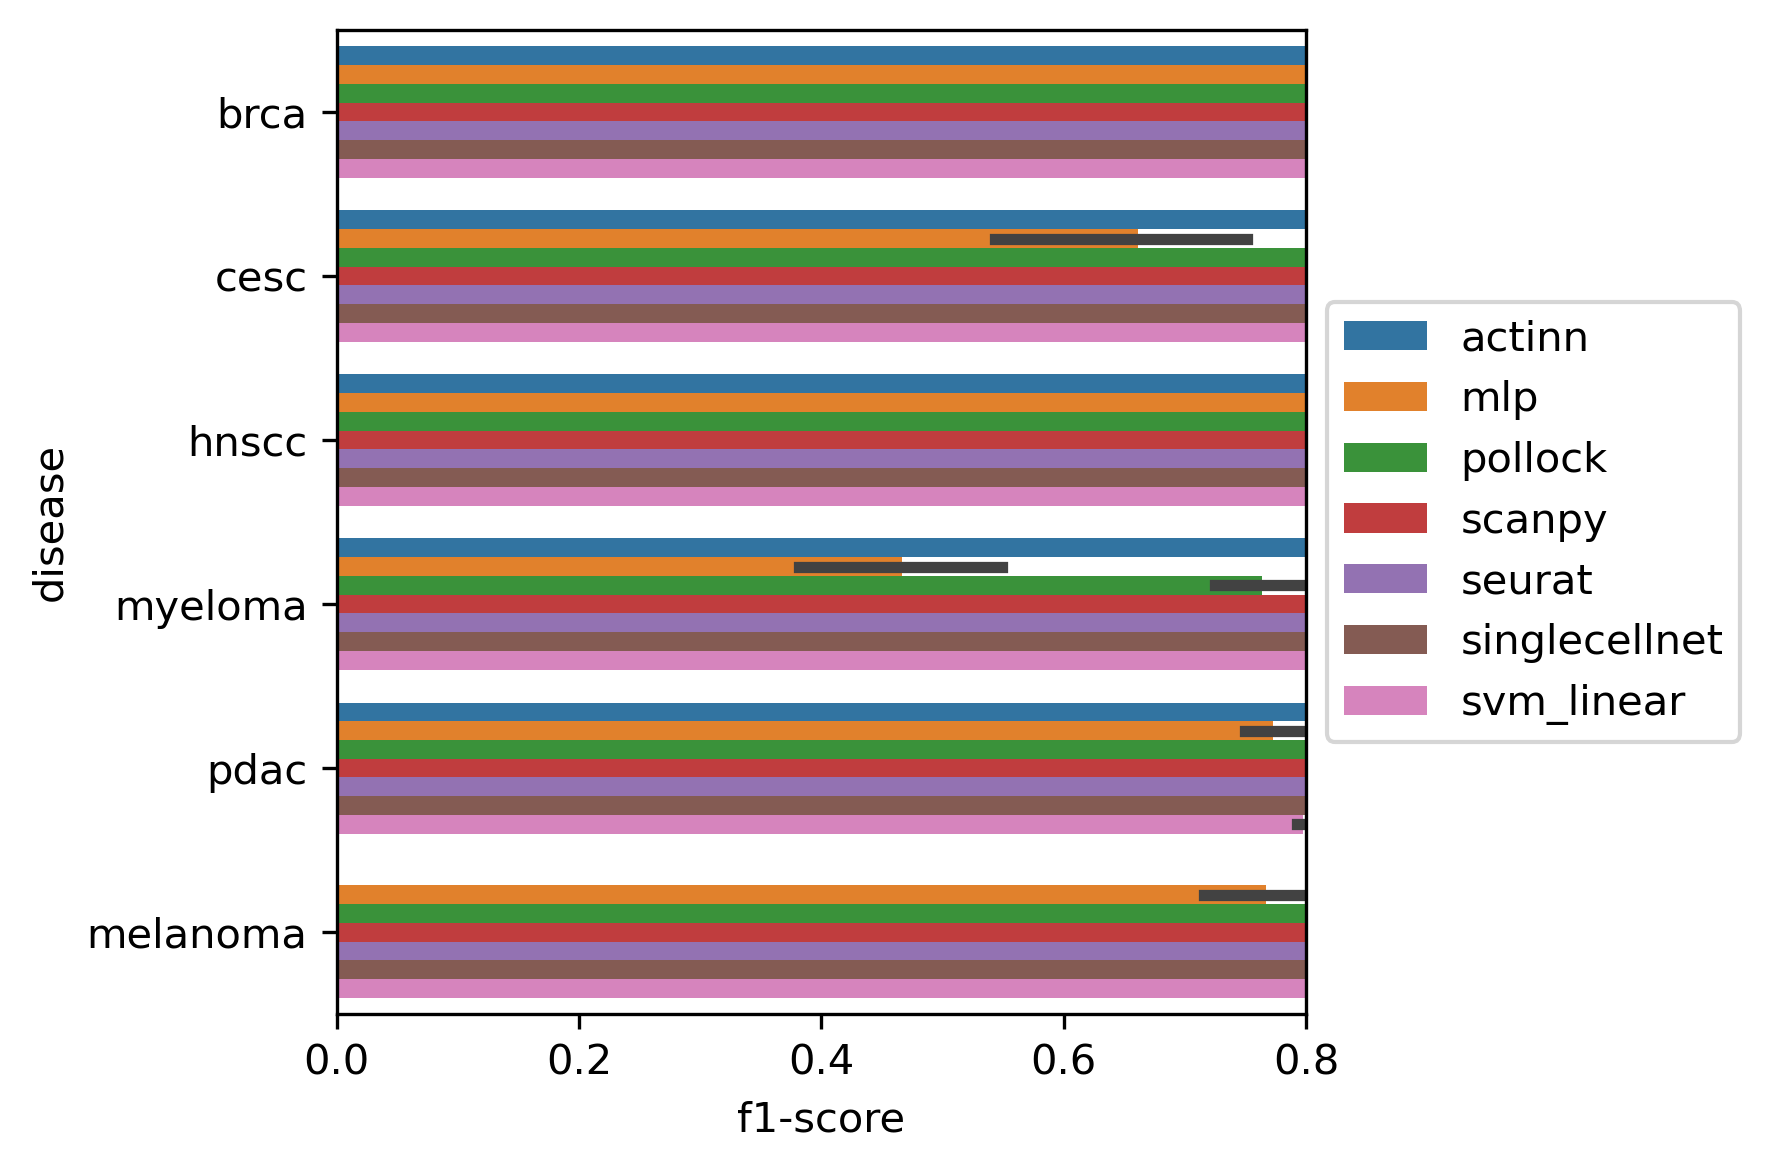

2022-03-30 07:42:15,923 maxp pruned
2022-03-30 07:42:15,934 cmap pruned
2022-03-30 07:42:15,935 kern dropped
2022-03-30 07:42:15,935 post pruned
2022-03-30 07:42:15,936 FFTM dropped
2022-03-30 07:42:15,939 GPOS pruned
2022-03-30 07:42:15,947 GSUB pruned
2022-03-30 07:42:15,948 name pruned
2022-03-30 07:42:15,958 glyf pruned
2022-03-30 07:42:15,960 Added gid0 to subset
2022-03-30 07:42:15,961 Added first four glyphs to subset
2022-03-30 07:42:15,962 Closing glyph list over 'GSUB': 34 glyphs before
2022-03-30 07:42:15,962 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:15,964 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 26, 27, 28, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:15,971 Closed glyph list over 'GSU

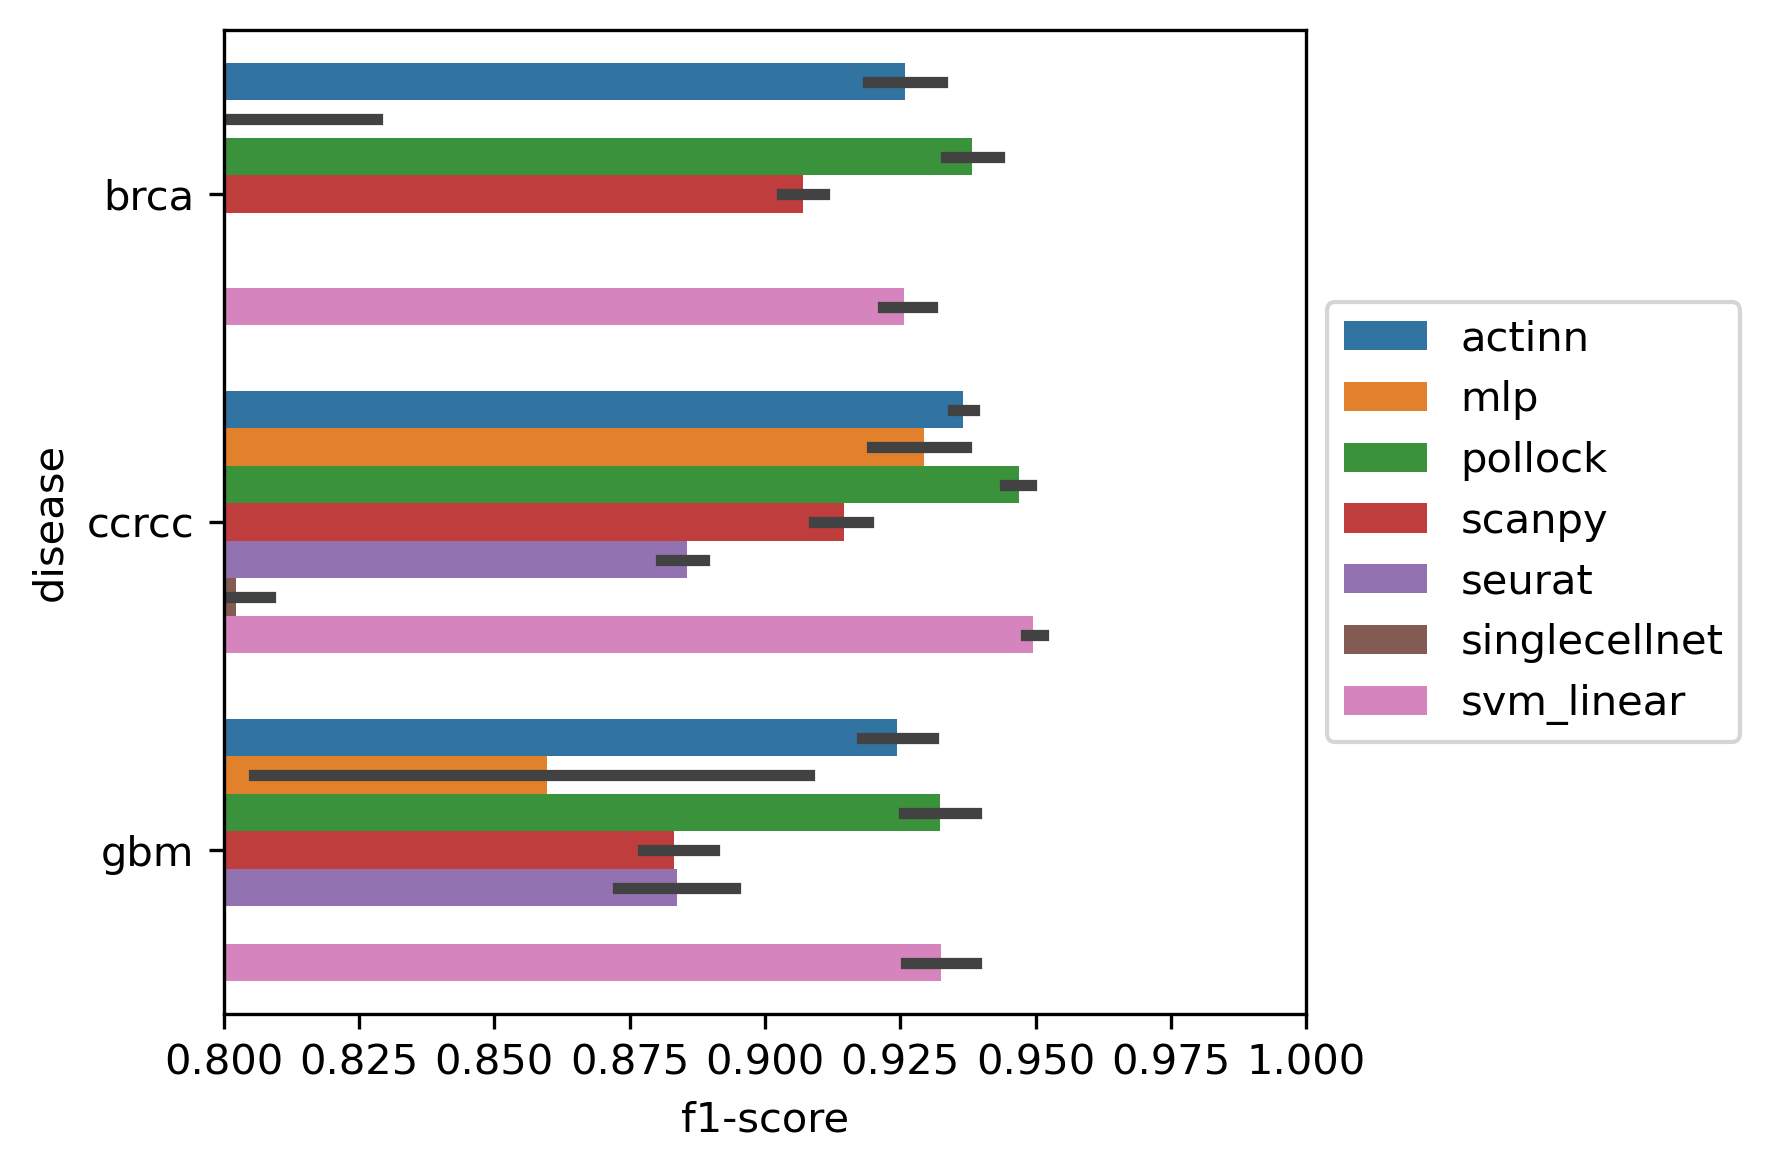

2022-03-30 07:42:16,734 maxp pruned
2022-03-30 07:42:16,744 cmap pruned
2022-03-30 07:42:16,745 kern dropped
2022-03-30 07:42:16,746 post pruned
2022-03-30 07:42:16,746 FFTM dropped
2022-03-30 07:42:16,750 GPOS pruned
2022-03-30 07:42:16,758 GSUB pruned
2022-03-30 07:42:16,759 name pruned
2022-03-30 07:42:16,769 glyf pruned
2022-03-30 07:42:16,771 Added gid0 to subset
2022-03-30 07:42:16,771 Added first four glyphs to subset
2022-03-30 07:42:16,772 Closing glyph list over 'GSUB': 36 glyphs before
2022-03-30 07:42:16,773 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:16,774 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:16,781 Clo

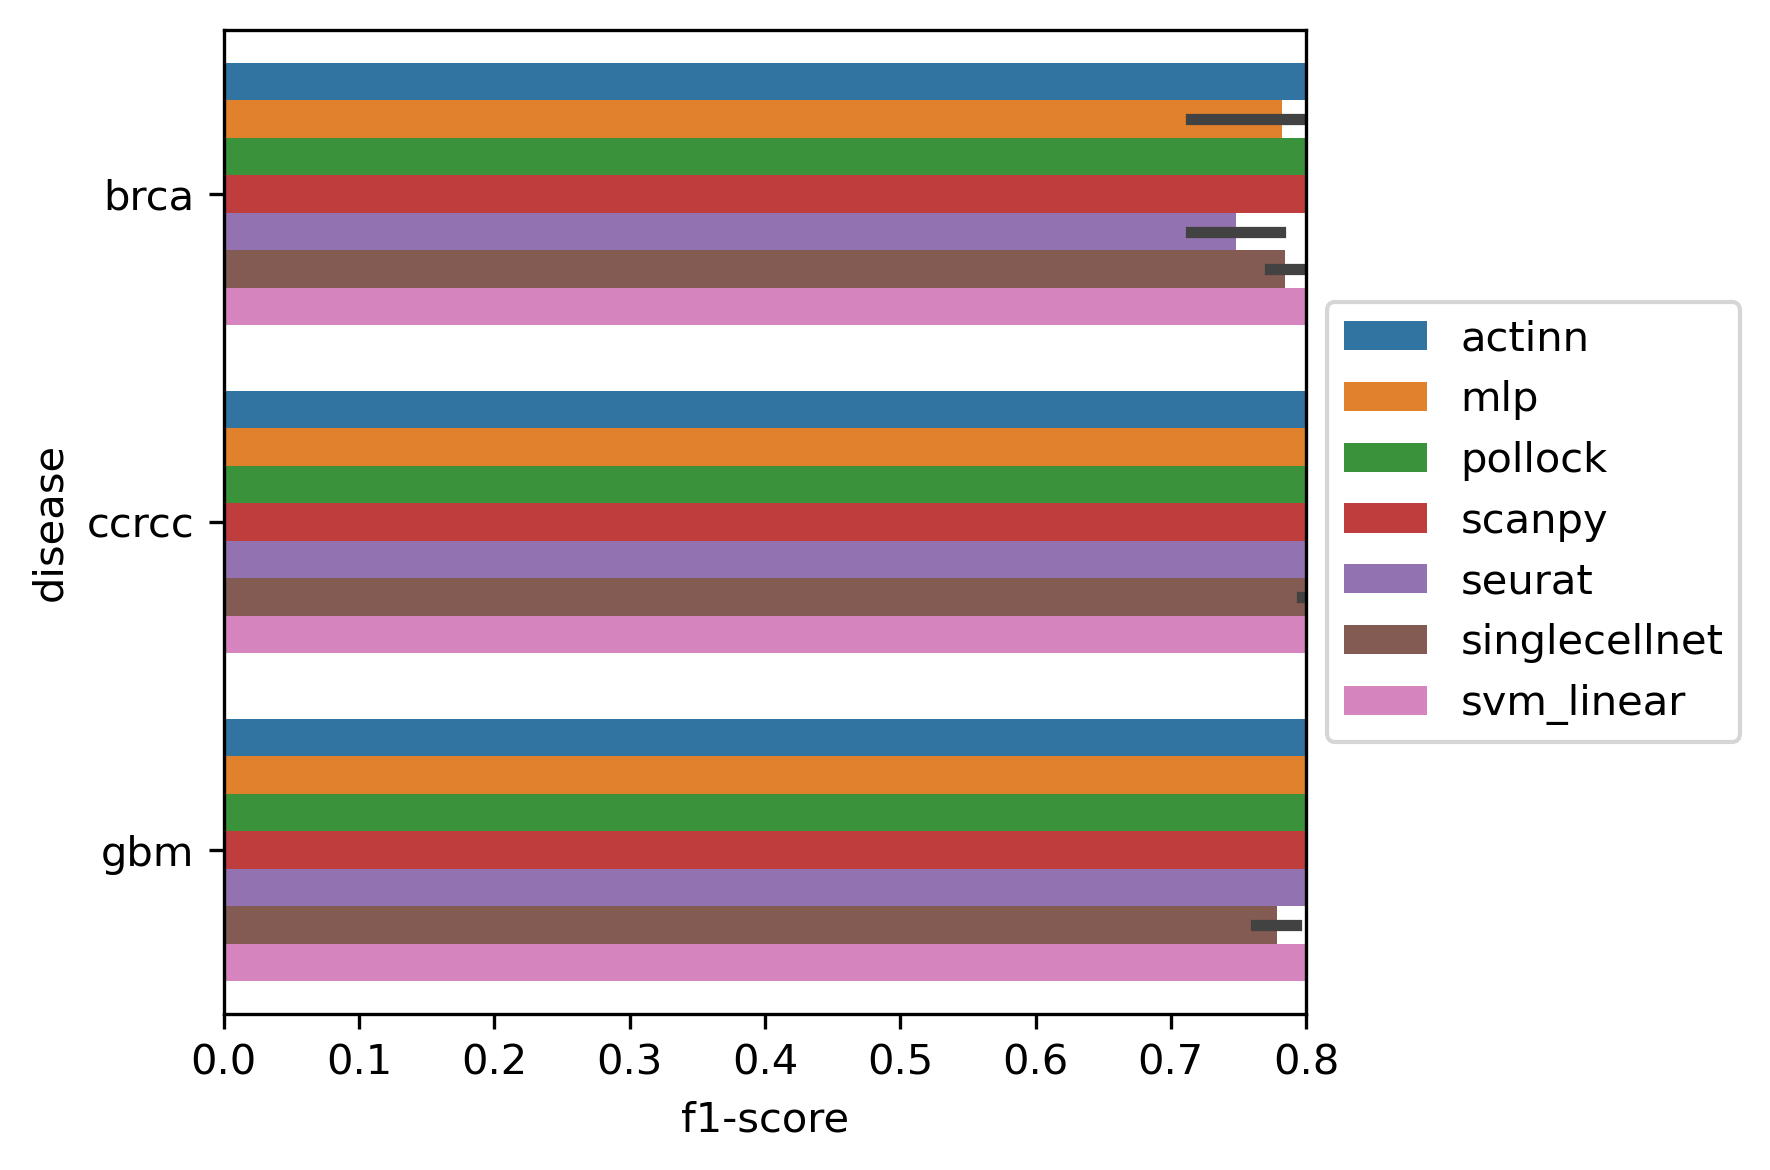

2022-03-30 07:42:17,558 maxp pruned
2022-03-30 07:42:17,569 cmap pruned
2022-03-30 07:42:17,570 kern dropped
2022-03-30 07:42:17,570 post pruned
2022-03-30 07:42:17,571 FFTM dropped
2022-03-30 07:42:17,575 GPOS pruned
2022-03-30 07:42:17,583 GSUB pruned
2022-03-30 07:42:17,584 name pruned
2022-03-30 07:42:17,595 glyf pruned
2022-03-30 07:42:17,597 Added gid0 to subset
2022-03-30 07:42:17,598 Added first four glyphs to subset
2022-03-30 07:42:17,598 Closing glyph list over 'GSUB': 34 glyphs before
2022-03-30 07:42:17,599 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:17,601 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 26, 27, 28, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:17,607 Closed glyph list over 'GSU

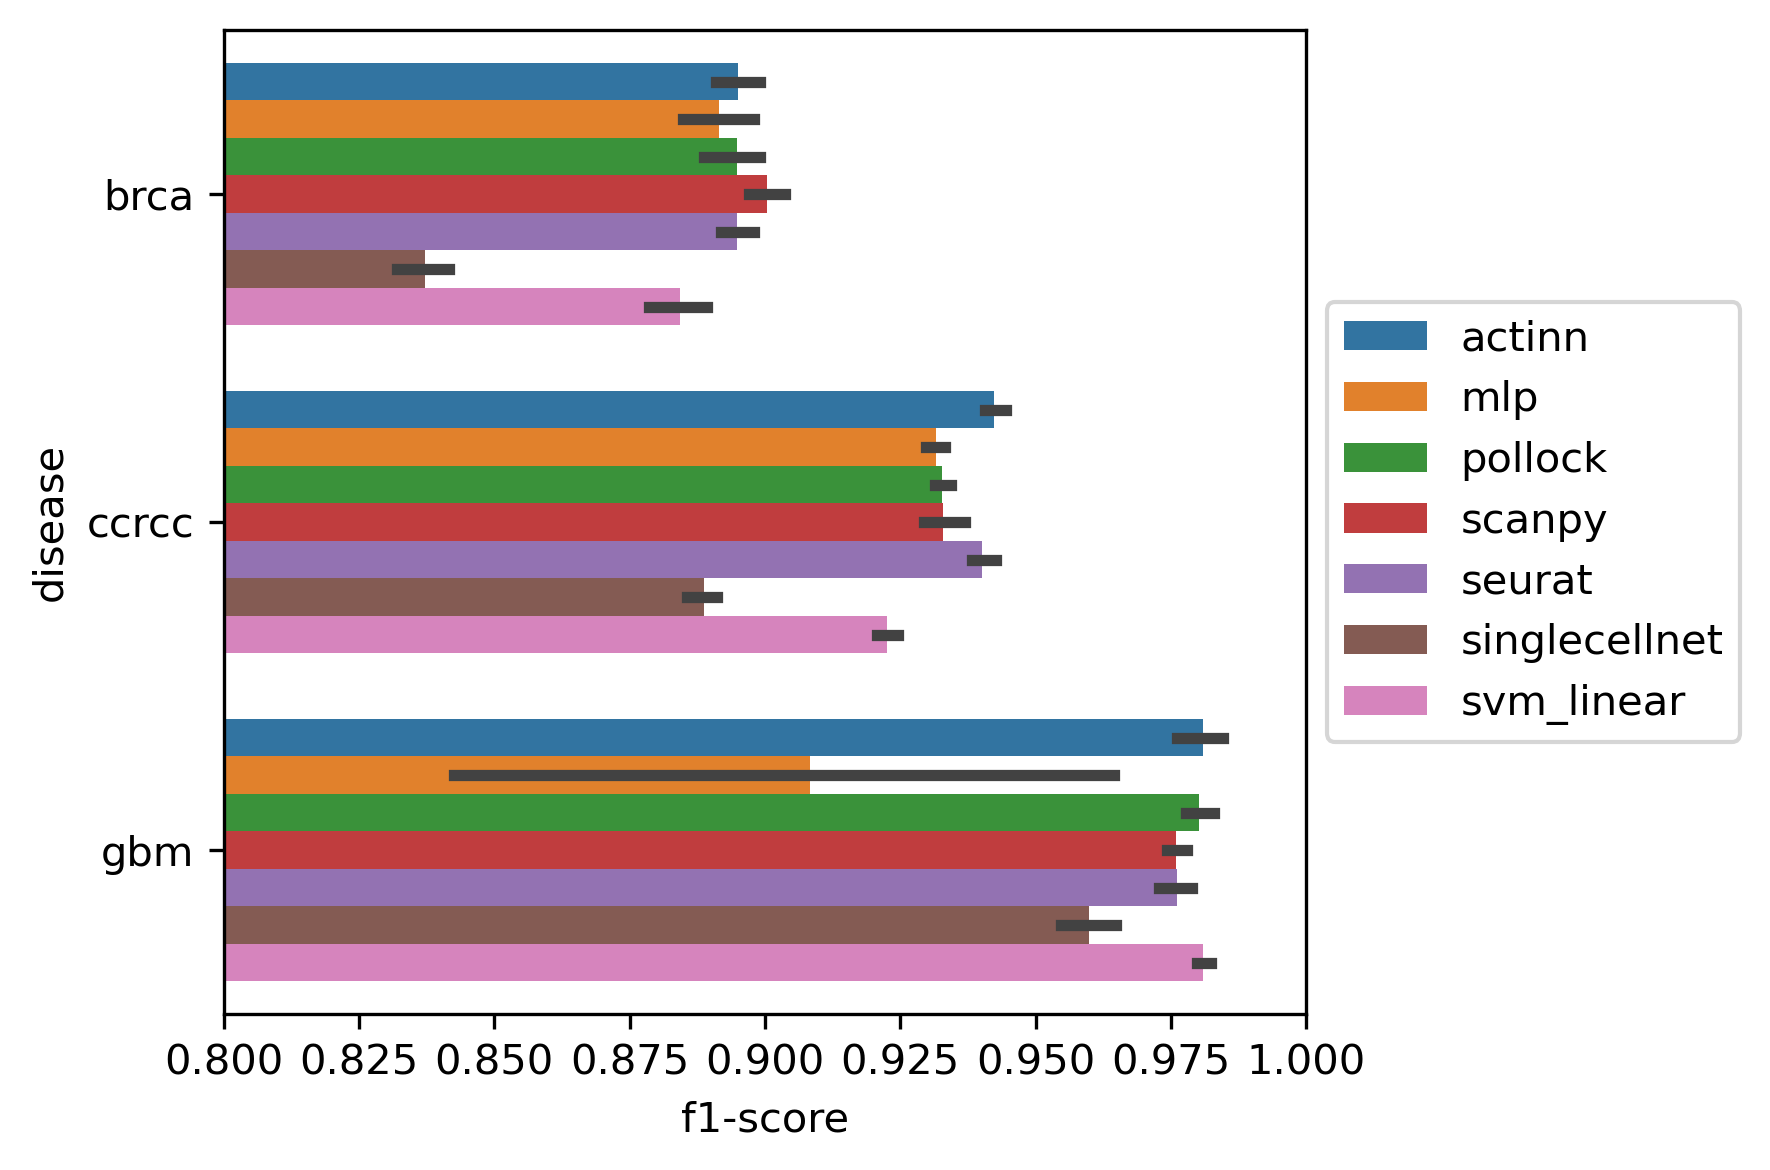

2022-03-30 07:42:18,380 maxp pruned
2022-03-30 07:42:18,394 cmap pruned
2022-03-30 07:42:18,395 kern dropped
2022-03-30 07:42:18,396 post pruned
2022-03-30 07:42:18,397 FFTM dropped
2022-03-30 07:42:18,400 GPOS pruned
2022-03-30 07:42:18,404 GSUB pruned
2022-03-30 07:42:18,406 name pruned
2022-03-30 07:42:18,416 glyf pruned
2022-03-30 07:42:18,418 Added gid0 to subset
2022-03-30 07:42:18,419 Added first four glyphs to subset
2022-03-30 07:42:18,419 Closing glyph list over 'GSUB': 36 glyphs before
2022-03-30 07:42:18,420 Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2022-03-30 07:42:18,422 Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
2022-03-30 07:42:18,429 Clo

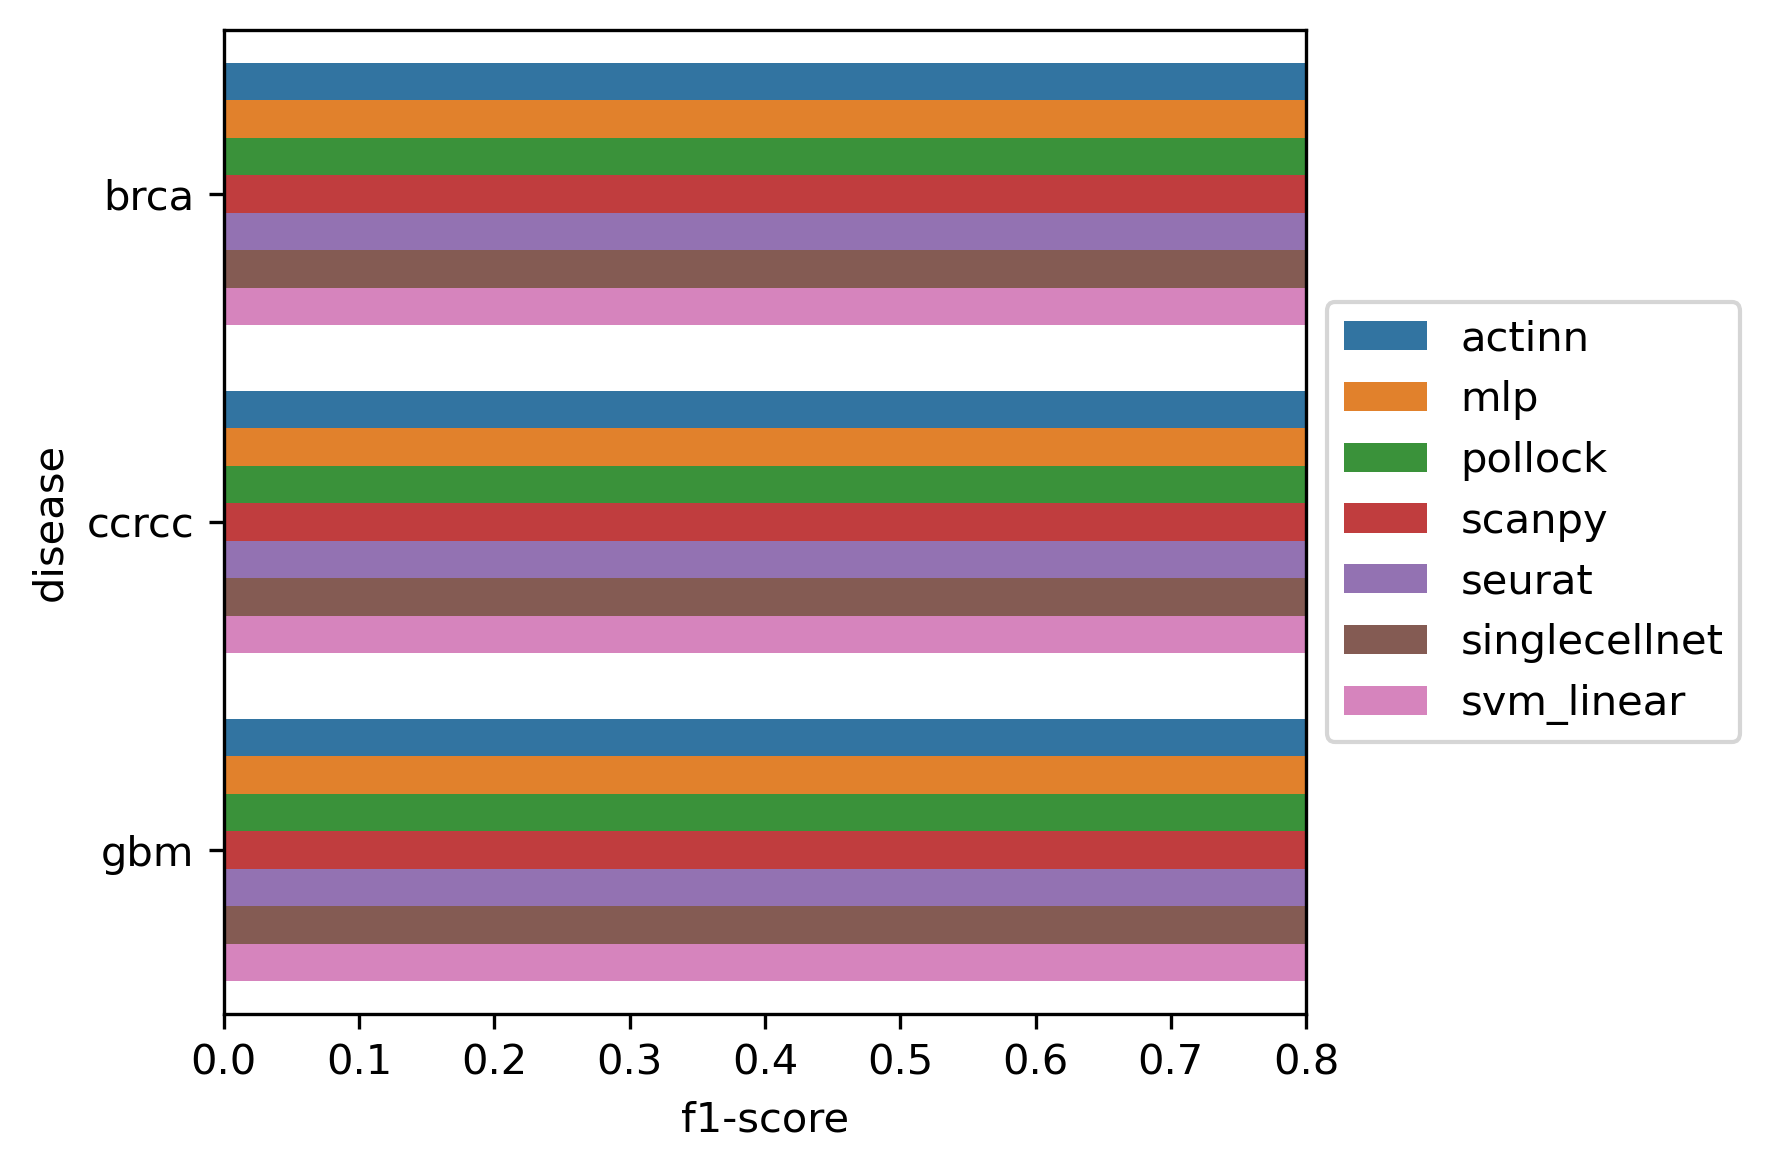

In [52]:
for dtype in sorted(set(df['dtype'])):
    f = df[df['dtype']==dtype]
    ax = sns.barplot(data=f, y='disease', x='f1-score', hue='tool', orient='h')
    ax.set_xlim((.8, 1.))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f'/data/pollock/benchmarking/figures/benchmarking_barplot_{dtype}_right.pdf')
    plt.show()
    
    ax = sns.barplot(data=f, y='disease', x='f1-score', hue='tool', orient='h')
    ax.set_xlim((0, .8))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f'/data/pollock/benchmarking/figures/benchmarking_barplot_{dtype}_left.pdf')
    plt.show()

(0.8, 1.0)

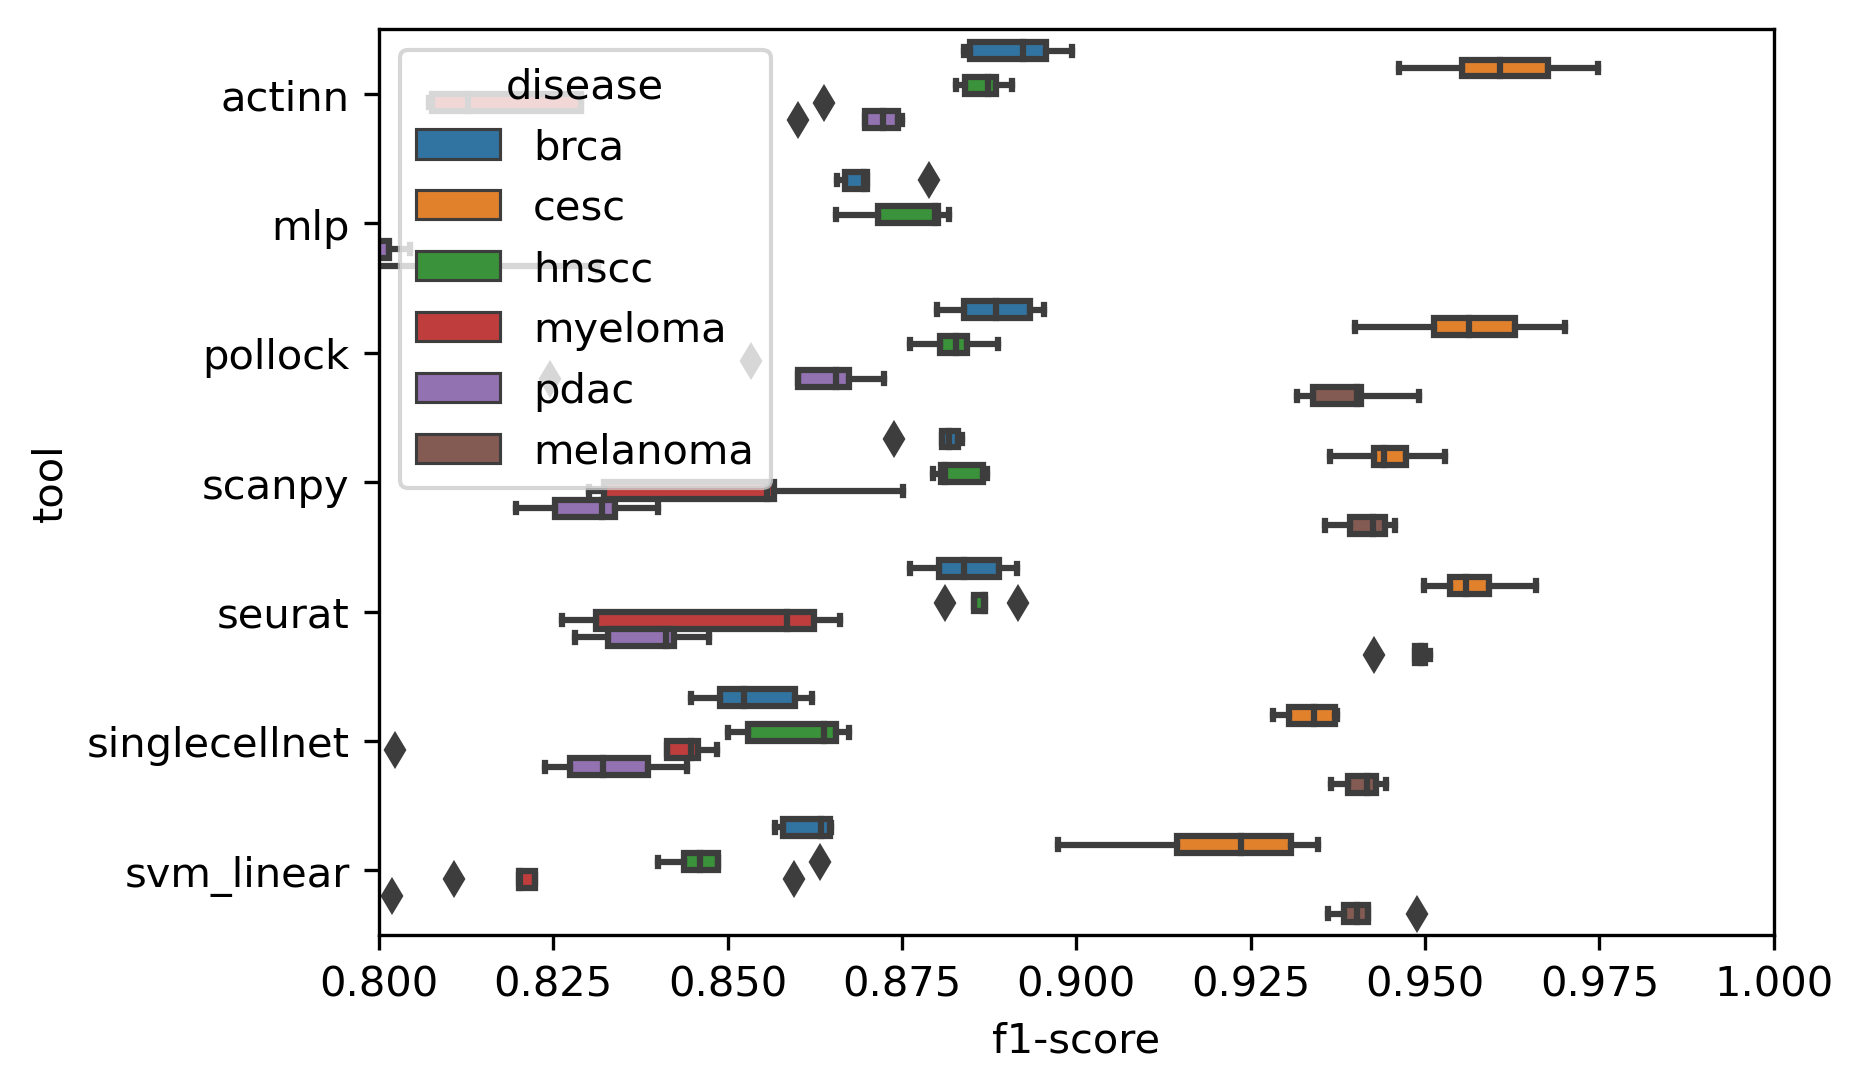

In [46]:
sns.boxplot(data=df[df['dtype']=='scRNAseq'], y='tool', x='f1-score', hue='disease', orient='h')
plt.xlim((.8, 1.))

(0.8, 1.0)

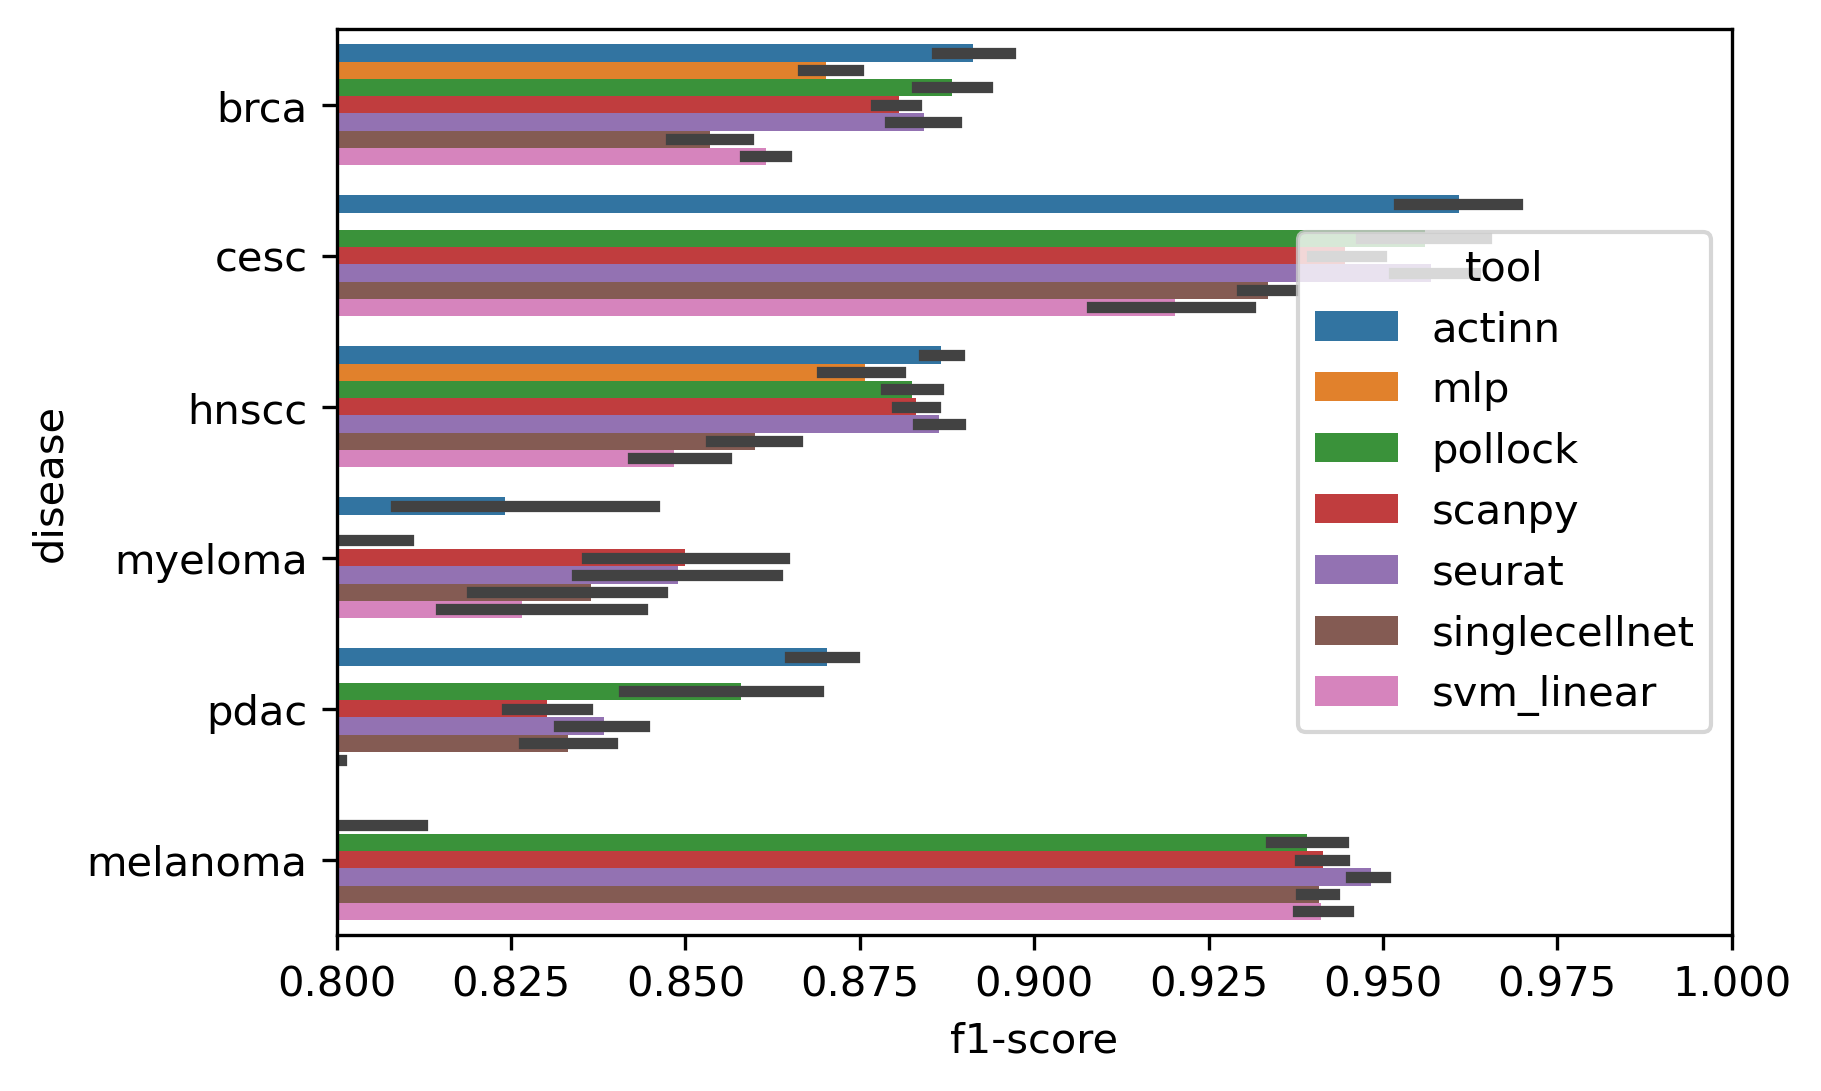

In [49]:
sns.barplot(data=df[df['dtype']=='scRNAseq'], y='disease', x='f1-score', hue='tool', orient='h')
plt.xlim((.8, 1.))